In [3]:
#The 3 following cells aim at simuling the behavior of NN models with a simple model for MNIST

EPOCH_SIZE = 32*32#*16*32*32
TEST_SIZE = 256*16#*32*32

#This is a function that can be used by several NN model
def train(model, optimizer ,func ,train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    #for (data, target) in train_loader:
    for batch_idx, (data, target) in enumerate(train_loader):
        # We set this just for the example to run quickly.
        if batch_idx * len(data) > EPOCH_SIZE:
           # print("hehe")
            return
        # We set this just for the example to run quickly.
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = func(output, target)
        loss.backward()
        optimizer.step()
        
#This is a function that can be used by several NN model (it only does accuracy ATM)
def test(model, func, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            # We set this just for the example to run quickly.
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            total += target.size(0)
            correct += (predicted == target).sum().item()


                
    return correct / total

In [4]:
# A random mnist from the internet to get a correct model to reason about

class train_mnist():
    def __init__(self,config):
        
        self.config = {
        "sigmoid_func": 1
      ,  "hidden_dim":43
      ,  "n_layer":2    }
        for key, value in config.items():
            self.config[key] = value
        config = self.config
        
        self.i = 0
        
        #mnist_transforms = transforms.Compose(
        #    [transforms.ToTensor(),
        #     transforms.Normalize((0.1307, ), (0.3081, ))])

        mnist_transforms = transforms.ToTensor()
        self.train_loader = DataLoader(
            datasets.MNIST("~/data", train=True, download=True, transform=mnist_transforms),
            batch_size=64,
            shuffle=True)
     #   self.test_loader = DataLoader(
      #      datasets.MNIST("~/data", train=False, transform=mnist_transforms),
       #     batch_size=64,
        #    shuffle=True)

        
        test_valid_dataset = datasets.MNIST("~/data", train=False, transform=mnist_transforms)
        valid_ratio = 0.5  
        nb_test = int((1.0 - valid_ratio) * len(test_valid_dataset))
        nb_valid =  int(valid_ratio * len(test_valid_dataset))
        test_dataset, val_dataset = torch.utils.data.dataset.random_split(test_valid_dataset, [nb_test, nb_valid])
        self.test_loader =  DataLoader(test_dataset,
            batch_size=64,
            shuffle=True)

        self.val_loader =  DataLoader(val_dataset,
            batch_size=64,
            shuffle=True)

        sigmoid_func_uniq = nn.Tanh()


        self.model = LeNet(192,int(round(config.get("hidden_dim",64))),10,
                    int( round(config.get("n_layer",1))),
                    config.get("droupout_prob",0.5) ,sigmoid_func_uniq)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config.get("lr", 0.01), 
                                     betas=((config.get("b1", 0.999),config.get("b2", 0.9999))),
                                     eps=config.get("eps", 1e-08), 
                                     weight_decay=config.get("weight_decay", 0), 
                                     amsgrad=True)

    
    def adapt(self, config):
        #print(self.optimizer)
        temp = copy.deepcopy(self)
        for key, value in config.items():
            temp.config[key] = value
        config = temp.config

        temp.model.adapt(config.get("droupout_prob", 0.5))
        temp.optimizer = torch.optim.Adam(temp.model.parameters(), lr=config.get("lr", 0.01), 
                                     betas=((config.get("b1", 0.999),config.get("b2", 0.9999))),
                                     eps=config.get("eps", 1e-08), 
                                     weight_decay=config.get("weight_decay", 0), 
                                     amsgrad=True)
        return temp
    
    
# All NN models should have a function train1 and test1 that calls the common train and test defined above.
# train1 and test1 is then used in the scheduler
    def train1(self):
        print("iteration: " + str(self.i) )
        self.i+=1
        train(self.model, self.optimizer, F.nll_loss, self.train_loader)

    def val1(self):
        return test(self.model, F.nll_loss, self.val_loader)
        
    def test1(self):
        return test(self.model, F.nll_loss, self.test_loader)

    def step(self):
        train1()
        return val1()

# __INCEPTION_SCORE_begin__
class LeNet(nn.Module):
    """
    LeNet for MNist classification, used for inception_score
    """

    def __init__(self,input_dim, hidden_dim, output_dim, n_layers,
            drop_prob, sigmoid ):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(drop_prob)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def adapt(self,drop_prob):
        self.conv2_drop = nn.Dropout2d(drop_prob)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



# Convolution Neural network using Pytorch 
class ConvNet(nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim, n_layers,
                 drop_prob, sigmoid ):
        super(ConvNet, self).__init__()
        
        self.sigmoid = sigmoid
        self.i_d = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)

        self.fc = nn.Linear(input_dim, output_dim)
        self.first= nn.Linear(input_dim, hidden_dim)
        self.hidden = [nn.Linear(hidden_dim,hidden_dim) for _ in range(self.n_layers)]
        self.drop_out = nn.Dropout(drop_prob)

        self.last = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.sigmoid(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, self.i_d)
        x=self.first(x)
        x=self.drop_out(x)
        for i in range(self.n_layers):
            x=self.hidden[i](x)
            x=self.drop_out(x)
        x = self.last(x)
        return F.log_softmax(x, dim=1)


In [37]:
config_linear_reg = {
    "lr": 0.031,
    "l2_regularization": .01,
    "minibatch_size": 512,
    "hidden_dims": [150, 100, 75],
    "droupout_prob": 0.28,
    "weight_decay": .017,
    "batch_size": 64
}

class LinearReg(nn.Module):
    def __init__(self, config):
        super(LinearReg, self).__init__()

        hidden_dims = config.get("hidden_dims", [150, 100, 75])
        self.linears = nn.ModuleList([nn.Linear(28*28, hidden_dims[0], bias=True), nn.ReLU()])
        for i in range(1, len(hidden_dims) ):
            self.linears.append(nn.Linear(hidden_dims[i-1], hidden_dims[i], bias=True))
            self.linears.append(nn.ReLU())
        self.model = Net(self.linears) 

        mnist_transforms = transforms.Compose([transforms.ToTensor(), \
                                               transforms.Normalize((0.1307,), (0.3081,))])

        self.train_loader = DataLoader(datasets.MNIST("~/data", train=True, download=True, transform=mnist_transforms),\
                                       batch_size=config.get("batch_size", 64), shuffle=True)

        self.test_loader = DataLoader(datasets.MNIST("~/data", train=False, transform=mnist_transforms),\
                                      batch_size=config.get("batch_size", 64), shuffle=True)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config.get("lr", 0.01), 
                                     betas=((config.get("b1", 0.999),config.get("b2", 0.9999))),
                                    eps=config.get("eps", 1e-08), 
                                     weight_decay=config.get("weight_decay", 0), 
                                     amsgrad=True)
    def adapt(self, config):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config.get("lr", 0.01), \
                                          betas=((config.get("b1", 0.999),config.get("b2", 0.9999))),\
                                          eps=config.get("eps", 1e-08), weight_decay=config.get("weight_decay", 0), \
                                          amsgrad=True)
        
    def forward(self, x):
        for i, layer in enumerate(self.linears):
            x = l(x)
        return x     
    
    def train1(self):
        train(self.model, self.optimizer, F.nll_loss, self.train_loader)

    def test1(self):
        return test(self.model, F.nll_loss, self.test_loader)
    
    
class Net(nn.Module):
    def __init__(self,linears):
        super(Net, self).__init__()
        self.linears = linears

    def forward(self, x):
        for i, layer in enumerate(self.linears):
            x = layer(x)
        return x 


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import torch.nn.functional as F
import math
import numpy as np
import random
import math 


In [16]:
config = {
    "lr": 0.031,
    "l2_regularization": .01,
    "minibatch_size": 512,
    "hidden_dims": [150, 100, 75],
    "droupout_prob": 0.28,
    "weight_decay": .017,
    "batch_size": 64
}

a = LinearReg(config)
a.train1()
print(a.test1())


NameError: name 'LinearReg' is not defined

In [5]:
# A random mnist from the internet to get a correct model to reason about

class toy():
    def __init__(self,config):
        self.hyperparameter = config.get("lr",0)
    
    def adapt(self,config):
        self.hyperparameter = config.get("lr",0)
        return self
    
    def train1(self):
        self.hyperparameter = self.hyperparameter * 2 
    def test1(self):
        return self.hyperparameter

# This should be a hyperspace instead of constants.
config= {
     "lr": 0.031
}
a = train_mnist(config)
a.train1()
print(a.test1())

class Parent():
    """Parent Class that handles the passage of Network Configurations from one step to the
    following
    """
    def __init__(self, point_hyperspace, configuration, model, loss):
        self.point_hyperspace = point_hyperspace
        self.configuration_list = [configuration]
        self.loss_list = [np.array(loss)]
        self.model = model
        self.is_replicated = False

    def update(self, configuration, loss, model):
        self.is_replicated = False
        self.configuration_list.append(configuration)
        self.loss_list=np.append(self.loss_list,loss)
        self.model = model

    def replication(self, n_children):
        self.is_replicated = True
      #  self.configuration_list.append(self.configuration_list[-1])
      #  self.loss_list=np.append(self.loss_list,self.loss_list[-1])
    #    replication_trials(self.point_hyperspace.trials, n_children)

    def get_last_conf(self):
        return self.configuration_list[-1]

    def get_point_hyperspace(self):
        return self.point_hyperspace

    def get_model(self):
        return self.model

    def get_loss(self):
        return self.loss_list


AttributeError: module 'torchvision.datasets' has no attribute 'CIFAR'

In [63]:
trials =scheduler.parents[0].hyperspace
def dumb_name(lisst,n):
    for a in lisst:
        print(a)
        a['tid']=a['tid']+n 
        a['misc']['tid']=a['misc']['tid']+n
        for b,c in a['misc']['idxs'].items():
            c[0] = c[0] +n 
        
        a['misc']['vals']['itération'][0] = a['misc']['vals']['itération'][0] + 1 
    return lisst
            
            


dumb_name(b)

In [66]:

def replication_trials(liste, n):
    for a in liste:
        a['tid']=a['tid']+n 
        a['misc']['tid'] = a['misc']['tid']+n

        for b,c in a['misc']['idxs'].items():
            c[0] = c[0] + n

        a['misc']['vals']['itération'][0] = a['misc']['vals']['itération'][0] + 1


In [116]:
import copy


class Scheduler():
    def __init__(self, model, num_iteration, num_config,
                 oracle):
        #Oracle manages the Bayesian optimization
        self.oracle = oracle
        self.iteration = num_iteration
        self.num_config = num_config 
        self.sqrt_config =   math.floor(math.sqrt(num_config)) # math.ceil(num_config/5) #
        self.n_parents =  self.sqrt_config
        
        #self.h is for the m "h" used at every loop, h is a configuration from the search space
        self.h = np.repeat({},num_config) 
        
        #self.out is for storing the result of the algorithm, ie all "h" from all iterations
        #from all sqrt(m) best models per iterations.
        self.out = np.zeros((num_iteration,self.sqrt_config))
        
        #self.hyperspaces is for storing the sqrt(m) hyperspaces used by the algorithm
        self.hyperspaces = np.zeros(self.sqrt_config)
        
        self.plot = np.zeros(num_iteration)

        
        #self.model is the m model that will explore new hyperspace points at every iterations
        self.models = np.repeat(model,num_config)
        
        #self.parents is the sqrt(m) best model from last iteration
        self.parents = np.repeat(model,self.sqrt_config)

        #self.losses remembers the performances of all m models at one iteration to decide which ones are the sqrt(m) best from self.models.
        self.losses = np.zeros(num_config)
        
        self.k = [0] # c'est pour avoir un pointeur sur k, c'est pas plus que O(sqrt)-paralélisable  pour le moment du coup.
    
    def initialisation(self):
        num_config = self.num_config
        extended_Hyperspace = Trials()
        fmin_objective = partial(test_function, models=self.models,h=self.h,losses=self.losses,parent_model=self.models, k_f = self.k,iteration = 0)
        self.oracle.compute_batch(extended_Hyperspace ,num_config , 0 ,fmin_objective)
            
        indexes = np.argsort(self.losses)     
        self.out[0] = (self.losses[indexes])[0:self.sqrt_config]
        self.hyperspaces = np.repeat(extended_Hyperspace,self.sqrt_config)    
        self.parents = np.array([Parent(copy.deepcopy(extended_Hyperspace),(self.h[indexes])[i], (self.models[indexes])[i],(self.losses[indexes])[i])  
                                 for i in range(self.sqrt_config) ])         
        self.plot[0] = self.losses[indexes][0]
        
    def loop(self):
        sqrt_config = self.sqrt_config
        iteration = self.iteration
        for i in range(1,iteration):
            
            self.k[0] = 0
            start_time = time.time()
            
            
            for j in range(sqrt_config):
                parent = self.parents[j]
                point_extended_hyperspace = parent.get_point_hyperspace()
                print("\n loss of parent " + str(parent.get_loss()[-1]) )
                print("\n loss " + str(parent.get_loss()))
                
                
                fmin_objective = partial(test_function, models=self.models,h=self.h,losses=self.losses,parent_model=parent.get_model(), k_f = self.k,iteration = len(parent.get_loss()))

                    
                if not parent.is_replicated:
                
                    print('not replicated')
                    self.oracle.repeat_good(
                        point_extended_hyperspace,
                        len(parent.get_loss()),
                        fmin_objective,
                        parent.configuration_list[-1]
                    )

                    # computes the new batch for each one of the parents for every iteration
                    self.oracle.compute_batch(
                        point_extended_hyperspace,
                        int(self.num_config/self.n_parents) - 1,
                        len(parent.get_loss()),
                        fmin_objective
                    )
                else:

                    print('replicated')
                    self.oracle.compute_batch(
                        point_extended_hyperspace,
                        int(self.num_config/self.n_parents),
                        len(parent.get_loss()),
                        fmin_objective
                    )
                    

            #self.oracle.Repeat_good(extended_Hyperspace ,i ,fmin_objective,parent.configuration_list[-1])
             #   self.oracle.compute_Batch(extended_Hyperspace ,int(self.num_config/sqrt_config) -1 , i ,fmin_objective)
           
            print("totalt time: " +  str(time.time() - start_time))


            combined_losses = np.concatenate(
                        (
                            self.losses,
                            
                                [self.parents[i].get_loss()[-1].item() for i in range(self.n_parents)]
                            
                        ),
                        0
                    )
            ixs_parents = np.argsort(combined_losses)
            parent_idx = ixs_parents[:self.n_parents]
            print(combined_losses)
            print(parent_idx)
            # ??? why saving it in a numpt array ?
            # It is creating the new Parent `array`
            temp_parents = [''] * self.n_parents

            for j, x in enumerate(parent_idx):
                # ??? why converting it to integer ?
                x = int(x)
                if x >= self.num_config:
                    temp_parents[j] = copy.deepcopy(self.parents[x - self.num_config])
                    temp_parents[j].replication(self.n_parents)
                else:
                    temp_parents[j] = copy.deepcopy(self.parents[math.floor(x/self.num_config * self.n_parents)])
                    temp_parents[j].update(self.h[x], self.losses[x], self.models[x])
            self.parents = temp_parents
            

class FSVNLogger(tune.logger.Logger):
    def _init(self):
        progress_file = os.path.join(path, "FSVN.csv")
        self._continuing = os.path.exists(progress_file)
        self._file = open(progress_file, "a")
        self._csv_out = None
    def on_result(self, result):
        tmp = result.copy()
        result = flatten_dict(tmp, delimiter="/")
        if self._csv_out is None:
            self._csv_out = csv.DictWriter(self._file, result.keys())
            self._csv_out.writeheader()

            #if not self._continuing:
        self._csv_out.writerow(
            {k: v
             for k, v in result.items() if k in self._csv_out.fieldnames})
        self._file.flush()
                   
fsvnlogger = FSVNLogger(config,"")

    
CONFIGURATION = 4
ITERATIONS = 10
config= {
     "lr": hp.uniform("lr",0,.1)
    , "droupout_prob": hp.uniform("droupout_prob",0,1)
          ,   "weight_decay": hp.uniform("weight_decay",0,.1),
    "b1" : hp.uniform("b1",0.9, 1),
    "b2" : hp.uniform("b2",0.99, 1)
}

for _ in range(5):
    model = train_mnist
    oracle = Oracle(config)
    scheduler = Scheduler(
        model,
        ITERATIONS,
        CONFIGURATION,
        oracle) 


    start_time = time.time()
    scheduler.initialisation()     
    scheduler.loop()     
    print("totalt time: " +  str(time.time() - start_time))


b1 0.9101513594767114                                
b2 0.9909553126571408                                
droupout_prob 0.47266363964246916                    
itération -0.0                                       
lr 0.04354827501873731                               
weight_decay 0.015430904719127836                    
iteration: 0                                         
accuracy, 0.1154                                     

b1 0.9006432557427172                                               
b2 0.9902119795968597                                               
droupout_prob 0.4663146898203463                                    
itération 0.0                                                       
lr 0.041183541523791826                                             
weight_decay 0.0034530653958749352                                  
iteration: 0                                                        
accuracy, 0.1128                                                    

b1 0.976023270

weight_decay 0.002339530659586981                               
iteration: 6                                                    
accuracy, 0.9118                                                

100%|██████████| 15/15 [00:02<00:00,  5.89trial/s, best loss: -0.9118]
b1 0.9250708110356193                                  
b2 0.9918276990876892                                           
droupout_prob 0.32651312408923405                               
itération 6.0                                                   
lr 0.06868437374220472                                          
weight_decay 0.09870566632391778                               
iteration: 6                                                   
accuracy, 0.1178                                               

100%|██████████| 16/16 [00:02<00:00,  6.32trial/s, best loss: -0.9118]
totalt time: 10.254255056381226
[-0.9094 -0.098  -0.9118 -0.1178 -0.9048 -0.894 ]
[2 0]

 loss of parent -0.9118

 loss [-0.4754 -0.7416 -0.8296 -0.8414 

iteration: 2                                                  
accuracy, 0.1032                                              

b1 0.9620989091868384                                                
b2 0.991673816402902                                                 
droupout_prob 0.3143135861254983                                     
itération 2.0                                                        
lr 0.04444060430018609                                               
weight_decay 0.09231847876686725                                     
iteration: 2                                                         
accuracy, 0.1128                                                     

100%|██████████| 10/10 [00:05<00:00,  1.73trial/s, best loss: -0.1678]

 loss of parent -0.1562

 loss [-0.1128 -0.1678 -0.1562]
not replicated
b1 0.9003069940166114                                
b2 0.9900767712398624                                         
droupout_prob 0.9037396031231428                   

b1 0.9308442357351997                                  
b2 0.9928854242284161                                           
droupout_prob 0.35975428891165445                               
itération 7.0                                                   
lr 0.0030503083440814307                                        
weight_decay 0.015030913879696772                               
iteration: 7                                                    
accuracy, 0.812                                                 

100%|██████████| 21/21 [00:01<00:00, 11.12trial/s, best loss: -0.812]
b1 0.9428788996189792                                  
b2 0.995360305364413                                            
droupout_prob 0.1756364258613636                                
itération 7.0                                                   
lr 0.025911680047550494                                         
weight_decay 0.04005902686311563                                
iteration: 7                         

iteration: 3                                                    
accuracy, 0.7518                                                

100%|██████████| 15/15 [00:01<00:00,  8.86trial/s, best loss: -0.7518]
b1 0.9961055028173829                                  
b2 0.9997769903774917                                           
droupout_prob 0.7815241548350946                                
itération 3.0                                                   
lr 0.040751465848000726                                         
weight_decay 0.060858686446079516                               
iteration: 3                                                    
accuracy, 0.2064                                                

100%|██████████| 16/16 [00:01<00:00,  8.14trial/s, best loss: -0.7518]

 loss of parent -0.5202

 loss [-0.1082 -0.4566 -0.1992 -0.5202]
replicated
b1 0.9590674579500419                                  
b2 0.9968453208626047                                           
droupout_prob 0.8

droupout_prob 0.7473645837403329                                   
itération 1.0                                                      
lr 0.08918348581455514                                             
weight_decay 0.06286466869702038                                   
iteration: 1                                                       
accuracy, 0.1                                                      

100%|██████████| 8/8 [00:05<00:00,  1.45trial/s, best loss: -0.313]
totalt time: 10.450480222702026
[-0.3676 -0.1114 -0.205  -0.1    -0.313  -0.2018]
[0 4]

 loss of parent -0.3676

 loss [-0.2018 -0.313  -0.3676]
not replicated
b1 0.990537601940934                                 
b2 0.9900181745667115                                         
droupout_prob 0.9116633673554677                              
itération 3.0                                                 
lr 0.0014590730577423337                                     
weight_decay 0.011336420438742646                        

b1 0.9905376018673657                                  
b2 0.9900181747038707                                           
droupout_prob 0.9116633674112251                                
itération 6.0                                                   
lr 0.0014590731710650156                                        
weight_decay 0.011336420535604323                              
iteration: 6                                                   
accuracy, 0.6818                                               

100%|██████████| 15/15 [00:02<00:00,  5.49trial/s, best loss: -0.6818]
b1 0.9397995502350213                                  
b2 0.9946637863238692                                           
droupout_prob 0.7171049289074023                                
itération 6.0                                                   
lr 0.023061183168550492                                         
weight_decay 0.09977840845996255                                
iteration: 6                           

b2 0.9949552587073721                                        
droupout_prob 0.5904287962338042                             
itération 2.0                                                
lr 0.000660247528469032                                      
weight_decay 0.02485843003916493                             
iteration: 2                                                 
accuracy, 0.1084                                             

100%|██████████| 7/7 [00:02<00:00,  2.80trial/s, best loss: -0.1084]
b1 0.9298478639709442                                
b2 0.9995376046202238                                        
droupout_prob 0.014378051614424237                           
itération 2.0                                                
lr 0.06668374439861864                                       
weight_decay 0.05575455179165351                             
iteration: 2                                                 
accuracy, 0.1004                                             

100%|██

iteration: 7                                                          
accuracy, 0.2444                                                      

100%|██████████| 20/20 [00:04<00:00,  4.05trial/s, best loss: -0.4076]
totalt time: 10.196945428848267
[-0.5056 -0.309  -0.4076 -0.2444 -0.405  -0.3224]
[0 2]

 loss of parent -0.5056

 loss [-0.1084 -0.1084 -0.1084 -0.1084 -0.1084 -0.1858 -0.3224 -0.405  -0.5056]
not replicated
b1 0.9566616044987182                                  
b2 0.9952330578455786                                           
droupout_prob 0.5833162153652705                                
itération 9.0                                                   
lr 0.002055075910631598                                         
weight_decay 0.021008243963277797                               
iteration: 9                                                    
accuracy, 0.597                                                 

100%|██████████| 21/21 [00:02<00:00,  8.40trial/s, best loss: -0.

In [29]:
scheduler.parents[0]

AttributeError: 'PB2' object has no attribute 'parents'

-0.9196

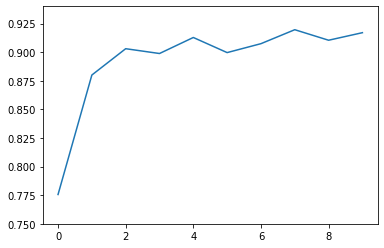

In [113]:
a = scheduler.plot
ax = plt.gca()
ax.set_ylim(.75,.94)
plt.plot(-a)
a[7]

<function matplotlib.pyplot.show(close=None, block=None)>

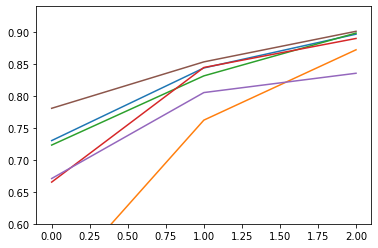

In [105]:
g = scheduler.plot
import matplotlib.pyplot as plt

ax = plt.gca()
ax.set_ylim(.6,.94)

c = np.array([0.4952, 0.7621, 0.8721] )  
plt.plot(-b)
plt.plot(c)
plt.plot(-d)
plt.plot(-e)
plt.plot(-f)
plt.plot(-g)
plt.show



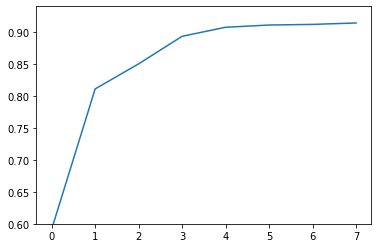

In [409]:
b
import matplotlib.pyplot as plt
ax = plt.gca()
ax.set_ylim(.6,.94)

plt.plot(-a)

In [76]:
from hyperopt import hp, fmin, tpe, Trials
from functools import *
# Oracle (Paul) TODO
path = "/home/antoine/"
class Oracle():
    def __init__(self, searchspace ):
        #self.hyperspace is the original (input) searchspace
        self.searchspace = searchspace

    def repeat_good(self,trials, iteration,function,configuration): #add space
        space = copy.deepcopy(configuration)
        for k,v in configuration.items():
            space[k] =  hp.uniform(k,-1e-10+v,v + 1e-10) 

        curr_eval = getattr(trials,'_ids')
        if curr_eval == set():
            curr_eval = 0
        else:
            curr_eval = max(curr_eval) +1
        space["itération"] =  hp.quniform("itération",-.5+iteration,.5+iteration, 1) 
        fmin(function, space, algo=partial(tpe.suggest, n_startup_jobs=1), max_evals=curr_eval
+1, trials=trials)
        
    def compute_once(self,trials, iteration,function): #add space
        space = copy.deepcopy(self.searchspace)
        curr_eval = getattr(trials,'_ids')
        if curr_eval == set():
            curr_eval = 0
        else:
            curr_eval = max(curr_eval) +1
        space["itération"] =  hp.quniform("itération",-.5+iteration,.5+iteration, 1) 
        fmin(function, space, algo=partial(tpe.suggest, n_startup_jobs=1), max_evals=curr_eval
+1, trials=trials)
        
        
    def compute_batch(self,trials, nb_eval, iteration,function): #add space
        space = copy.deepcopy(self.searchspace)
        curr_eval = getattr(trials,'_ids')
        if curr_eval == set():
            curr_eval = 0
        else:
            curr_eval = max(curr_eval) +1
            
        space["itération"] =  hp.quniform("itération",-.5+iteration,.5+iteration, 1) 
        fmin(function, space, algo=partial(tpe.suggest, n_startup_jobs=1), max_evals=curr_eval
+nb_eval, trials=trials)
    


In [110]:
def test_function(x,models,h,losses, parent_model,k_f,iteration):
    if (isinstance(k_f,list)):
            k=k_f[0]
            Islist = True 
    else:
            k = k_f
            Islist = False
        
    if iteration == 0:
        models[k] = parent_model[k](x)
    else:      
        models[k] = parent_model.adapt(x)
    if(Islist):
        k_f[0] += 1
    
    for key, value in x.items():
            print(key + " "+str(x[key]))

    h[k] = x
    import time
    start_time = time.time()
    models[k].train1()
    loss = models[k].test1()
    test = models[k].val1()
    #print("--- %s seconds ---" % (time.time() - start_time))

    temp = dict(x)
    temp.update({'loss' : loss})
    temp.update({'test' : test})
    fsvnlogger.on_result(temp)

    losses[k] = -loss
    print("accuracy, " + str(loss) + "\n")
    return -loss

In [18]:
#Normal random Opt
evals = 25
crypt = np.zeros(evals)
def function(x):
    print(x)
    model = train_mnist(x)
    for _ in range(10):
        model.train1()
        loss = model.test1()
        test = model.val1()
        temp = dict(x)
        temp.update({'loss' : loss})
        temp.update({'test' : test})

        temp.update({'iteration' :  model.i})
        hyperlogger.on_result(temp)
    
  #  loss = model.test1()
    return -loss

In [27]:
class RandomOpt():
    def __init__(self, searchspace ):
        self.searchspace = searchspace

    def compute_Once(self,function): 
        fmin(function, self.searchspace, algo=partial(tpe.rand.suggest), max_evals=evals, trials=Trials())
    
config= {
     "lr": hp.uniform("lr",0,.1),
     "droupout_prob": hp.uniform("droupout_prob",0,1),
     "weight_decay": hp.uniform("weight_decay",0,.1),
    "b1" : hp.uniform("b1",0.9, 1),
    "b2" : hp.uniform("b2",0.99, 1)
    
}


In [28]:
class RandomLogger(tune.logger.Logger):
    def _init(self):
        progress_file = os.path.join(path, "randomoptMNIST.csv")
        self._continuing = os.path.exists(progress_file)
        self._file = open(progress_file, "a")
        self._csv_out = None
    def on_result(self, result):
        tmp = result.copy()
        result = flatten_dict(tmp, delimiter="/")
        if self._csv_out is None:
            self._csv_out = csv.DictWriter(self._file, result.keys())
            self._csv_out.writeheader()

            #if not self._continuing:
        self._csv_out.writerow(
            {k: v
             for k, v in result.items() if k in self._csv_out.fieldnames})
        self._file.flush()
        
        
for _ in range(4):
    hyperlogger = RandomLogger(config,"")

    start_time = time.time()
    oracle = RandomOpt(config)
    oracle.compute_Once(function)
    print("totalt time: " +  str(time.time() - start_time))


{'b1': 0.9189993770004697, 'b2': 0.9973325493450456, 'droupout_prob': 0.7403338264108734, 'lr': 0.030448040266470223, 'weight_decay': 0.012493255109353053}
iteration: 0                                          
iteration: 1                                          
iteration: 2                                          
iteration: 3                                          
iteration: 4                                          
iteration: 5                                          
iteration: 6                                          
iteration: 7                                          
iteration: 8                                          
iteration: 9                                          
{'b1': 0.9158124414510105, 'b2': 0.9903979141851905, 'droupout_prob': 0.8476347261290749, 'lr': 0.0981833034273808, 'weight_decay': 0.09336016438551913}
iteration: 0                                                            
iteration: 1                                                        

iteration: 6                                                             
iteration: 7                                                             
iteration: 8                                                             
iteration: 9                                                             
{'b1': 0.9295786223052106, 'b2': 0.9961042657819845, 'droupout_prob': 0.9936551659037934, 'lr': 0.0015336972302122055, 'weight_decay': 0.028022164913583527}
iteration: 0                                                             
iteration: 1                                                             
iteration: 2                                                             
iteration: 3                                                             
iteration: 4                                                             
iteration: 5                                                             
iteration: 6                                                             
iteration: 7                 

iteration: 0                                                           
iteration: 1                                                           
iteration: 2                                                           
iteration: 3                                                           
iteration: 4                                                           
iteration: 5                                                           
iteration: 6                                                           
iteration: 7                                                           
iteration: 8                                                           
iteration: 9                                                           
{'b1': 0.9933293278536935, 'b2': 0.9941840827169341, 'droupout_prob': 0.4369735631442889, 'lr': 0.08711714574132529, 'weight_decay': 0.03155709419286128}
iteration: 0                                                           
iteration: 1                                          

iteration: 8                                                          
iteration: 9                                                          
{'b1': 0.9071605891631305, 'b2': 0.9900179621141229, 'droupout_prob': 0.8552990545794595, 'lr': 0.00471236427722942, 'weight_decay': 0.04609216524340403}
iteration: 0                                                            
iteration: 1                                                            
iteration: 2                                                            
iteration: 3                                                            
iteration: 4                                                            
iteration: 5                                                            
iteration: 6                                                            
iteration: 7                                                            
iteration: 8                                                            
iteration: 9                                   

iteration: 0                                                             
iteration: 1                                                             
iteration: 2                                                             
iteration: 3                                                             
iteration: 4                                                             
iteration: 5                                                             
iteration: 6                                                             
iteration: 7                                                             
iteration: 8                                                             
iteration: 9                                                             
{'b1': 0.9951249818874776, 'b2': 0.9924839454756063, 'droupout_prob': 0.38757256459359535, 'lr': 0.058366615994601745, 'weight_decay': 0.0032856003690846405}
iteration: 0                                                             
iteration: 1                

iteration: 5                                                            
iteration: 6                                                            
iteration: 7                                                            
iteration: 8                                                            
iteration: 9                                                            
{'b1': 0.945470596343687, 'b2': 0.998005092799431, 'droupout_prob': 0.265509019546013, 'lr': 0.019121324684888988, 'weight_decay': 0.015166177603486198}
iteration: 0                                                            
iteration: 1                                                            
iteration: 2                                                            
iteration: 3                                                            
iteration: 4                                                            
iteration: 5                                                            
iteration: 6                                

In [56]:
class BayesOpt():
    def __init__(self, searchspace ):
        self.searchspace = searchspace

    def compute_Once(self,function): 
        fmin(function, self.searchspace, algo=partial(tpe.suggest, n_startup_jobs=1), max_evals=evals, trials=Trials())
    
config= {
     "lr": hp.uniform("lr",0,.1),
     "droupout_prob": hp.uniform("droupout_prob",0,1),
     "weight_decay": hp.uniform("weight_decay",0,.1),
    "b1" : hp.uniform("b1",0.9, 1),
    "b2" : hp.uniform("b2",0.99, 1)
    
}
oracle = BayesOpt(config)

In [57]:
class HyperLogger(tune.logger.Logger):
    def _init(self):
        progress_file = os.path.join(path, "hyperopt.csv")
        self._continuing = os.path.exists(progress_file)
        self._file = open(progress_file, "a")
        self._csv_out = None
    def on_result(self, result):
        tmp = result.copy()
        result = flatten_dict(tmp, delimiter="/")
        if self._csv_out is None:
            self._csv_out = csv.DictWriter(self._file, result.keys())
            self._csv_out.writeheader()

            #if not self._continuing:
        self._csv_out.writerow(
            {k: v
             for k, v in result.items() if k in self._csv_out.fieldnames})
        self._file.flush()
                   
hyperlogger = HyperLogger(config,"")


oracle.compute_Once(function)

{'b1': 0.9892011469652047, 'b2': 0.9971319000283183, 'droupout_prob': 0.6023687335417806, 'lr': 0.06409796849636061, 'weight_decay': 0.09260903854863428}
iteration: 0                                         
iteration: 1                                         
iteration: 2                                         
iteration: 3                                         
iteration: 4                                         
  0%|          | 0/2 [00:29<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [ ]:
# A random mnist from the internet to get a correct model to reason about
# IN THIS MODULE: IMPORTS, CNN, TRAIN, TEST, MNIS_FUNCTION, SPACE

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from hyperopt import hp
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.suggest.skopt import SkOptSearch
from ray import tune
from ray.tune.suggest.bayesopt import BayesOptSearch
import time
import ray
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest.ax import AxSearch
import argparse
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest.nevergrad import NevergradSearch
import nevergrad as ng
import json
import os
from ray.tune import Trainable
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.suggest.bohb import TuneBOHB
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest.dragonfly import DragonflySearch
from ray.tune.suggest.zoopt import ZOOptSearch
from ray.tune.schedulers import AsyncHyperBandScheduler
from zoopt import ValueType
import torch
# IN THIS MODULE: IMPORTS, CNN, TRAIN, TEST, MNIS_FUNCTION, SPACE

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from ray import tune
from ray.tune.schedulers import ASHAScheduler 
from ray.tune.schedulers import MedianStoppingRule

from hyperopt import hp
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.suggest.skopt import SkOptSearch
from ray import tune
from ray.tune.suggest.bayesopt import BayesOptSearch
import time
import ray
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest.ax import AxSearch
import argparse
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest.nevergrad import NevergradSearch
import nevergrad as ng
import json
import os
from ray.tune import Trainable
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.suggest.bohb import TuneBOHB
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.schedulers import AsyncHyperBandScheduler
#from ray.tune.suggest.dragonfly import DragonflySearch
from ray.tune.suggest.zoopt import ZOOptSearch
from ray.tune.schedulers import AsyncHyperBandScheduler
from zoopt import ValueType
import torch
import adabelief_pytorch
global_checkpoint_period=np.inf
from ray.tune.schedulers.pb2 import PB2

class train_mnist_pb2(tune.Trainable):
    def setup(self, config):
        self.config = {
        "sigmoid_func": 1
      ,  "hidden_dim":43
      ,  "n_layer":2    }
        for key, value in config.items():
            self.config[key] = value
        config = self.config
        
        self.i = 0
        
        mnist_transforms = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.1307, ), (0.3081, ))])

        self.train_loader = DataLoader(
            datasets.MNIST("~/data", train=True, download=True, transform=mnist_transforms),
            batch_size=64,
            shuffle=True)
        self.test_loader = DataLoader(
            datasets.MNIST("~/data", train=False, transform=mnist_transforms),
            batch_size=64,
            shuffle=True)

        
        test_valid_dataset = datasets.MNIST("~/data", train=False, transform=mnist_transforms)
        valid_ratio = 0.5  
        nb_test = int((1.0 - valid_ratio) * len(test_valid_dataset))
        nb_valid =  int(valid_ratio * len(test_valid_dataset))
        test_dataset, val_dataset = torch.utils.data.dataset.random_split(test_valid_dataset, [nb_test, nb_valid])
        self.test_loader =  DataLoader(test_dataset,
            batch_size=64,
            shuffle=True)

        self.val_loader =  DataLoader(val_dataset,
            batch_size=64,
            shuffle=True)

        sigmoid_func_uniq = nn.Tanh()


        self.model = LeNet(192,int(round(config.get("hidden_dim",64))),10,
                    int( round(config.get("n_layer",1))),
                    config.get("droupout_prob",0.5) ,sigmoid_func_uniq)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config.get("lr", 0.01), 
                                     betas=((config.get("b1", 0.999),config.get("b2", 0.9999))),
                                     eps=config.get("eps", 1e-08), 
                                     weight_decay=config.get("weight_decay", 0), 
                                     amsgrad=True)

    
    def adapt(self, config):
        #print(self.optimizer)
        temp = copy.deepcopy(self)
        for key, value in config.items():
            temp.config[key] = value
        config = temp.config

        temp.model.adapt(config.get("droupout_prob", 0.5))
        temp.optimizer = torch.optim.Adam(temp.model.parameters(), lr=config.get("lr", 0.01), 
                                     betas=((config.get("b1", 0.999),config.get("b2", 0.9999))),
                                     eps=config.get("eps", 1e-08), 
                                     weight_decay=config.get("weight_decay", 0), 
                                     amsgrad=True)
        return temp
    
    def reset_config(self, config):
        if "lr" in config:
            for param_group in self.optimizer.param_groups:
                param_group["lr"] = config.get("lr", 0.01)
        if "b1" in config:
            for param_group in self.optimizer.param_groups:
                param_group["betas"] = (
                    (config.get("b1", 0.999)),(config.get("b2", 0.9999)))
        if "wd" in config:
            for param_group in self.optimizer.param_groups:
                param_group["weight_decay"] = weight_decay
        
        self.model.adapt(config.get("droupout_prob", 0.5))

        self.config = config
        return True
    
# All NN models should have a function train1 and test1 that calls the common train and test defined above.
# train1 and test1 is then used in the scheduler
    def train1(self):
        print("iteration: " + str(self.i) )
        self.i+=1
        train(self.model, self.optimizer, F.nll_loss, self.train_loader)

    def val1(self):
        return test(self.model, F.nll_loss, self.val_loader)
        
    def test1(self):
        return test(self.model, F.nll_loss, self.test_loader)

    def step(self):
        self.train1()
        return {'loss' : self.test1(), 'test' : self.val1()}
    
    def save_checkpoint(self, checkpoint_dir):
        path = os.path.join(checkpoint_dir, "checkpoint")
        torch.save({
            "model": self.model.state_dict(),
            "optim": self.optimizer.state_dict(),

        }, path)

        return checkpoint_dir

    def load_checkpoint(self, checkpoint_dir):
        path = os.path.join(checkpoint_dir, "checkpoint")
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint["model"])
        self.optimizer.load_state_dict(checkpoint["optim"])



algo = HyperOptSearch(metric="loss",
    mode="max")

scheduler = PB2(
    time_attr="training_iteration",
    perturbation_interval=1,
    hyperparam_bounds={
        # distribution for resampling
     "lr": [0, .1] #tune.uniform(1e-4, 0.1 ),#,1e-4), #*10
,     "weight_decay":[0, .1]#tune.uniform(1, 5)#,1e-4), #*10 et 0
,     "b1": [.9, 1]#,1e-4), #*10 et 0
 ,    "b2": [.99, 1] #,1e-4), #*10 et 0
 ,    "droupout_prob": [0, 1]#,1e-4), #*10 et 0
    }) 

imageSize = 32

from ray.tune.logger import *

class TestLogger(tune.logger.Logger):
    def _init(self):
        progress_file = os.path.join(path, "PB2.csv")
        self._continuing = os.path.exists(progress_file)
        self._file = open(progress_file, "a")
        self._csv_out = None
    def on_result(self, result):
        tmp = result.copy()
        result = flatten_dict(tmp, delimiter="/")
        if self._csv_out is None:
            self._csv_out = csv.DictWriter(self._file, result.keys())
            self._csv_out.writeheader()
        self._csv_out.writerow(
            {k: v
             for k, v in result.items() if k in self._csv_out.fieldnames})
        self._file.flush()
                   

cst=imageSize
total=cst*cst*3
def trial_name_id(trial):
    return f"{trial.trainable_name}_{trial.trial_id}"
from ray import tune

analysis = tune.run(
train_mnist_pb2,
scheduler=scheduler,
reuse_actors=True,
search_alg=algo,
verbose=2,
checkpoint_at_end=True,
num_samples=5,
# export_formats=[ExportFormat.MODEL],
            config= {
 "lr":  tune.uniform(0, .1) #tune.uniform(1e-4, 0.1 ),#,1e-4), #*10
,     "weight_decay":tune.uniform(0, .1)#tune.uniform(1, 5)#,1e-4), #*10 et 0
,     "b1": tune.uniform(.9, 1)#,1e-4), #*10 et 0
 ,    "b2": tune.uniform(.99, 1)#,1e-4), #*10 et 0
 ,    "droupout_prob": tune.uniform(0, 1)#,1e-4), #*10 et 0
        
    },      stop={
        "training_iteration": 10,
    },        metric="loss",
    mode="max"

            ,     loggers=[TestLogger])

In [30]:
mnist_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307, ), (0.3081, ))])
    
train_loader = DataLoader(
    datasets.MNIST("~/data", train=True, download=True, transform=mnist_transforms),
    batch_size=64,
    shuffle=True)
test_loader = DataLoader(
    datasets.MNIST("~/data", train=False, transform=mnist_transforms),
    batch_size=64,
    shuffle=True)


test_valid_dataset = datasets.MNIST("~/data", train=False, transform=mnist_transforms)
valid_ratio = 0.5  
nb_test = int((1.0 - valid_ratio) * len(test_valid_dataset))
nb_valid =  int(valid_ratio * len(test_valid_dataset))
test_dataset, val_dataset = torch.utils.data.dataset.random_split(test_valid_dataset, [nb_test, nb_valid])
test_loader =  DataLoader(test_dataset,
    batch_size=64,
    shuffle=True)

val_loader =  DataLoader(val_dataset,
    batch_size=64,
    shuffle=True)

for batch_idx, (data, target) in enumerate(train_loader):
    print(np.where(np.isnan(data)))
    print(np.where(np.isnan(target)))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)
(array([], dtype

In [14]:
# A random mnist from the internet to get a correct model to reason about
# IN THIS MODULE: IMPORTS, CNN, TRAIN, TEST, MNIS_FUNCTION, SPACE

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from hyperopt import hp
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.suggest.skopt import SkOptSearch
from ray import tune
from ray.tune.suggest.bayesopt import BayesOptSearch
import time
import ray
from ray.tune.schedulers import AsyncHyperBandScheduler
import argparse
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest.nevergrad import NevergradSearch
import json
from ray.tune import Trainable
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest.dragonfly import DragonflySearch
from ray.tune.schedulers import AsyncHyperBandScheduler
import torch
# IN THIS MODULE: IMPORTS, CNN, TRAIN, TEST, MNIS_FUNCTION, SPACE

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from ray import tune
from ray.tune.schedulers import ASHAScheduler 
from ray.tune.schedulers import MedianStoppingRule

from hyperopt import hp
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.suggest.skopt import SkOptSearch
from ray import tune
from ray.tune.suggest.bayesopt import BayesOptSearch
import time
import ray
from ray.tune.schedulers import AsyncHyperBandScheduler
import argparse
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest.nevergrad import NevergradSearch
import json
import os
from ray.tune import Trainable
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.schedulers import AsyncHyperBandScheduler
#from ray.tune.suggest.dragonfly import DragonflySearch
from ray.tune.schedulers import AsyncHyperBandScheduler
import torch
#import adabelief_pytorch
global_checkpoint_period=np.inf
from ray.tune.schedulers.pb2 import PB2

class train_mnist_pb2(tune.Trainable):
    def setup(self, config):
        self.config = {
        "sigmoid_func": 1
      ,  "hidden_dim":43
      ,  "n_layer":2    }
        for key, value in config.items():
            self.config[key] = value
        config = self.config
        
        self.i = 0
        
        #mnist_transforms = transforms.Compose(
        #    [transforms.ToTensor(),
        #     transforms.Normalize((0.1307, ), (0.3081, ))])
        mnist_transforms = transforms.ToTensor()

        self.train_loader = DataLoader(
            datasets.MNIST("~/data", train=True, download=True, transform=mnist_transforms),
            batch_size=64,
            shuffle=True)
       # self.test_loader = DataLoader(
       #     datasets.MNIST("~/data", train=False, transform=mnist_transforms),
       #     batch_size=64,
       #     shuffle=True)

        
        test_valid_dataset = datasets.MNIST("~/data", train=False, transform=mnist_transforms)
        valid_ratio = 0.5  
        nb_test = int((1.0 - valid_ratio) * len(test_valid_dataset))
        nb_valid =  int(valid_ratio * len(test_valid_dataset))
        test_dataset, val_dataset = torch.utils.data.dataset.random_split(test_valid_dataset, [nb_test, nb_valid])
        self.test_loader =  DataLoader(test_dataset,
            batch_size=64,
            shuffle=True)

        self.val_loader =  DataLoader(val_dataset,
            batch_size=64,
            shuffle=True)

        sigmoid_func_uniq = nn.Tanh()


        self.model = LeNet(192,int(round(config.get("hidden_dim",64))),10,
                    int( round(config.get("n_layer",1))),
                    config.get("droupout_prob",0.5) ,sigmoid_func_uniq)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config.get("lr", 0.01), 
                                     betas=((config.get("b1", 0.999),config.get("b2", 0.9999))),
                                     eps=config.get("eps", 1e-08), 
                                     weight_decay=config.get("weight_decay", 0), 
                                     amsgrad=True)

    
    def adapt(self, config):
        #print(self.optimizer)
        temp = copy.deepcopy(self)
        for key, value in config.items():
            temp.config[key] = value
        config = temp.config

        temp.model.adapt(config.get("droupout_prob", 0.5))
        temp.optimizer = torch.optim.Adam(temp.model.parameters(), lr=config.get("lr", 0.01), 
                                     betas=((config.get("b1", 0.999),config.get("b2", 0.9999))),
                                     eps=config.get("eps", 1e-08), 
                                     weight_decay=config.get("weight_decay", 0), 
                                     amsgrad=True)
        return temp
    
    def reset_config(self, config):
        if "lr" in config:
            for param_group in self.optimizer.param_groups:
                param_group["lr"] = config.get("lr", 0.01)
        if "b1" in config:
            for param_group in self.optimizer.param_groups:
                param_group["betas"] = (
                    (config.get("b1", 0.999)),(config.get("b2", 0.9999)))
        if "wd" in config:
            for param_group in self.optimizer.param_groups:
                param_group["weight_decay"] = weight_decay
        
        self.model.adapt(config.get("droupout_prob", 0.5))

        self.config = config
        return True
    
# All NN models should have a function train1 and test1 that calls the common train and test defined above.
# train1 and test1 is then used in the scheduler
    def train1(self):
        print("iteration: " + str(self.i) )
        self.i+=1
        train(self.model, self.optimizer, F.nll_loss, self.train_loader)

    def val1(self):
        return test(self.model, F.nll_loss, self.val_loader)
        
    def test1(self):
        return test(self.model, F.nll_loss, self.test_loader)

    def step(self):
        self.train1()
        return {'loss' : self.test1(), 'test' : self.val1()}
    
    def save_checkpoint(self, checkpoint_dir):
        path = os.path.join(checkpoint_dir, "checkpoint")
        torch.save({
            "model": self.model.state_dict(),
            "optim": self.optimizer.state_dict(),

        }, path)

        return checkpoint_dir

    def load_checkpoint(self, checkpoint_dir):
        path = os.path.join(checkpoint_dir, "checkpoint")
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint["model"])
        self.optimizer.load_state_dict(checkpoint["optim"])



algo = HyperOptSearch(metric="loss",
    mode="max")
algo = ConcurrencyLimiter(algo, max_concurrent=25)
scheduler = PB2(
    time_attr="training_iteration",
    perturbation_interval=2,
    hyperparam_bounds={
        # distribution for resampling
     "lr": [0, .1] #tune.uniform(1e-4, 0.1 ),#,1e-4), #*10
,     "weight_decay":[0, .1]#tune.uniform(1, 5)#,1e-4), #*10 et 0
,     "b1": [.9, 1]#,1e-4), #*10 et 0
 ,    "b2": [.99, 1] #,1e-4), #*10 et 0
 ,    "droupout_prob": [0, 1]#,1e-4), #*10 et 0
    }) 

imageSize = 32

from ray.tune.logger import *


class TestLogger(tune.logger.Logger):
    def _init(self):
        progress_file = os.path.join(path, "PB2.csv")
        self._continuing = os.path.exists(progress_file)
        self._file = open(progress_file, "a")
        self._csv_out = None
    def on_result(self, result):
        tmp = result.copy()
        result = flatten_dict(tmp, delimiter="/")
        if self._csv_out is None:
            self._csv_out = csv.DictWriter(self._file, result.keys())
            self._csv_out.writeheader()
        self._csv_out.writerow(
            {k: v
             for k, v in result.items() if k in self._csv_out.fieldnames})
        self._file.flush()
                   

cst=imageSize
total=cst*cst*3
def trial_name_id(trial):
    return f"{trial.trainable_name}_{trial.trial_id}"
from ray import tune

for _ in range(5):
  ray.shutdown()
  ray.init()
  analysis = tune.run(
  train_mnist_pb2,
  scheduler=scheduler,
  reuse_actors=False,
  search_alg=algo,
  verbose=2,
  checkpoint_at_end=True,
  num_samples=25,
  # export_formats=[ExportFormat.MODEL],
              config= {
  "lr":  tune.uniform(0, .1) #tune.uniform(1e-4, 0.1 ),#,1e-4), #*10
  ,     "weight_decay":tune.uniform(0, .1)#tune.uniform(1, 5)#,1e-4), #*10 et 0
  ,     "b1": tune.uniform(.9, 1)#,1e-4), #*10 et 0
  ,    "b2": tune.uniform(.99, 1)#,1e-4), #*10 et 0
  ,    "droupout_prob": tune.uniform(0, 1)#,1e-4), #*10 et 0
          
      },      stop={
          "training_iteration": 10,
      },        metric="loss",
      mode="max"
              ,     loggers=[TestLogger])


2021-03-17 00:57:18,259	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=6034) iteration: 0
(pid=6034) iteration: 0
(pid=6034) iteration: 0
(pid=6034) iteration: 0
(pid=6034) iteration: 0
(pid=6034) iteration: 0
(pid=6034) iteration: 0
(pid=6037) iteration: 0
(pid=6037) iteration: 0
(pid=6037) iteration: 0
(pid=6037) iteration: 0
(pid=6037) iteration: 0
(pid=6037) iteration: 0
(pid=6037) iteration: 0
(pid=6039) iteration: 0
(pid=6039) iteration: 0
(pid=6039) iteration: 0
(pid=6039) iteration: 0
(pid=6039) iteration: 0
(pid=6039) iteration: 0
(pid=6039) iteration: 0
(pid=6033) iteration: 0
(pid=6033) iteration: 0
(pid=6033) iteration: 0
(pid=6033) iteration: 0
(pid=6033) iteration: 0
(pid=6033) iteration: 0
(pid=6033) iteration: 0
(pid=6040) iteration: 0
(pid=6040) iteration: 0
(pid=6040) iteration: 0
(pid=6040) iteration: 0
(pid=6040) iteration: 0
(pid=6040) iteration: 0
(pid=6040) iteration: 0
(pid=6038) iteration: 0
(pid=6038) iteration: 0
(pid=6038) iteration: 0
(pid=6038) iteration: 0
(pid=6038) iteration: 0
(pid=6038) iteration: 0
(pid=6038) itera

Trial train_mnist_pb2_583c77d6 reported loss=0.11 with parameters={'lr': 0.019819470849443035, 'weight_decay': 0.08787786344375734, 'b1': 0.9665286579192056, 'b2': 0.9922956386483458, 'droupout_prob': 0.3235459207828498}.
(pid=6037) iteration: 1
(pid=6037) iteration: 1
(pid=6037) iteration: 1
(pid=6037) iteration: 1
(pid=6037) iteration: 1
(pid=6037) iteration: 1
(pid=6037) iteration: 1
Trial train_mnist_pb2_5831c976 reported loss=0.90 with parameters={'lr': 0.07786679446400313, 'weight_decay': 0.06371187503001735, 'b1': 0.9999500651471744, 'b2': 0.9924214881581461, 'droupout_prob': 0.5732608942253362}.
(pid=6033) iteration: 1
(pid=6033) iteration: 1
(pid=6033) iteration: 1
(pid=6033) iteration: 1
(pid=6033) iteration: 1
(pid=6033) iteration: 1
(pid=6033) iteration: 1
Trial train_mnist_pb2_583f8c28 reported loss=0.96 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.1351764350574472

(pid=6039) iteration: 1
(pid=6039) iteration: 1
(pid=6039) iteration: 1
(pid=6039) iteration: 1
(pid=6039) iteration: 1
(pid=6039) iteration: 1
(pid=6039) iteration: 1
Trial train_mnist_pb2_58476ce0 reported loss=0.77 with parameters={'lr': 0.08608768477699376, 'weight_decay': 0.09736720860258678, 'b1': 0.9888234197155078, 'b2': 0.9912943832762798, 'droupout_prob': 0.6096709501456113}.


Trial train_mnist_pb2_5831c976 reported loss=0.87 with parameters={'lr': 0.07786679446400313, 'weight_decay': 0.06371187503001735, 'b1': 0.9999500651471744, 'b2': 0.9924214881581461, 'droupout_prob': 0.5732608942253362}.
(pid=6225) iteration: 0
(pid=6225) iteration: 0
(pid=6225) iteration: 0
(pid=6225) iteration: 0
(pid=6225) iteration: 0
(pid=6225) iteration: 0
(pid=6225) iteration: 0
Trial train_mnist_pb2_583a7846 reported loss=0.93 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.
Trial train_mnist_pb2_58438e18 reported loss=0.91 with parameters={'lr': 0.06256007931482292, 'weight_decay': 0.010812745721084184, 'b1': 0.9868288278470889, 'b2': 0.9984902333558433, 'droupout_prob': 0.38436327028389494}.
Trial train_mnist_pb2_583f8c28 reported loss=0.97 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 

2021-03-17 00:59:27,167	INFO pbt.py:535 -- [exploit] transferring weights from trial train_mnist_pb2_583a7846 (score 0.9294) -> train_mnist_pb2_583c77d6 (score 0.1024)
2021-03-17 00:59:27,219	INFO pbt.py:550 -- [explore] perturbed config from {'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673} -> {'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}


Trial train_mnist_pb2_583c77d6 reported loss=0.10 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.


(pid=6037) 2021-03-17 00:59:27,239	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583c77d6_5_b1=0.96653,b2=0.9923,droupout_prob=0.32355,lr=0.019819,weight_decay=0.087878_2021-03-17_00-57-20/tmpnc_rc4t0restore_from_object/./
(pid=6037) 2021-03-17 00:59:27,239	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 106.22926688194275, '_episodes_total': None}
(pid=6037) 2021-03-17 00:59:27,239	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583c77d6_5_b1=0.96653,b2=0.9923,droupout_prob=0.32355,lr=0.019819,weight_decay=0.087878_2021-03-17_00-57-20/tmpnc_rc4t0restore_from_object/./
(pid=6037) 2021-03-17 00:59:27,239	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 106.2292668

(pid=6448) iteration: 0
(pid=6448) iteration: 0
(pid=6448) iteration: 0
(pid=6448) iteration: 0
(pid=6448) iteration: 0
(pid=6448) iteration: 0
(pid=6448) iteration: 0


2021-03-17 00:59:30,464	INFO pbt.py:535 -- [exploit] transferring weights from trial train_mnist_pb2_583a7846 (score 0.9294) -> train_mnist_pb2_583677fa (score 0.1148)
2021-03-17 00:59:30,502	INFO pbt.py:550 -- [explore] perturbed config from {'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673} -> {'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}
(pid=6038) 2021-03-17 00:59:30,519	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583677fa_2_b1=0.91237,b2=0.99538,droupout_prob=0.38304,lr=0.076953,weight_decay=0.060151_2021-03-17_00-57-20/tmpjasq7s40restore_from_object/./
(pid=6038) 2021-03-17 00:59:30,519	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_

Trial train_mnist_pb2_583677fa reported loss=0.11 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.
Trial train_mnist_pb2_58384706 reported loss=0.12 with parameters={'lr': 0.017452783003022377, 'weight_decay': 0.09381562172047453, 'b1': 0.9195393379608402, 'b2': 0.9920265058515387, 'droupout_prob': 0.11641161307829662}.
(pid=6471) iteration: 0
(pid=6471) iteration: 0
(pid=6471) iteration: 0
(pid=6471) iteration: 0
(pid=6471) iteration: 0
(pid=6471) iteration: 0
(pid=6471) iteration: 0


(pid=6490) iteration: 0
(pid=6490) iteration: 0
(pid=6490) iteration: 0
(pid=6490) iteration: 0
(pid=6490) iteration: 0
(pid=6490) iteration: 0
(pid=6490) iteration: 0
Trial train_mnist_pb2_584c5cdc reported loss=0.10 with parameters={'lr': 0.09293995185398553, 'weight_decay': 0.08831000930169242, 'b1': 0.9712400293273346, 'b2': 0.9955693416963098, 'droupout_prob': 0.8219379646839111}.


(pid=6225) iteration: 1
(pid=6225) iteration: 1
(pid=6225) iteration: 1
(pid=6225) iteration: 1
(pid=6225) iteration: 1
(pid=6225) iteration: 1
(pid=6225) iteration: 1
Trial train_mnist_pb2_9791dc82 reported loss=0.94 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.
(pid=6248) iteration: 1
(pid=6248) iteration: 1
(pid=6248) iteration: 1
(pid=6248) iteration: 1
(pid=6248) iteration: 1
(pid=6248) iteration: 1
(pid=6248) iteration: 1
Trial train_mnist_pb2_98771900 reported loss=0.84 with parameters={'lr': 0.08279954963937271, 'weight_decay': 0.06134994518212964, 'b1': 0.9588260955366504, 'b2': 0.994589220936262, 'droupout_prob': 0.03099797880444566}.
(pid=6274) iteration: 1
(pid=6274) iteration: 1
(pid=6274) iteration: 1
(pid=6274) iteration: 1
(pid=6274) iteration: 1
(pid=6274) iteration: 1
(pid=6274) iteration: 1
Trial train_mnist_pb2_96b89832 reported loss=0.84 wi

(pid=6448) iteration: 1
(pid=6448) iteration: 1
(pid=6448) iteration: 1
(pid=6448) iteration: 1
(pid=6448) iteration: 1
(pid=6448) iteration: 1
(pid=6448) iteration: 1
Trial train_mnist_pb2_a5fdd370 reported loss=0.12 with parameters={'lr': 0.00970422638912253, 'weight_decay': 0.05411938631918148, 'b1': 0.962177111185227, 'b2': 0.9955580740753092, 'droupout_prob': 0.6316958559433492}.


(pid=6490) iteration: 1
(pid=6490) iteration: 1
(pid=6490) iteration: 1
(pid=6490) iteration: 1
(pid=6490) iteration: 1
(pid=6490) iteration: 1
(pid=6490) iteration: 1
Trial train_mnist_pb2_a4065d44 reported loss=0.11 with parameters={'lr': 0.005198180149192067, 'weight_decay': 0.09606968839014723, 'b1': 0.9113973686294576, 'b2': 0.9914373412535494, 'droupout_prob': 0.9520579017538008}.
(pid=6471) iteration: 1
(pid=6471) iteration: 1
(pid=6471) iteration: 1
(pid=6471) iteration: 1
(pid=6471) iteration: 1
(pid=6471) iteration: 1
(pid=6471) iteration: 1


2021-03-17 01:01:09,023	INFO pbt.py:482 -- [pbt]: no checkpoint for trial. Skip exploit for Trial train_mnist_pb2_584c5cdc


Trial train_mnist_pb2_584c5cdc reported loss=0.10 with parameters={'lr': 0.09293995185398553, 'weight_decay': 0.08831000930169242, 'b1': 0.9712400293273346, 'b2': 0.9955693416963098, 'droupout_prob': 0.8219379646839111}.


Trial train_mnist_pb2_9791dc82 reported loss=0.95 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.
(pid=6606) iteration: 0
(pid=6606) iteration: 0
(pid=6606) iteration: 0
(pid=6606) iteration: 0
(pid=6606) iteration: 0
(pid=6606) iteration: 0
(pid=6606) iteration: 0
Trial train_mnist_pb2_98771900 reported loss=0.82 with parameters={'lr': 0.08279954963937271, 'weight_decay': 0.06134994518212964, 'b1': 0.9588260955366504, 'b2': 0.994589220936262, 'droupout_prob': 0.03099797880444566}.
(pid=6611) iteration: 0
(pid=6611) iteration: 0
(pid=6611) iteration: 0
(pid=6611) iteration: 0
(pid=6611) iteration: 0
(pid=6611) iteration: 0
(pid=6611) iteration: 0
Trial train_mnist_pb2_96b89832 reported loss=0.85 with parameters={'lr': 0.07016081603226806, 'weight_decay': 0.07894418637214222, 'b1': 0.9964017109971276, 'b2': 0.991728036292974, 'droupout_prob': 0.5358486110126984}.


(pid=6695) iteration: 0
(pid=6695) iteration: 0
(pid=6695) iteration: 0
(pid=6695) iteration: 0
(pid=6695) iteration: 0
(pid=6695) iteration: 0
(pid=6695) iteration: 0
(pid=6699) iteration: 0
(pid=6699) iteration: 0
(pid=6699) iteration: 0
(pid=6699) iteration: 0
(pid=6699) iteration: 0
(pid=6699) iteration: 0
(pid=6699) iteration: 0


2021-03-17 01:01:21,257	INFO pbt.py:535 -- [exploit] transferring weights from trial train_mnist_pb2_583f8c28 (score 0.9682) -> train_mnist_pb2_9859fe38 (score 0.1014)
2021-03-17 01:01:21,294	INFO pbt.py:550 -- [explore] perturbed config from {'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725} -> {'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}
(pid=6265) 2021-03-17 01:01:21,311	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_9859fe38_12_b1=0.95816,b2=0.99506,droupout_prob=0.97002,lr=0.040589,weight_decay=0.090012_2021-03-17_00-59-07/tmpz20vp6d4restore_from_object/./
(pid=6265) 2021-03-17 01:01:21,311	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_tim

Trial train_mnist_pb2_9859fe38 reported loss=0.10 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


(pid=6809) iteration: 0
(pid=6809) iteration: 0
(pid=6809) iteration: 0
(pid=6809) iteration: 0
(pid=6809) iteration: 0
(pid=6809) iteration: 0
(pid=6809) iteration: 0
Trial train_mnist_pb2_98d085e4 reported loss=0.12 with parameters={'lr': 0.020981327712128905, 'weight_decay': 0.015464840475910603, 'b1': 0.9804423786292191, 'b2': 0.9942924143467906, 'droupout_prob': 0.9719393113175523}.


(pid=6831) iteration: 0
(pid=6831) iteration: 0
(pid=6831) iteration: 0
(pid=6831) iteration: 0
(pid=6831) iteration: 0
(pid=6831) iteration: 0
(pid=6831) iteration: 0


2021-03-17 01:02:04,948	INFO pbt.py:535 -- [exploit] transferring weights from trial train_mnist_pb2_9791dc82 (score 0.9548) -> train_mnist_pb2_a5fdd370 (score 0.1046)
2021-03-17 01:02:04,987	INFO pbt.py:550 -- [explore] perturbed config from {'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818} -> {'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}


Trial train_mnist_pb2_a5fdd370 reported loss=0.10 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.


(pid=6490) 2021-03-17 01:02:05,004	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a5fdd370_16_b1=0.96218,b2=0.99556,droupout_prob=0.6317,lr=0.0097042,weight_decay=0.054119_2021-03-17_00-59-33/tmpdrl6oxjdrestore_from_object/./
(pid=6490) 2021-03-17 01:02:05,004	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 119.19186568260193, '_episodes_total': None}
(pid=6490) 2021-03-17 01:02:05,004	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a5fdd370_16_b1=0.96218,b2=0.99556,droupout_prob=0.6317,lr=0.0097042,weight_decay=0.054119_2021-03-17_00-59-33/tmpdrl6oxjdrestore_from_object/./
(pid=6490) 2021-03-17 01:02:05,004	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 119.191

(pid=6852) iteration: 0
(pid=6852) iteration: 0
(pid=6852) iteration: 0
(pid=6852) iteration: 0
(pid=6852) iteration: 0
(pid=6852) iteration: 0
(pid=6852) iteration: 0
Trial train_mnist_pb2_e13a1282 reported loss=0.89 with parameters={'lr': 0.049622549121072126, 'weight_decay': 0.005043512486944124, 'b1': 0.9407186980984993, 'b2': 0.9995903568313215, 'droupout_prob': 0.32669751399508773}.


(pid=6695) iteration: 1
(pid=6695) iteration: 1
(pid=6695) iteration: 1
(pid=6695) iteration: 1
(pid=6695) iteration: 1
(pid=6695) iteration: 1
(pid=6695) iteration: 1
Trial train_mnist_pb2_a7804886 reported loss=0.10 with parameters={'lr': 0.09457082375680102, 'weight_decay': 0.05654104630080248, 'b1': 0.9189689293360078, 'b2': 0.9955970489012282, 'droupout_prob': 0.20020772160322065}.
(pid=6606) iteration: 1
(pid=6606) iteration: 1
(pid=6606) iteration: 1
(pid=6606) iteration: 1
(pid=6606) iteration: 1
(pid=6606) iteration: 1
(pid=6606) iteration: 1
Trial train_mnist_pb2_e0af861c reported loss=0.97 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.
(pid=6611) iteration: 1
(pid=6611) iteration: 1
(pid=6611) iteration: 1
(pid=6611) iteration: 1
(pid=6611) iteration: 1
(pid=6611) iteration: 1
(pid=6611) iteration: 1
Trial train_mnist_pb2_e3755e30 reported loss=0.86 

(pid=6809) iteration: 1
(pid=6809) iteration: 1
(pid=6809) iteration: 1
(pid=6809) iteration: 1
(pid=6809) iteration: 1
(pid=6809) iteration: 1
(pid=6809) iteration: 1
Trial train_mnist_pb2_e808a1fa reported loss=0.10 with parameters={'lr': 0.05963552393553702, 'weight_decay': 0.07100704572310321, 'b1': 0.9378691160851222, 'b2': 0.9999232680093064, 'droupout_prob': 0.7152953139715658}.


(pid=6831) iteration: 1
(pid=6831) iteration: 1
(pid=6831) iteration: 1
(pid=6831) iteration: 1
(pid=6831) iteration: 1
(pid=6831) iteration: 1
(pid=6831) iteration: 1
Trial train_mnist_pb2_a4065d44 reported loss=0.11 with parameters={'lr': 0.005198180149192067, 'weight_decay': 0.09606968839014723, 'b1': 0.9113973686294576, 'b2': 0.9914373412535494, 'droupout_prob': 0.9520579017538008}.


(pid=6901) iteration: 0
(pid=6901) iteration: 0
(pid=6901) iteration: 0
(pid=6901) iteration: 0
(pid=6901) iteration: 0
(pid=6901) iteration: 0
(pid=6901) iteration: 0
Trial train_mnist_pb2_ef976dc0 reported loss=0.92 with parameters={'lr': 0.02888338221286003, 'weight_decay': 0.04383622745964132, 'b1': 0.9993343498298692, 'b2': 0.993005681073738, 'droupout_prob': 0.5115100252706206}.


(pid=6852) iteration: 1
(pid=6852) iteration: 1
(pid=6852) iteration: 1
(pid=6852) iteration: 1
(pid=6852) iteration: 1
(pid=6852) iteration: 1
(pid=6852) iteration: 1
Trial train_mnist_pb2_e13a1282 reported loss=0.89 with parameters={'lr': 0.049622549121072126, 'weight_decay': 0.005043512486944124, 'b1': 0.9407186980984993, 'b2': 0.9995903568313215, 'droupout_prob': 0.32669751399508773}.


(pid=6924) iteration: 0
(pid=6924) iteration: 0
(pid=6924) iteration: 0
(pid=6924) iteration: 0
(pid=6924) iteration: 0
(pid=6924) iteration: 0
(pid=6924) iteration: 0
Trial train_mnist_pb2_e3755e30 reported loss=0.85 with parameters={'lr': 0.021787335406103593, 'weight_decay': 0.08953137316292953, 'b1': 0.9857475596231833, 'b2': 0.9955688666617112, 'droupout_prob': 0.20162113469593124}.


Trial train_mnist_pb2_e0af861c reported loss=0.97 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.
(pid=6955) iteration: 0
(pid=6955) iteration: 0
(pid=6955) iteration: 0
(pid=6955) iteration: 0
(pid=6955) iteration: 0
(pid=6955) iteration: 0
(pid=6955) iteration: 0


(pid=6955) 2021-03-17 01:03:21,949	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_5831c976_1_b1=0.99995,b2=0.99242,droupout_prob=0.57326,lr=0.077867,weight_decay=0.063712_2021-03-17_00-57-20/tmpiliyvn9drestore_from_object/./
(pid=6955) 2021-03-17 01:03:21,949	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 104.96142530441284, '_episodes_total': None}
(pid=6955) 2021-03-17 01:03:21,949	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_5831c976_1_b1=0.99995,b2=0.99242,droupout_prob=0.57326,lr=0.077867,weight_decay=0.063712_2021-03-17_00-57-20/tmpiliyvn9drestore_from_object/./
(pid=6955) 2021-03-17 01:03:21,949	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 104.96142

Trial train_mnist_pb2_e404f63a reported loss=0.89 with parameters={'lr': 0.038419609232831116, 'weight_decay': 0.03181668765725501, 'b1': 0.9986368980003989, 'b2': 0.9936399079236568, 'droupout_prob': 0.7575410766195854}.


(pid=6973) 2021-03-17 01:03:23,107	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583677fa_2_b1=0.91237,b2=0.99538,droupout_prob=0.38304,lr=0.076953,weight_decay=0.060151_2021-03-17_00-57-20/tmp1eisvobjrestore_from_object/./
(pid=6973) 2021-03-17 01:03:23,107	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 106.22926688194275, '_episodes_total': None}
(pid=6973) 2021-03-17 01:03:23,107	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583677fa_2_b1=0.91237,b2=0.99538,droupout_prob=0.38304,lr=0.076953,weight_decay=0.060151_2021-03-17_00-57-20/tmp1eisvobjrestore_from_object/./
(pid=6973) 2021-03-17 01:03:23,107	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 106.22926

(pid=6973) iteration: 0
(pid=6973) iteration: 0
(pid=6973) iteration: 0
(pid=6973) iteration: 0
(pid=6973) iteration: 0
(pid=6973) iteration: 0
(pid=6973) iteration: 0


(pid=6992) 2021-03-17 01:03:25,940	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58384706_3_b1=0.91954,b2=0.99203,droupout_prob=0.11641,lr=0.017453,weight_decay=0.093816_2021-03-17_00-57-20/tmpu5w1lexrrestore_from_object/./
(pid=6992) 2021-03-17 01:03:25,941	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 131.76421809196472, '_episodes_total': None}
(pid=6992) 2021-03-17 01:03:25,940	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58384706_3_b1=0.91954,b2=0.99203,droupout_prob=0.11641,lr=0.017453,weight_decay=0.093816_2021-03-17_00-57-20/tmpu5w1lexrrestore_from_object/./
(pid=6992) 2021-03-17 01:03:25,941	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 131.76421

(pid=6992) iteration: 0
(pid=6992) iteration: 0
(pid=6992) iteration: 0
(pid=6992) iteration: 0
(pid=6992) iteration: 0
(pid=6992) iteration: 0
(pid=6992) iteration: 0


2021-03-17 01:03:39,262	INFO pbt.py:535 -- [exploit] transferring weights from trial train_mnist_pb2_583f8c28 (score 0.9682) -> train_mnist_pb2_a7804886 (score 0.1082)
2021-03-17 01:03:39,304	INFO pbt.py:550 -- [explore] perturbed config from {'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725} -> {'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}


Trial train_mnist_pb2_a7804886 reported loss=0.11 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


(pid=6606) 2021-03-17 01:03:39,317	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a7804886_17_b1=0.91897,b2=0.9956,droupout_prob=0.20021,lr=0.094571,weight_decay=0.056541_2021-03-17_01-01-09/tmpfod84pp_restore_from_object/./
(pid=6606) 2021-03-17 01:03:39,317	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 106.88384914398193, '_episodes_total': None}
(pid=6606) 2021-03-17 01:03:39,317	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a7804886_17_b1=0.91897,b2=0.9956,droupout_prob=0.20021,lr=0.094571,weight_decay=0.056541_2021-03-17_01-01-09/tmpfod84pp_restore_from_object/./
(pid=6606) 2021-03-17 01:03:39,317	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 106.88384

(pid=7041) 2021-03-17 01:03:42,089	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583a7846_4_b1=0.96609,b2=0.99786,droupout_prob=0.30152,lr=0.049832,weight_decay=0.0095819_2021-03-17_00-57-20/tmpao6i_l5vrestore_from_object/./
(pid=7041) 2021-03-17 01:03:42,089	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 106.22926688194275, '_episodes_total': None}
(pid=7041) 2021-03-17 01:03:42,089	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583a7846_4_b1=0.96609,b2=0.99786,droupout_prob=0.30152,lr=0.049832,weight_decay=0.0095819_2021-03-17_00-57-20/tmpao6i_l5vrestore_from_object/./
(pid=7041) 2021-03-17 01:03:42,089	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 106.229

(pid=7041) iteration: 0
(pid=7041) iteration: 0
(pid=7041) iteration: 0
(pid=7041) iteration: 0
(pid=7041) iteration: 0
(pid=7041) iteration: 0
(pid=7041) iteration: 0
Trial train_mnist_pb2_020fd41a reported loss=0.83 with parameters={'lr': 0.03704030121289814, 'weight_decay': 0.03609526860566671, 'b1': 0.9914346949059964, 'b2': 0.9935283476117189, 'droupout_prob': 0.8191465829873545}.


(pid=6901) iteration: 1
(pid=6901) iteration: 1
(pid=6901) iteration: 1
(pid=6901) iteration: 1
(pid=6901) iteration: 1
(pid=6901) iteration: 1
(pid=6901) iteration: 1


2021-03-17 01:03:49,426	INFO pbt.py:535 -- [exploit] transferring weights from trial train_mnist_pb2_e0af861c (score 0.9722) -> train_mnist_pb2_e808a1fa (score 0.1016)
2021-03-17 01:03:49,476	INFO pbt.py:550 -- [explore] perturbed config from {'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126} -> {'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}
(pid=6831) 2021-03-17 01:03:49,498	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e808a1fa_22_b1=0.93787,b2=0.99992,droupout_prob=0.7153,lr=0.059636,weight_decay=0.071007_2021-03-17_01-01-34/tmpj9i_uqufrestore_from_object/./
(pid=6831) 2021-03-17 01:03:49,499	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timest

Trial train_mnist_pb2_e808a1fa reported loss=0.10 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.


(pid=7065) 2021-03-17 01:03:52,121	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583c77d6_5_b1=0.96653,b2=0.9923,droupout_prob=0.32355,lr=0.019819,weight_decay=0.087878_2021-03-17_00-57-20/tmp2iw6q8d1restore_from_object/./
(pid=7065) 2021-03-17 01:03:52,121	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 106.22926688194275, '_episodes_total': None}
(pid=7065) 2021-03-17 01:03:52,121	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583c77d6_5_b1=0.96653,b2=0.9923,droupout_prob=0.32355,lr=0.019819,weight_decay=0.087878_2021-03-17_00-57-20/tmp2iw6q8d1restore_from_object/./
(pid=7065) 2021-03-17 01:03:52,121	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 106.2292668

(pid=7065) iteration: 0
(pid=7065) iteration: 0
(pid=7065) iteration: 0
(pid=7065) iteration: 0
(pid=7065) iteration: 0
(pid=7065) iteration: 0
(pid=7065) iteration: 0
Trial train_mnist_pb2_ef976dc0 reported loss=0.93 with parameters={'lr': 0.02888338221286003, 'weight_decay': 0.04383622745964132, 'b1': 0.9993343498298692, 'b2': 0.993005681073738, 'droupout_prob': 0.5115100252706206}.


(pid=7085) 2021-03-17 01:04:11,647	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583f8c28_6_b1=0.94916,b2=0.99038,droupout_prob=0.13518,lr=0.00105,weight_decay=0.011859_2021-03-17_00-57-20/tmpnig5d56lrestore_from_object/./
(pid=7085) 2021-03-17 01:04:11,647	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 106.88384914398193, '_episodes_total': None}
(pid=7085) 2021-03-17 01:04:11,647	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583f8c28_6_b1=0.94916,b2=0.99038,droupout_prob=0.13518,lr=0.00105,weight_decay=0.011859_2021-03-17_00-57-20/tmpnig5d56lrestore_from_object/./
(pid=7085) 2021-03-17 01:04:11,647	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 106.8838491

(pid=7085) iteration: 0
(pid=7085) iteration: 0
(pid=7085) iteration: 0
(pid=7085) iteration: 0
(pid=7085) iteration: 0
(pid=7085) iteration: 0
(pid=7085) iteration: 0
Trial train_mnist_pb2_16871b42 reported loss=0.10 with parameters={'lr': 0.06394992084217023, 'weight_decay': 0.07106699388741718, 'b1': 0.9427312960576102, 'b2': 0.999613023827729, 'droupout_prob': 0.7079421505204568}.


(pid=6924) iteration: 1
(pid=6924) iteration: 1
(pid=6924) iteration: 1
(pid=6924) iteration: 1
(pid=6924) iteration: 1
(pid=6924) iteration: 1
(pid=6924) iteration: 1
Trial train_mnist_pb2_5831c976 reported loss=0.85 with parameters={'lr': 0.07786679446400313, 'weight_decay': 0.06371187503001735, 'b1': 0.9999500651471744, 'b2': 0.9924214881581461, 'droupout_prob': 0.5732608942253362}.
(pid=6955) iteration: 1
(pid=6955) iteration: 1
(pid=6955) iteration: 1
(pid=6955) iteration: 1
(pid=6955) iteration: 1
(pid=6955) iteration: 1
(pid=6955) iteration: 1


Trial train_mnist_pb2_583677fa reported loss=0.92 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.
(pid=6973) iteration: 1
(pid=6973) iteration: 1
(pid=6973) iteration: 1
(pid=6973) iteration: 1
(pid=6973) iteration: 1
(pid=6973) iteration: 1
(pid=6973) iteration: 1
Trial train_mnist_pb2_583a7846 reported loss=0.92 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.


(pid=7041) iteration: 1
(pid=7041) iteration: 1
(pid=7041) iteration: 1
(pid=7041) iteration: 1
(pid=7041) iteration: 1
(pid=7041) iteration: 1
(pid=7041) iteration: 1
Trial train_mnist_pb2_020fd41a reported loss=0.87 with parameters={'lr': 0.03704030121289814, 'weight_decay': 0.03609526860566671, 'b1': 0.9914346949059964, 'b2': 0.9935283476117189, 'droupout_prob': 0.8191465829873545}.


(pid=7128) 2021-03-17 01:04:51,136	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58438e18_7_b1=0.98683,b2=0.99849,droupout_prob=0.38436,lr=0.06256,weight_decay=0.010813_2021-03-17_00-57-20/tmp39d7ox8qrestore_from_object/./
(pid=7128) 2021-03-17 01:04:51,136	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 106.39006114006042, '_episodes_total': None}
(pid=7128) 2021-03-17 01:04:51,136	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58438e18_7_b1=0.98683,b2=0.99849,droupout_prob=0.38436,lr=0.06256,weight_decay=0.010813_2021-03-17_00-57-20/tmp39d7ox8qrestore_from_object/./
(pid=7128) 2021-03-17 01:04:51,136	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 106.3900611

(pid=7128) iteration: 0
(pid=7128) iteration: 0
(pid=7128) iteration: 0
(pid=7128) iteration: 0
(pid=7128) iteration: 0
(pid=7128) iteration: 0
(pid=7128) iteration: 0
Trial train_mnist_pb2_583c77d6 reported loss=0.89 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.
(pid=7065) iteration: 1
(pid=7065) iteration: 1
(pid=7065) iteration: 1
(pid=7065) iteration: 1
(pid=7065) iteration: 1
(pid=7065) iteration: 1
(pid=7065) iteration: 1
Trial train_mnist_pb2_583f8c28 reported loss=0.97 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


(pid=7085) iteration: 1
(pid=7085) iteration: 1
(pid=7085) iteration: 1
(pid=7085) iteration: 1
(pid=7085) iteration: 1
(pid=7085) iteration: 1
(pid=7085) iteration: 1
Trial train_mnist_pb2_5831c976 reported loss=0.89 with parameters={'lr': 0.07786679446400313, 'weight_decay': 0.06371187503001735, 'b1': 0.9999500651471744, 'b2': 0.9924214881581461, 'droupout_prob': 0.5732608942253362}.


Trial train_mnist_pb2_583677fa reported loss=0.82 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.
(pid=7157) iteration: 0
(pid=7157) iteration: 0
(pid=7157) iteration: 0
(pid=7157) iteration: 0
(pid=7157) iteration: 0
(pid=7157) iteration: 0
(pid=7157) iteration: 0


(pid=7157) 2021-03-17 01:05:25,160	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58476ce0_8_b1=0.98882,b2=0.99129,droupout_prob=0.60967,lr=0.086088,weight_decay=0.097367_2021-03-17_00-57-20/tmpn5n79qd7restore_from_object/./
(pid=7157) 2021-03-17 01:05:25,160	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 103.40700054168701, '_episodes_total': None}
(pid=7157) 2021-03-17 01:05:25,160	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58476ce0_8_b1=0.98882,b2=0.99129,droupout_prob=0.60967,lr=0.086088,weight_decay=0.097367_2021-03-17_00-57-20/tmpn5n79qd7restore_from_object/./
(pid=7157) 2021-03-17 01:05:25,160	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 103.40700

(pid=7176) iteration: 0
(pid=7176) iteration: 0
(pid=7176) iteration: 0
(pid=7176) iteration: 0
(pid=7176) iteration: 0
(pid=7176) iteration: 0
(pid=7176) iteration: 0


(pid=7176) 2021-03-17 01:05:28,437	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/tmppdbkq7fjrestore_from_object/./
(pid=7176) 2021-03-17 01:05:28,437	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 121.54588866233826, '_episodes_total': None}
(pid=7176) 2021-03-17 01:05:28,437	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/tmppdbkq7fjrestore_from_object/./
(pid=7176) 2021-03-17 01:05:28,437	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 121.545888662

Trial train_mnist_pb2_16871b42 reported loss=0.10 with parameters={'lr': 0.049622549121072126, 'weight_decay': 0.005043512486944124, 'b1': 0.9407186980984993, 'b2': 0.9995903568313215, 'droupout_prob': 0.32669751399508773}.


(pid=7215) iteration: 0
(pid=7215) iteration: 0
(pid=7215) iteration: 0
(pid=7215) iteration: 0
(pid=7215) iteration: 0
(pid=7215) iteration: 0
(pid=7215) iteration: 0


(pid=7215) 2021-03-17 01:05:38,928	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/tmpfiv2tu8qrestore_from_object/./
(pid=7215) 2021-03-17 01:05:38,928	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 124.59221839904785, '_episodes_total': None}
(pid=7215) 2021-03-17 01:05:38,928	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/tmpfiv2tu8qrestore_from_object/./
(pid=7215) 2021-03-17 01:05:38,928	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 124.59221

Trial train_mnist_pb2_583a7846 reported loss=0.93 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.


(pid=7235) 2021-03-17 01:05:51,785	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_9791dc82_11_b1=0.98872,b2=0.9963,droupout_prob=0.45619,lr=0.0005443,weight_decay=0.012469_2021-03-17_00-59-07/tmpm3ekansqrestore_from_object/./
(pid=7235) 2021-03-17 01:05:51,786	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 119.19186568260193, '_episodes_total': None}
(pid=7235) 2021-03-17 01:05:51,785	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_9791dc82_11_b1=0.98872,b2=0.9963,droupout_prob=0.45619,lr=0.0005443,weight_decay=0.012469_2021-03-17_00-59-07/tmpm3ekansqrestore_from_object/./
(pid=7235) 2021-03-17 01:05:51,786	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 119.191

(pid=7235) iteration: 0
(pid=7235) iteration: 0
(pid=7235) iteration: 0
(pid=7235) iteration: 0
(pid=7235) iteration: 0
(pid=7235) iteration: 0
(pid=7235) iteration: 0
Trial train_mnist_pb2_583c77d6 reported loss=0.92 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.
Trial train_mnist_pb2_58438e18 reported loss=0.92 with parameters={'lr': 0.06256007931482292, 'weight_decay': 0.010812745721084184, 'b1': 0.9868288278470889, 'b2': 0.9984902333558433, 'droupout_prob': 0.38436327028389494}.


(pid=7128) iteration: 1
(pid=7128) iteration: 1
(pid=7128) iteration: 1
(pid=7128) iteration: 1
(pid=7128) iteration: 1
(pid=7128) iteration: 1
(pid=7128) iteration: 1


(pid=7253) 2021-03-17 01:05:55,382	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_9859fe38_12_b1=0.95816,b2=0.99506,droupout_prob=0.97002,lr=0.040589,weight_decay=0.090012_2021-03-17_00-59-07/tmpi0_jq0pfrestore_from_object/./
(pid=7253) 2021-03-17 01:05:55,382	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 106.88384914398193, '_episodes_total': None}
(pid=7253) 2021-03-17 01:05:55,382	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_9859fe38_12_b1=0.95816,b2=0.99506,droupout_prob=0.97002,lr=0.040589,weight_decay=0.090012_2021-03-17_00-59-07/tmpi0_jq0pfrestore_from_object/./
(pid=7253) 2021-03-17 01:05:55,382	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 106.883

(pid=7253) iteration: 0
(pid=7253) iteration: 0
(pid=7253) iteration: 0
(pid=7253) iteration: 0
(pid=7253) iteration: 0
(pid=7253) iteration: 0
(pid=7253) iteration: 0
Trial train_mnist_pb2_583f8c28 reported loss=0.97 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


Trial train_mnist_pb2_58476ce0 reported loss=0.78 with parameters={'lr': 0.08608768477699376, 'weight_decay': 0.09736720860258678, 'b1': 0.9888234197155078, 'b2': 0.9912943832762798, 'droupout_prob': 0.6096709501456113}.
(pid=7157) iteration: 1
(pid=7157) iteration: 1
(pid=7157) iteration: 1
(pid=7157) iteration: 1
(pid=7157) iteration: 1
(pid=7157) iteration: 1
(pid=7157) iteration: 1
(pid=7276) iteration: 0
(pid=7276) iteration: 0
(pid=7276) iteration: 0
(pid=7276) iteration: 0
(pid=7276) iteration: 0
(pid=7276) iteration: 0
(pid=7276) iteration: 0


(pid=7276) 2021-03-17 01:06:25,906	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98771900_13_b1=0.95883,b2=0.99459,droupout_prob=0.030998,lr=0.0828,weight_decay=0.06135_2021-03-17_00-59-08/tmpp82f6zd5restore_from_object/./
(pid=7276) 2021-03-17 01:06:25,907	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 122.2088372707367, '_episodes_total': None}
(pid=7276) 2021-03-17 01:06:25,906	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98771900_13_b1=0.95883,b2=0.99459,droupout_prob=0.030998,lr=0.0828,weight_decay=0.06135_2021-03-17_00-59-08/tmpp82f6zd5restore_from_object/./
(pid=7276) 2021-03-17 01:06:25,907	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 122.20883727

Trial train_mnist_pb2_96b89832 reported loss=0.86 with parameters={'lr': 0.07016081603226806, 'weight_decay': 0.07894418637214222, 'b1': 0.9964017109971276, 'b2': 0.991728036292974, 'droupout_prob': 0.5358486110126984}.


(pid=7215) iteration: 1
(pid=7215) iteration: 1
(pid=7215) iteration: 1
(pid=7215) iteration: 1
(pid=7215) iteration: 1
(pid=7215) iteration: 1
(pid=7215) iteration: 1
Trial train_mnist_pb2_9791dc82 reported loss=0.96 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.


(pid=7235) iteration: 1
(pid=7235) iteration: 1
(pid=7235) iteration: 1
(pid=7235) iteration: 1
(pid=7235) iteration: 1
(pid=7235) iteration: 1
(pid=7235) iteration: 1
Trial train_mnist_pb2_58438e18 reported loss=0.89 with parameters={'lr': 0.06256007931482292, 'weight_decay': 0.010812745721084184, 'b1': 0.9868288278470889, 'b2': 0.9984902333558433, 'droupout_prob': 0.38436327028389494}.
Trial train_mnist_pb2_9859fe38 reported loss=0.97 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.
(pid=7253) iteration: 1
(pid=7253) iteration: 1
(pid=7253) iteration: 1
(pid=7253) iteration: 1
(pid=7253) iteration: 1
(pid=7253) iteration: 1
(pid=7253) iteration: 1
Trial train_mnist_pb2_584c5cdc reported loss=0.10 with parameters={'lr': 0.09293995185398553, 'weight_decay': 0.08831000930169242, 'b1': 0.9712400293273346, 'b2': 0.9955693416963098, 'droupout_prob': 0.82193796468391

(pid=7313) 2021-03-17 01:06:59,087	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/tmpcbactpj3restore_from_object/./
(pid=7313) 2021-03-17 01:06:59,088	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 124.09821152687073, '_episodes_total': None}
(pid=7313) 2021-03-17 01:06:59,087	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/tmpcbactpj3restore_from_object/./
(pid=7313) 2021-03-17 01:06:59,088	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 124.098

Trial train_mnist_pb2_98771900 reported loss=0.84 with parameters={'lr': 0.08279954963937271, 'weight_decay': 0.06134994518212964, 'b1': 0.9588260955366504, 'b2': 0.994589220936262, 'droupout_prob': 0.03099797880444566}.


(pid=7276) iteration: 1
(pid=7276) iteration: 1
(pid=7276) iteration: 1
(pid=7276) iteration: 1
(pid=7276) iteration: 1
(pid=7276) iteration: 1
(pid=7276) iteration: 1
Trial train_mnist_pb2_58476ce0 reported loss=0.73 with parameters={'lr': 0.08608768477699376, 'weight_decay': 0.09736720860258678, 'b1': 0.9888234197155078, 'b2': 0.9912943832762798, 'droupout_prob': 0.6096709501456113}.


(pid=7352) 2021-03-17 01:07:33,785	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a4065d44_15_b1=0.9114,b2=0.99144,droupout_prob=0.95206,lr=0.0051982,weight_decay=0.09607_2021-03-17_00-59-30/tmpuqjzmy1hrestore_from_object/./
(pid=7352) 2021-03-17 01:07:33,786	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 186.18082642555237, '_episodes_total': None}
(pid=7352) 2021-03-17 01:07:33,785	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a4065d44_15_b1=0.9114,b2=0.99144,droupout_prob=0.95206,lr=0.0051982,weight_decay=0.09607_2021-03-17_00-59-30/tmpuqjzmy1hrestore_from_object/./
(pid=7352) 2021-03-17 01:07:33,786	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 186.18082

(pid=7352) iteration: 0
(pid=7352) iteration: 0
(pid=7352) iteration: 0
(pid=7352) iteration: 0
(pid=7352) iteration: 0
(pid=7352) iteration: 0
(pid=7352) iteration: 0
Trial train_mnist_pb2_96b89832 reported loss=0.85 with parameters={'lr': 0.07016081603226806, 'weight_decay': 0.07894418637214222, 'b1': 0.9964017109971276, 'b2': 0.991728036292974, 'droupout_prob': 0.5358486110126984}.


(pid=7376) iteration: 0
(pid=7376) iteration: 0
(pid=7376) iteration: 0
(pid=7376) iteration: 0
(pid=7376) iteration: 0
(pid=7376) iteration: 0
(pid=7376) iteration: 0


(pid=7376) 2021-03-17 01:07:54,398	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a5fdd370_16_b1=0.96218,b2=0.99556,droupout_prob=0.6317,lr=0.0097042,weight_decay=0.054119_2021-03-17_00-59-33/tmpig3pitbnrestore_from_object/./
(pid=7376) 2021-03-17 01:07:54,398	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 119.19186568260193, '_episodes_total': None}
(pid=7376) 2021-03-17 01:07:54,398	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a5fdd370_16_b1=0.96218,b2=0.99556,droupout_prob=0.6317,lr=0.0097042,weight_decay=0.054119_2021-03-17_00-59-33/tmpig3pitbnrestore_from_object/./
(pid=7376) 2021-03-17 01:07:54,398	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 119.191

Trial train_mnist_pb2_9791dc82 reported loss=0.97 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.


Trial train_mnist_pb2_98d085e4 reported loss=0.12 with parameters={'lr': 0.020981327712128905, 'weight_decay': 0.015464840475910603, 'b1': 0.9804423786292191, 'b2': 0.9942924143467906, 'droupout_prob': 0.9719393113175523}.
(pid=7313) iteration: 1
(pid=7313) iteration: 1
(pid=7313) iteration: 1
(pid=7313) iteration: 1
(pid=7313) iteration: 1
(pid=7313) iteration: 1
(pid=7313) iteration: 1
Trial train_mnist_pb2_9859fe38 reported loss=0.98 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.(pid=7396) iteration: 0
(pid=7396) iteration: 0
(pid=7396) iteration: 0
(pid=7396) iteration: 0
(pid=7396) iteration: 0
(pid=7396) iteration: 0
(pid=7396) iteration: 0



(pid=7396) 2021-03-17 01:08:07,351	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a7804886_17_b1=0.91897,b2=0.9956,droupout_prob=0.20021,lr=0.094571,weight_decay=0.056541_2021-03-17_01-01-09/tmp3ag0pu4erestore_from_object/./
(pid=7396) 2021-03-17 01:08:07,351	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 106.88384914398193, '_episodes_total': None}
(pid=7396) 2021-03-17 01:08:07,351	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a7804886_17_b1=0.91897,b2=0.9956,droupout_prob=0.20021,lr=0.094571,weight_decay=0.056541_2021-03-17_01-01-09/tmp3ag0pu4erestore_from_object/./
(pid=7396) 2021-03-17 01:08:07,351	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 106.88384

(pid=7416) iteration: 0
(pid=7416) iteration: 0
(pid=7416) iteration: 0
(pid=7416) iteration: 0
(pid=7416) iteration: 0
(pid=7416) iteration: 0
(pid=7416) iteration: 0


2021-03-17 01:08:12,656	INFO pbt.py:535 -- [exploit] transferring weights from trial train_mnist_pb2_9791dc82 (score 0.966) -> train_mnist_pb2_584c5cdc (score 0.105)
 /home/antoine/anaconda3/lib/python3.7/site-packages/ray/tune/schedulers/pb2_utils.py:78: RuntimeWarning:invalid value encountered in true_divide
 /home/antoine/anaconda3/lib/python3.7/site-packages/ray/tune/schedulers/pb2_utils.py:78: RuntimeWarning:invalid value encountered in double_scalars
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
2021-03-17 01:08:12,717	ERROR trial_runner.py:616 -- Trial train_mnist_pb2_584c5cdc: Error processing event.
Traceback (most recent call last):
  File "/home/antoine/anaconda3/lib/python3.7/site-packages/ray/tune/trial_runner.py", line 594, in _process_trial
    decision = self._process_trial_result(trial, result)
  File "/home/antoine/anaconda3/lib/python3.7/site-packages/ray/tune/trial_runner.py", line 660, in _process_tr

The trial train_mnist_pb2_584c5cdc errored with parameters={'lr': 0.09293995185398553, 'weight_decay': 0.08831000930169242, 'b1': 0.9712400293273346, 'b2': 0.9955693416963098, 'droupout_prob': 0.8219379646839111}. Error file: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"


(pid=7445) 2021-03-17 01:08:15,016	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e13a1282_19_b1=0.94072,b2=0.99959,droupout_prob=0.3267,lr=0.049623,weight_decay=0.0050435_2021-03-17_01-01-13/tmpd3qkuhrjrestore_from_object/./
(pid=7445) 2021-03-17 01:08:15,016	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 113.96986627578735, '_episodes_total': None}
(pid=7445) 2021-03-17 01:08:15,016	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e13a1282_19_b1=0.94072,b2=0.99959,droupout_prob=0.3267,lr=0.049623,weight_decay=0.0050435_2021-03-17_01-01-13/tmpd3qkuhrjrestore_from_object/./
(pid=7445) 2021-03-17 01:08:15,016	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 113.969

(pid=7445) iteration: 0
(pid=7445) iteration: 0
(pid=7445) iteration: 0
(pid=7445) iteration: 0
(pid=7445) iteration: 0
(pid=7445) iteration: 0
(pid=7445) iteration: 0
Trial train_mnist_pb2_58384706 reported loss=0.11 with parameters={'lr': 0.017452783003022377, 'weight_decay': 0.09381562172047453, 'b1': 0.9195393379608402, 'b2': 0.9920265058515387, 'droupout_prob': 0.11641161307829662}.
(pid=6992) iteration: 1
(pid=6992) iteration: 1
(pid=6992) iteration: 1
(pid=6992) iteration: 1
(pid=6992) iteration: 1
(pid=6992) iteration: 1
(pid=6992) iteration: 1
Trial train_mnist_pb2_98771900 reported loss=0.83 with parameters={'lr': 0.08279954963937271, 'weight_decay': 0.06134994518212964, 'b1': 0.9588260955366504, 'b2': 0.994589220936262, 'droupout_prob': 0.03099797880444566}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"


(pid=7800) iteration: 0
(pid=7800) iteration: 0
(pid=7800) iteration: 0
(pid=7800) iteration: 0
(pid=7800) iteration: 0
(pid=7800) iteration: 0
(pid=7800) iteration: 0


(pid=7800) 2021-03-17 01:08:36,470	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e3755e30_20_b1=0.98575,b2=0.99557,droupout_prob=0.20162,lr=0.021787,weight_decay=0.089531_2021-03-17_01-01-14/tmp842l4eqgrestore_from_object/./
(pid=7800) 2021-03-17 01:08:36,470	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 121.61268639564514, '_episodes_total': None}
(pid=7800) 2021-03-17 01:08:36,470	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e3755e30_20_b1=0.98575,b2=0.99557,droupout_prob=0.20162,lr=0.021787,weight_decay=0.089531_2021-03-17_01-01-14/tmp842l4eqgrestore_from_object/./
(pid=7800) 2021-03-17 01:08:36,470	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 121.612

Trial train_mnist_pb2_a5fdd370 reported loss=0.96 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"


(pid=7376) iteration: 1
(pid=7376) iteration: 1
(pid=7376) iteration: 1
(pid=7376) iteration: 1
(pid=7376) iteration: 1
(pid=7376) iteration: 1
(pid=7376) iteration: 1


2021-03-17 01:09:12,440	INFO pbt.py:535 -- [exploit] transferring weights from trial train_mnist_pb2_583a7846 (score 0.9268) -> train_mnist_pb2_98d085e4 (score 0.1176)
 /home/antoine/anaconda3/lib/python3.7/site-packages/ray/tune/schedulers/pb2_utils.py:78: RuntimeWarning:invalid value encountered in true_divide
 /home/antoine/anaconda3/lib/python3.7/site-packages/ray/tune/schedulers/pb2_utils.py:78: RuntimeWarning:invalid value encountered in double_scalars
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
2021-03-17 01:09:12,951	WARNING util.py:152 -- The `scheduler.on_trial_result` operation took 0.539 s, which may be a performance bottleneck.
2021-03-17 01:09:12,961	WARNING util.py:152 -- The `process_trial_result` operation took 0.550 s, which may be a performance bottleneck.
2021-03-17 01:09:12,968	WARNING util.py:152 -- Processing trial results took 0.557 s, which may be a performance bottleneck. Please consider repor

The trial train_mnist_pb2_98d085e4 errored with parameters={'lr': 0.020981327712128905, 'weight_decay': 0.015464840475910603, 'b1': 0.9804423786292191, 'b2': 0.9942924143467906, 'droupout_prob': 0.9719393113175523}. Error file: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_a7804886 reported loss=0.97 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.
(pid=7396) iteration: 1
(pid=7396) iteration: 1
(pid=7396) iteration: 1
(pid=7396) iteration: 1
(pid=7396) iteration: 1
(pid=7396) iteration: 1
(pid=7396) iteration: 1
(pid=7911) iteration: 0
(pid=7911) iteration: 0
(pid=7911) iteration: 0
(pid=7911) iteration: 0
(pid=7911) iteration: 0
(pid=7911) iteration: 0
(pid=7911) iteration: 0


(pid=7911) 2021-03-17 01:09:15,446	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e404f63a_21_b1=0.99864,b2=0.99364,droupout_prob=0.75754,lr=0.03842,weight_decay=0.031817_2021-03-17_01-01-21/tmpppuxzvkvrestore_from_object/./
(pid=7911) 2021-03-17 01:09:15,446	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 118.41094708442688, '_episodes_total': None}
(pid=7911) 2021-03-17 01:09:15,446	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e404f63a_21_b1=0.99864,b2=0.99364,droupout_prob=0.75754,lr=0.03842,weight_decay=0.031817_2021-03-17_01-01-21/tmpppuxzvkvrestore_from_object/./
(pid=7911) 2021-03-17 01:09:15,446	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 118.41094

Trial train_mnist_pb2_e0af861c reported loss=0.97 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=7416) iteration: 1
(pid=7416) iteration: 1
(pid=7416) iteration: 1
(pid=7416) iteration: 1
(pid=7416) iteration: 1
(pid=7416) iteration: 1
(pid=7416) iteration: 1
Trial train_mnist_pb2_e13a1282 reported loss=0.89 with parameters={'lr': 0.049622549121072126, 'weight_decay': 0.005043512486944124, 'b1': 0.9407186980984993, 'b2': 0.9995903568313215, 'droupout_prob': 0.32669751399508773}.
(pid=7445) iteration: 1
(pid=7445) iteration: 1
(pid=7445) iteration: 1
(pid=7445) iteration: 1
(pid=7445) iteration: 1
(pid=7445) iteration: 1
(pid=7445) iteration: 1
Trial train_mnist_pb2_e3755e30 reported loss=0.89 with parameters={'lr': 0.021787335406103593, 'weight_decay': 0.08953137316292953, 'b1': 0.9857475596231833, 'b2': 0.9955688666617112, 'droupout_prob': 0.20162113469593124}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=7800) iteration: 1
(pid=7800) iteration: 1
(pid=7800) iteration: 1
(pid=7800) iteration: 1
(pid=7800) iteration: 1
(pid=7800) iteration: 1
(pid=7800) iteration: 1
Trial train_mnist_pb2_a5fdd370 reported loss=0.97 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=7954) iteration: 0
(pid=7954) iteration: 0
(pid=7954) iteration: 0
(pid=7954) iteration: 0
(pid=7954) iteration: 0
(pid=7954) iteration: 0
(pid=7954) iteration: 0


(pid=7954) 2021-03-17 01:10:05,149	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e808a1fa_22_b1=0.93787,b2=0.99992,droupout_prob=0.7153,lr=0.059636,weight_decay=0.071007_2021-03-17_01-01-34/tmpg18e7umvrestore_from_object/./
(pid=7954) 2021-03-17 01:10:05,149	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 126.57214641571045, '_episodes_total': None}
(pid=7954) 2021-03-17 01:10:05,149	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e808a1fa_22_b1=0.93787,b2=0.99992,droupout_prob=0.7153,lr=0.059636,weight_decay=0.071007_2021-03-17_01-01-34/tmpg18e7umvrestore_from_object/./
(pid=7954) 2021-03-17 01:10:05,149	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 126.57214

Trial train_mnist_pb2_a7804886 reported loss=0.97 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_e404f63a reported loss=0.90 with parameters={'lr': 0.038419609232831116, 'weight_decay': 0.03181668765725501, 'b1': 0.9986368980003989, 'b2': 0.9936399079236568, 'droupout_prob': 0.7575410766195854}.
(pid=7911) iteration: 1
(pid=7911) iteration: 1
(pid=7911) iteration: 1
(pid=7911) iteration: 1
(pid=7911) iteration: 1
(pid=7911) iteration: 1
(pid=7911) iteration: 1
(pid=7978) iteration: 0
(pid=7978) iteration: 0
(pid=7978) iteration: 0
(pid=7978) iteration: 0
(pid=7978) iteration: 0
(pid=7978) iteration: 0
(pid=7978) iteration: 0


(pid=7978) 2021-03-17 01:10:28,947	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_ef976dc0_23_b1=0.99933,b2=0.99301,droupout_prob=0.51151,lr=0.028883,weight_decay=0.043836_2021-03-17_01-02-05/tmp9vbg3getrestore_from_object/./
(pid=7978) 2021-03-17 01:10:28,947	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 120.29201602935791, '_episodes_total': None}
(pid=7978) 2021-03-17 01:10:28,947	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_ef976dc0_23_b1=0.99933,b2=0.99301,droupout_prob=0.51151,lr=0.028883,weight_decay=0.043836_2021-03-17_01-02-05/tmp9vbg3getrestore_from_object/./
(pid=7978) 2021-03-17 01:10:28,947	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 120.292

Trial train_mnist_pb2_e0af861c reported loss=0.97 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8000) iteration: 0
(pid=8000) iteration: 0
(pid=8000) iteration: 0
(pid=8000) iteration: 0
(pid=8000) iteration: 0
(pid=8000) iteration: 0
(pid=8000) iteration: 0


(pid=8000) 2021-03-17 01:10:40,008	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_020fd41a_24_b1=0.99143,b2=0.99353,droupout_prob=0.81915,lr=0.03704,weight_decay=0.036095_2021-03-17_01-02-39/tmpz9wmppf_restore_from_object/./
(pid=8000) 2021-03-17 01:10:40,014	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 125.76756572723389, '_episodes_total': None}
(pid=8000) 2021-03-17 01:10:40,008	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_020fd41a_24_b1=0.99143,b2=0.99353,droupout_prob=0.81915,lr=0.03704,weight_decay=0.036095_2021-03-17_01-02-39/tmpz9wmppf_restore_from_object/./
(pid=8000) 2021-03-17 01:10:40,014	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 125.76756

Trial train_mnist_pb2_e3755e30 reported loss=0.88 with parameters={'lr': 0.021787335406103593, 'weight_decay': 0.08953137316292953, 'b1': 0.9857475596231833, 'b2': 0.9955688666617112, 'droupout_prob': 0.20162113469593124}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8031) iteration: 0
(pid=8031) iteration: 0
(pid=8031) iteration: 0
(pid=8031) iteration: 0
(pid=8031) iteration: 0
(pid=8031) iteration: 0
(pid=8031) iteration: 0


(pid=8031) 2021-03-17 01:10:59,405	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_16871b42_25_b1=0.94273,b2=0.99961,droupout_prob=0.70794,lr=0.06395,weight_decay=0.071067_2021-03-17_01-03-12/tmp81a2imberestore_from_object/./
(pid=8031) 2021-03-17 01:10:59,405	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 113.96986627578735, '_episodes_total': None}
(pid=8031) 2021-03-17 01:10:59,405	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_16871b42_25_b1=0.94273,b2=0.99961,droupout_prob=0.70794,lr=0.06395,weight_decay=0.071067_2021-03-17_01-03-12/tmp81a2imberestore_from_object/./
(pid=8031) 2021-03-17 01:10:59,405	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 113.96986

Trial train_mnist_pb2_e808a1fa reported loss=0.98 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=7954) iteration: 1
(pid=7954) iteration: 1
(pid=7954) iteration: 1
(pid=7954) iteration: 1
(pid=7954) iteration: 1
(pid=7954) iteration: 1
(pid=7954) iteration: 1
Trial train_mnist_pb2_e13a1282 reported loss=0.89 with parameters={'lr': 0.049622549121072126, 'weight_decay': 0.005043512486944124, 'b1': 0.9407186980984993, 'b2': 0.9995903568313215, 'droupout_prob': 0.32669751399508773}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8065) 2021-03-17 01:11:25,260	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_5831c976_1_b1=0.99995,b2=0.99242,droupout_prob=0.57326,lr=0.077867,weight_decay=0.063712_2021-03-17_00-57-20/tmpt_jqgchlrestore_from_object/./
(pid=8065) 2021-03-17 01:11:25,260	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 225.4410011768341, '_episodes_total': None}
(pid=8065) 2021-03-17 01:11:25,260	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_5831c976_1_b1=0.99995,b2=0.99242,droupout_prob=0.57326,lr=0.077867,weight_decay=0.063712_2021-03-17_00-57-20/tmpt_jqgchlrestore_from_object/./
(pid=8065) 2021-03-17 01:11:25,260	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 225.441001

(pid=8065) iteration: 0
(pid=8065) iteration: 0
(pid=8065) iteration: 0
(pid=8065) iteration: 0
(pid=8065) iteration: 0
(pid=8065) iteration: 0
(pid=8065) iteration: 0
Trial train_mnist_pb2_e404f63a reported loss=0.91 with parameters={'lr': 0.038419609232831116, 'weight_decay': 0.03181668765725501, 'b1': 0.9986368980003989, 'b2': 0.9936399079236568, 'droupout_prob': 0.7575410766195854}.


(pid=8082) 2021-03-17 01:11:30,059	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583677fa_2_b1=0.91237,b2=0.99538,droupout_prob=0.38304,lr=0.076953,weight_decay=0.060151_2021-03-17_00-57-20/tmpky1b_rfsrestore_from_object/./
(pid=8082) 2021-03-17 01:11:30,059	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 228.0470736026764, '_episodes_total': None}
(pid=8082) 2021-03-17 01:11:30,059	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583677fa_2_b1=0.91237,b2=0.99538,droupout_prob=0.38304,lr=0.076953,weight_decay=0.060151_2021-03-17_00-57-20/tmpky1b_rfsrestore_from_object/./
(pid=8082) 2021-03-17 01:11:30,059	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 228.047073

(pid=8082) iteration: 0
(pid=8082) iteration: 0
(pid=8082) iteration: 0
(pid=8082) iteration: 0
(pid=8082) iteration: 0
(pid=8082) iteration: 0
(pid=8082) iteration: 0
Trial train_mnist_pb2_ef976dc0 reported loss=0.93 with parameters={'lr': 0.02888338221286003, 'weight_decay': 0.04383622745964132, 'b1': 0.9993343498298692, 'b2': 0.993005681073738, 'droupout_prob': 0.5115100252706206}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=7978) iteration: 1
(pid=7978) iteration: 1
(pid=7978) iteration: 1
(pid=7978) iteration: 1
(pid=7978) iteration: 1
(pid=7978) iteration: 1
(pid=7978) iteration: 1
Trial train_mnist_pb2_020fd41a reported loss=0.78 with parameters={'lr': 0.03704030121289814, 'weight_decay': 0.03609526860566671, 'b1': 0.9914346949059964, 'b2': 0.9935283476117189, 'droupout_prob': 0.8191465829873545}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8000) iteration: 1
(pid=8000) iteration: 1
(pid=8000) iteration: 1
(pid=8000) iteration: 1
(pid=8000) iteration: 1
(pid=8000) iteration: 1
(pid=8000) iteration: 1
Trial train_mnist_pb2_16871b42 reported loss=0.87 with parameters={'lr': 0.049622549121072126, 'weight_decay': 0.005043512486944124, 'b1': 0.9407186980984993, 'b2': 0.9995903568313215, 'droupout_prob': 0.32669751399508773}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8031) iteration: 1
(pid=8031) iteration: 1
(pid=8031) iteration: 1
(pid=8031) iteration: 1
(pid=8031) iteration: 1
(pid=8031) iteration: 1
(pid=8031) iteration: 1
Trial train_mnist_pb2_e808a1fa reported loss=0.98 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8120) iteration: 0
(pid=8120) iteration: 0
(pid=8120) iteration: 0
(pid=8120) iteration: 0
(pid=8120) iteration: 0
(pid=8120) iteration: 0
(pid=8120) iteration: 0


(pid=8120) 2021-03-17 01:12:18,772	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583a7846_4_b1=0.96609,b2=0.99786,droupout_prob=0.30152,lr=0.049832,weight_decay=0.0095819_2021-03-17_00-57-20/tmp23_h4ag0restore_from_object/./
(pid=8120) 2021-03-17 01:12:18,772	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 232.17903065681458, '_episodes_total': None}
(pid=8120) 2021-03-17 01:12:18,772	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583a7846_4_b1=0.96609,b2=0.99786,droupout_prob=0.30152,lr=0.049832,weight_decay=0.0095819_2021-03-17_00-57-20/tmp23_h4ag0restore_from_object/./
(pid=8120) 2021-03-17 01:12:18,772	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 232.179

Trial train_mnist_pb2_5831c976 reported loss=0.89 with parameters={'lr': 0.07786679446400313, 'weight_decay': 0.06371187503001735, 'b1': 0.9999500651471744, 'b2': 0.9924214881581461, 'droupout_prob': 0.5732608942253362}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8065) iteration: 1
(pid=8065) iteration: 1
(pid=8065) iteration: 1
(pid=8065) iteration: 1
(pid=8065) iteration: 1
(pid=8065) iteration: 1
(pid=8065) iteration: 1
Trial train_mnist_pb2_583677fa reported loss=0.92 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.
Trial train_mnist_pb2_ef976dc0 reported loss=0.93 with parameters={'lr': 0.02888338221286003, 'weight_decay': 0.04383622745964132, 'b1': 0.9993343498298692, 'b2': 0.993005681073738, 'droupout_prob': 0.5115100252706206}.
(pid=8082) iteration: 1
(pid=8082) iteration: 1
(pid=8082) iteration: 1
(pid=8082) iteration: 1
(pid=8082) iteration: 1
(pid=8082) iteration: 1
(pid=8082) iteration: 1


(pid=8149) 2021-03-17 01:12:36,888	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583c77d6_5_b1=0.96653,b2=0.9923,droupout_prob=0.32355,lr=0.019819,weight_decay=0.087878_2021-03-17_00-57-20/tmpewtyw1wxrestore_from_object/./
(pid=8149) 2021-03-17 01:12:36,888	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 226.93153142929077, '_episodes_total': None}
(pid=8149) 2021-03-17 01:12:36,888	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583c77d6_5_b1=0.96653,b2=0.9923,droupout_prob=0.32355,lr=0.019819,weight_decay=0.087878_2021-03-17_00-57-20/tmpewtyw1wxrestore_from_object/./
(pid=8149) 2021-03-17 01:12:36,888	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 226.9315314

(pid=8149) iteration: 0
(pid=8149) iteration: 0
(pid=8149) iteration: 0
(pid=8149) iteration: 0
(pid=8149) iteration: 0
(pid=8149) iteration: 0
(pid=8149) iteration: 0


2021-03-17 01:12:44,724	INFO pbt.py:535 -- [exploit] transferring weights from trial train_mnist_pb2_a5fdd370 (score 0.9662) -> train_mnist_pb2_020fd41a (score 0.8068)
2021-03-17 01:12:44,778	INFO pbt.py:550 -- [explore] perturbed config from {'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818} -> {'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}


Trial train_mnist_pb2_020fd41a reported loss=0.81 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.


(pid=8000) 2021-03-17 01:12:44,792	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_020fd41a_24_b1=0.99143,b2=0.99353,droupout_prob=0.81915,lr=0.03704,weight_decay=0.036095_2021-03-17_01-02-39/tmp9f5btz_mrestore_from_object/./
(pid=8000) 2021-03-17 01:12:44,793	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 246.28113770484924, '_episodes_total': None}
(pid=8000) 2021-03-17 01:12:44,792	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_020fd41a_24_b1=0.99143,b2=0.99353,droupout_prob=0.81915,lr=0.03704,weight_decay=0.036095_2021-03-17_01-02-39/tmp9f5btz_mrestore_from_object/./
(pid=8000) 2021-03-17 01:12:44,793	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 246.28113

Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8168) 2021-03-17 01:12:47,326	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583f8c28_6_b1=0.94916,b2=0.99038,droupout_prob=0.13518,lr=0.00105,weight_decay=0.011859_2021-03-17_00-57-20/tmp6g429ggarestore_from_object/./
(pid=8168) 2021-03-17 01:12:47,326	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 237.73838782310486, '_episodes_total': None}
(pid=8168) 2021-03-17 01:12:47,326	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583f8c28_6_b1=0.94916,b2=0.99038,droupout_prob=0.13518,lr=0.00105,weight_decay=0.011859_2021-03-17_00-57-20/tmp6g429ggarestore_from_object/./
(pid=8168) 2021-03-17 01:12:47,326	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 237.7383878

(pid=8168) iteration: 0
(pid=8168) iteration: 0
(pid=8168) iteration: 0
(pid=8168) iteration: 0
(pid=8168) iteration: 0
(pid=8168) iteration: 0
(pid=8168) iteration: 0
Trial train_mnist_pb2_583a7846 reported loss=0.91 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8120) iteration: 1
(pid=8120) iteration: 1
(pid=8120) iteration: 1
(pid=8120) iteration: 1
(pid=8120) iteration: 1
(pid=8120) iteration: 1
(pid=8120) iteration: 1
Trial train_mnist_pb2_5831c976 reported loss=0.89 with parameters={'lr': 0.07786679446400313, 'weight_decay': 0.06371187503001735, 'b1': 0.9999500651471744, 'b2': 0.9924214881581461, 'droupout_prob': 0.5732608942253362}.


(pid=8197) 2021-03-17 01:13:27,488	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58438e18_7_b1=0.98683,b2=0.99849,droupout_prob=0.38436,lr=0.06256,weight_decay=0.010813_2021-03-17_00-57-20/tmp4xztyth2restore_from_object/./
(pid=8197) 2021-03-17 01:13:27,488	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 230.84835624694824, '_episodes_total': None}
(pid=8197) 2021-03-17 01:13:27,488	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58438e18_7_b1=0.98683,b2=0.99849,droupout_prob=0.38436,lr=0.06256,weight_decay=0.010813_2021-03-17_00-57-20/tmp4xztyth2restore_from_object/./
(pid=8197) 2021-03-17 01:13:27,488	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 230.8483562

(pid=8197) iteration: 0
(pid=8197) iteration: 0
(pid=8197) iteration: 0
(pid=8197) iteration: 0
(pid=8197) iteration: 0
(pid=8197) iteration: 0
(pid=8197) iteration: 0
Trial train_mnist_pb2_a4065d44 reported loss=0.11 with parameters={'lr': 0.005198180149192067, 'weight_decay': 0.09606968839014723, 'b1': 0.9113973686294576, 'b2': 0.9914373412535494, 'droupout_prob': 0.9520579017538008}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=7352) iteration: 1
(pid=7352) iteration: 1
(pid=7352) iteration: 1
(pid=7352) iteration: 1
(pid=7352) iteration: 1
(pid=7352) iteration: 1
(pid=7352) iteration: 1


2021-03-17 01:13:38,218	INFO pbt.py:535 -- [exploit] transferring weights from trial train_mnist_pb2_e0af861c (score 0.9706) -> train_mnist_pb2_58384706 (score 0.1118)
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
2021-03-17 01:13:41,052	INFO pbt.py:550 -- [explore] perturbed config from {'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126} -> {'lr': 0.01628257, 'weight_decay': 0.0766129, 'b1': 0.9847113, 'b2': 0.9953823, 'droupout_prob': 0.03740263}
2021-03-17 01:13:41,063	WARNING util.py:152 -- The `scheduler.on_trial_result` operation took 2.851 s, which may be a performance bottleneck.
2021-03-17 01:13:41,076	WARNING util.py:152 -- The `process_trial_result` operation took 2.863 s, which may be a performance bottleneck.
2021-03-17 01:13:41,078	WARNING util.py:152 -- Processing trial results took 2.866 s, which may b

Trial train_mnist_pb2_58384706 reported loss=0.11 with parameters={'lr': 0.01628257, 'weight_decay': 0.0766129, 'b1': 0.9847113, 'b2': 0.9953823, 'droupout_prob': 0.03740263}.


(pid=6992) 2021-03-17 01:13:41,070	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58384706_3_b1=0.91954,b2=0.99203,droupout_prob=0.11641,lr=0.017453,weight_decay=0.093816_2021-03-17_00-57-20/tmpf0kkwv6brestore_from_object/./
(pid=6992) 2021-03-17 01:13:41,070	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 273.03680181503296, '_episodes_total': None}
(pid=6992) 2021-03-17 01:13:41,070	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58384706_3_b1=0.91954,b2=0.99203,droupout_prob=0.11641,lr=0.017453,weight_decay=0.093816_2021-03-17_00-57-20/tmpf0kkwv6brestore_from_object/./
(pid=6992) 2021-03-17 01:13:41,070	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 273.03680

Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_583c77d6 reported loss=0.92 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.
(pid=8149) iteration: 1
(pid=8149) iteration: 1
(pid=8149) iteration: 1
(pid=8149) iteration: 1
(pid=8149) iteration: 1
(pid=8149) iteration: 1
(pid=8149) iteration: 1
(pid=8221) iteration: 0
(pid=8221) iteration: 0
(pid=8221) iteration: 0
(pid=8221) iteration: 0
(pid=8221) iteration: 0
(pid=8221) iteration: 0
(pid=8221) iteration: 0


(pid=8221) 2021-03-17 01:13:43,542	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58384706_3_b1=0.91954,b2=0.99203,droupout_prob=0.11641,lr=0.017453,weight_decay=0.093816_2021-03-17_00-57-20/tmpgodnryaxrestore_from_object/./
(pid=8221) 2021-03-17 01:13:43,542	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 273.03680181503296, '_episodes_total': None}
(pid=8221) 2021-03-17 01:13:43,542	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58384706_3_b1=0.91954,b2=0.99203,droupout_prob=0.11641,lr=0.017453,weight_decay=0.093816_2021-03-17_00-57-20/tmpgodnryaxrestore_from_object/./
(pid=8221) 2021-03-17 01:13:43,542	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 273.03680

Trial train_mnist_pb2_16871b42 reported loss=0.85 with parameters={'lr': 0.049622549121072126, 'weight_decay': 0.005043512486944124, 'b1': 0.9407186980984993, 'b2': 0.9995903568313215, 'droupout_prob': 0.32669751399508773}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8245) 2021-03-17 01:13:52,608	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58476ce0_8_b1=0.98882,b2=0.99129,droupout_prob=0.60967,lr=0.086088,weight_decay=0.097367_2021-03-17_00-57-20/tmpjs24m2h5restore_from_object/./
(pid=8245) 2021-03-17 01:13:52,608	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 229.34457063674927, '_episodes_total': None}
(pid=8245) 2021-03-17 01:13:52,608	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58476ce0_8_b1=0.98882,b2=0.99129,droupout_prob=0.60967,lr=0.086088,weight_decay=0.097367_2021-03-17_00-57-20/tmpjs24m2h5restore_from_object/./
(pid=8245) 2021-03-17 01:13:52,608	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 229.34457

(pid=8245) iteration: 0
(pid=8245) iteration: 0
(pid=8245) iteration: 0
(pid=8245) iteration: 0
(pid=8245) iteration: 0
(pid=8245) iteration: 0
(pid=8245) iteration: 0
Trial train_mnist_pb2_583677fa reported loss=0.92 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8265) iteration: 0
(pid=8265) iteration: 0
(pid=8265) iteration: 0
(pid=8265) iteration: 0
(pid=8265) iteration: 0
(pid=8265) iteration: 0
(pid=8265) iteration: 0


(pid=8265) 2021-03-17 01:14:10,540	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/tmpjozh8193restore_from_object/./
(pid=8265) 2021-03-17 01:14:10,540	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 256.35490369796753, '_episodes_total': None}
(pid=8265) 2021-03-17 01:14:10,540	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/tmpjozh8193restore_from_object/./
(pid=8265) 2021-03-17 01:14:10,540	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 256.35490

Trial train_mnist_pb2_58438e18 reported loss=0.92 with parameters={'lr': 0.06256007931482292, 'weight_decay': 0.010812745721084184, 'b1': 0.9868288278470889, 'b2': 0.9984902333558433, 'droupout_prob': 0.38436327028389494}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8197) iteration: 1
(pid=8197) iteration: 1
(pid=8197) iteration: 1
(pid=8197) iteration: 1
(pid=8197) iteration: 1
(pid=8197) iteration: 1
(pid=8197) iteration: 1
Trial train_mnist_pb2_583f8c28 reported loss=0.97 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8168) iteration: 1
(pid=8168) iteration: 1
(pid=8168) iteration: 1
(pid=8168) iteration: 1
(pid=8168) iteration: 1
(pid=8168) iteration: 1
(pid=8168) iteration: 1
Trial train_mnist_pb2_58384706 reported loss=0.97 with parameters={'lr': 0.01628257, 'weight_decay': 0.0766129, 'b1': 0.9847113, 'b2': 0.9953823, 'droupout_prob': 0.03740263}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8221) iteration: 1
(pid=8221) iteration: 1
(pid=8221) iteration: 1
(pid=8221) iteration: 1
(pid=8221) iteration: 1
(pid=8221) iteration: 1
(pid=8221) iteration: 1
Trial train_mnist_pb2_58476ce0 reported loss=0.75 with parameters={'lr': 0.08608768477699376, 'weight_decay': 0.09736720860258678, 'b1': 0.9888234197155078, 'b2': 0.9912943832762798, 'droupout_prob': 0.6096709501456113}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8245) iteration: 1
(pid=8245) iteration: 1
(pid=8245) iteration: 1
(pid=8245) iteration: 1
(pid=8245) iteration: 1
(pid=8245) iteration: 1
(pid=8245) iteration: 1
Trial train_mnist_pb2_583a7846 reported loss=0.91 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8301) iteration: 0
(pid=8301) iteration: 0
(pid=8301) iteration: 0
(pid=8301) iteration: 0
(pid=8301) iteration: 0
(pid=8301) iteration: 0
(pid=8301) iteration: 0


(pid=8301) 2021-03-17 01:14:59,375	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_9791dc82_11_b1=0.98872,b2=0.9963,droupout_prob=0.45619,lr=0.0005443,weight_decay=0.012469_2021-03-17_00-59-07/tmpf77jatoarestore_from_object/./
(pid=8301) 2021-03-17 01:14:59,375	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 251.98599004745483, '_episodes_total': None}
(pid=8301) 2021-03-17 01:14:59,375	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_9791dc82_11_b1=0.98872,b2=0.9963,droupout_prob=0.45619,lr=0.0005443,weight_decay=0.012469_2021-03-17_00-59-07/tmpf77jatoarestore_from_object/./
(pid=8301) 2021-03-17 01:14:59,375	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 251.985

Trial train_mnist_pb2_96b89832 reported loss=0.88 with parameters={'lr': 0.07016081603226806, 'weight_decay': 0.07894418637214222, 'b1': 0.9964017109971276, 'b2': 0.991728036292974, 'droupout_prob': 0.5358486110126984}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8265) iteration: 1
(pid=8265) iteration: 1
(pid=8265) iteration: 1
(pid=8265) iteration: 1
(pid=8265) iteration: 1
(pid=8265) iteration: 1
(pid=8265) iteration: 1
Trial train_mnist_pb2_58438e18 reported loss=0.90 with parameters={'lr': 0.06256007931482292, 'weight_decay': 0.010812745721084184, 'b1': 0.9868288278470889, 'b2': 0.9984902333558433, 'droupout_prob': 0.38436327028389494}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8324) iteration: 0
(pid=8324) iteration: 0
(pid=8324) iteration: 0
(pid=8324) iteration: 0
(pid=8324) iteration: 0
(pid=8324) iteration: 0
(pid=8324) iteration: 0


(pid=8324) 2021-03-17 01:15:17,456	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_9859fe38_12_b1=0.95816,b2=0.99506,droupout_prob=0.97002,lr=0.040589,weight_decay=0.090012_2021-03-17_00-59-07/tmpnylcjxvurestore_from_object/./
(pid=8324) 2021-03-17 01:15:17,456	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 238.76942348480225, '_episodes_total': None}
(pid=8324) 2021-03-17 01:15:17,456	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_9859fe38_12_b1=0.95816,b2=0.99506,droupout_prob=0.97002,lr=0.040589,weight_decay=0.090012_2021-03-17_00-59-07/tmpnylcjxvurestore_from_object/./
(pid=8324) 2021-03-17 01:15:17,456	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 238.769

Trial train_mnist_pb2_583c77d6 reported loss=0.92 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8343) 2021-03-17 01:15:26,211	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98771900_13_b1=0.95883,b2=0.99459,droupout_prob=0.030998,lr=0.0828,weight_decay=0.06135_2021-03-17_00-59-08/tmpjaxc4uqqrestore_from_object/./
(pid=8343) 2021-03-17 01:15:26,211	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 248.94387698173523, '_episodes_total': None}
(pid=8343) 2021-03-17 01:15:26,211	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98771900_13_b1=0.95883,b2=0.99459,droupout_prob=0.030998,lr=0.0828,weight_decay=0.06135_2021-03-17_00-59-08/tmpjaxc4uqqrestore_from_object/./
(pid=8343) 2021-03-17 01:15:26,211	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 248.9438769

(pid=8343) iteration: 0
(pid=8343) iteration: 0
(pid=8343) iteration: 0
(pid=8343) iteration: 0
(pid=8343) iteration: 0
(pid=8343) iteration: 0
(pid=8343) iteration: 0
Trial train_mnist_pb2_58384706 reported loss=0.97 with parameters={'lr': 0.01628257, 'weight_decay': 0.0766129, 'b1': 0.9847113, 'b2': 0.9953823, 'droupout_prob': 0.03740263}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8366) iteration: 0
(pid=8366) iteration: 0
(pid=8366) iteration: 0
(pid=8366) iteration: 0
(pid=8366) iteration: 0
(pid=8366) iteration: 0
(pid=8366) iteration: 0


(pid=8366) 2021-03-17 01:15:41,621	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a5fdd370_16_b1=0.96218,b2=0.99556,droupout_prob=0.6317,lr=0.0097042,weight_decay=0.054119_2021-03-17_00-59-33/tmpg1kp6qnzrestore_from_object/./
(pid=8366) 2021-03-17 01:15:41,621	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 246.28113770484924, '_episodes_total': None}
(pid=8366) 2021-03-17 01:15:41,621	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a5fdd370_16_b1=0.96218,b2=0.99556,droupout_prob=0.6317,lr=0.0097042,weight_decay=0.054119_2021-03-17_00-59-33/tmpg1kp6qnzrestore_from_object/./
(pid=8366) 2021-03-17 01:15:41,621	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 246.281

Trial train_mnist_pb2_58476ce0 reported loss=0.79 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.


(pid=8245) 2021-03-17 01:15:49,197	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58476ce0_8_b1=0.98882,b2=0.99129,droupout_prob=0.60967,lr=0.086088,weight_decay=0.097367_2021-03-17_00-57-20/tmpqgyiey_crestore_from_object/./
(pid=8245) 2021-03-17 01:15:49,197	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 257.42538952827454, '_episodes_total': None}
(pid=8245) 2021-03-17 01:15:49,197	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58476ce0_8_b1=0.98882,b2=0.99129,droupout_prob=0.60967,lr=0.086088,weight_decay=0.097367_2021-03-17_00-57-20/tmpqgyiey_crestore_from_object/./
(pid=8245) 2021-03-17 01:15:49,197	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 257.42538

Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8390) 2021-03-17 01:15:52,872	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58476ce0_8_b1=0.98882,b2=0.99129,droupout_prob=0.60967,lr=0.086088,weight_decay=0.097367_2021-03-17_00-57-20/tmpwcwiyc_orestore_from_object/./
(pid=8390) 2021-03-17 01:15:52,872	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 257.42538952827454, '_episodes_total': None}
(pid=8390) 2021-03-17 01:15:52,872	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58476ce0_8_b1=0.98882,b2=0.99129,droupout_prob=0.60967,lr=0.086088,weight_decay=0.097367_2021-03-17_00-57-20/tmpwcwiyc_orestore_from_object/./
(pid=8390) 2021-03-17 01:15:52,872	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 257.42538

(pid=8390) iteration: 0
(pid=8390) iteration: 0
(pid=8390) iteration: 0
(pid=8390) iteration: 0
(pid=8390) iteration: 0
(pid=8390) iteration: 0
(pid=8390) iteration: 0
Trial train_mnist_pb2_9791dc82 reported loss=0.97 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8301) iteration: 1
(pid=8301) iteration: 1
(pid=8301) iteration: 1
(pid=8301) iteration: 1
(pid=8301) iteration: 1
(pid=8301) iteration: 1
(pid=8301) iteration: 1


2021-03-17 01:16:09,793	INFO pbt.py:535 -- [exploit] transferring weights from trial train_mnist_pb2_583f8c28 (score 0.9728) -> train_mnist_pb2_96b89832 (score 0.8416)
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
2021-03-17 01:16:14,778	INFO pbt.py:550 -- [explore] perturbed config from {'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725} -> {'lr': 0.0, 'weight_decay': 0.1, 'b1': 1.0, 'b2': 0.99978584, 'droupout_prob': 0.2017501}
2021-03-17 01:16:14,785	WARNING util.py:152 -- The `scheduler.on_trial_result` operation took 4.996 s, which may be a performance bottleneck.
2021-03-17 01:16:14,791	WARNING util.py:152 -- The `process_trial_result` operation took 5.002 s, which may be a performance bottleneck.
202

Trial train_mnist_pb2_96b89832 reported loss=0.84 with parameters={'lr': 0.0, 'weight_decay': 0.1, 'b1': 1.0, 'b2': 0.99978584, 'droupout_prob': 0.2017501}.


(pid=8265) 2021-03-17 01:16:14,790	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/tmpvrkwi_kwrestore_from_object/./
(pid=8265) 2021-03-17 01:16:14,790	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 237.73838782310486, '_episodes_total': None}
(pid=8265) 2021-03-17 01:16:14,790	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/tmpvrkwi_kwrestore_from_object/./
(pid=8265) 2021-03-17 01:16:14,790	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 237.73838

Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


2021-03-17 01:16:17,269	ERROR trial_runner.py:616 -- Trial train_mnist_pb2_96b89832: Error processing event.
Traceback (most recent call last):
  File "/home/antoine/anaconda3/lib/python3.7/site-packages/ray/tune/trial_runner.py", line 586, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/home/antoine/anaconda3/lib/python3.7/site-packages/ray/tune/ray_trial_executor.py", line 609, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/home/antoine/anaconda3/lib/python3.7/site-packages/ray/_private/client_mode_hook.py", line 47, in wrapper
    return func(*args, **kwargs)
  File "/home/antoine/anaconda3/lib/python3.7/site-packages/ray/worker.py", line 1456, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(ValueError): ray::train_mnist_pb2.train_buffered() (pid=8418, ip=192.168.1.26)
  File "python/ray/_raylet.pyx", line 439, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 439, 

The trial train_mnist_pb2_96b89832 errored with parameters={'lr': 0.0, 'weight_decay': 0.1, 'b1': 1.0, 'b2': 0.99978584, 'droupout_prob': 0.2017501}. Error file: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt
(pid=8440) iteration: 0
(pid=8440) iteration: 0
(pid=8440) iteration: 0
(pid=8440) iteration: 0
(pid=8440) iteration: 0
(pid=8440) iteration: 0
(pid=8440) iteration: 0


(pid=8440) 2021-03-17 01:16:19,519	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a7804886_17_b1=0.91897,b2=0.9956,droupout_prob=0.20021,lr=0.094571,weight_decay=0.056541_2021-03-17_01-01-09/tmp1l80axzcrestore_from_object/./
(pid=8440) 2021-03-17 01:16:19,519	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 244.88653874397278, '_episodes_total': None}
(pid=8440) 2021-03-17 01:16:19,519	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a7804886_17_b1=0.91897,b2=0.9956,droupout_prob=0.20021,lr=0.094571,weight_decay=0.056541_2021-03-17_01-01-09/tmp1l80axzcrestore_from_object/./
(pid=8440) 2021-03-17 01:16:19,519	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 244.88653

Trial train_mnist_pb2_98771900 reported loss=0.87 with parameters={'lr': 0.08279954963937271, 'weight_decay': 0.06134994518212964, 'b1': 0.9588260955366504, 'b2': 0.994589220936262, 'droupout_prob': 0.03099797880444566}.
(pid=8343) iteration: 1
(pid=8343) iteration: 1
(pid=8343) iteration: 1
(pid=8343) iteration: 1
(pid=8343) iteration: 1
(pid=8343) iteration: 1
(pid=8343) iteration: 1


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_583f8c28 reported loss=0.97 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8465) iteration: 0
(pid=8465) iteration: 0
(pid=8465) iteration: 0
(pid=8465) iteration: 0
(pid=8465) iteration: 0
(pid=8465) iteration: 0
(pid=8465) iteration: 0


(pid=8465) 2021-03-17 01:16:40,669	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e0af861c_18_b1=0.9758,b2=0.99834,droupout_prob=0.1175,lr=0.0070025,weight_decay=0.0061052_2021-03-17_01-01-10/tmp34chi7terestore_from_object/./
(pid=8465) 2021-03-17 01:16:40,669	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 273.03680181503296, '_episodes_total': None}
(pid=8465) 2021-03-17 01:16:40,669	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e0af861c_18_b1=0.9758,b2=0.99834,droupout_prob=0.1175,lr=0.0070025,weight_decay=0.0061052_2021-03-17_01-01-10/tmp34chi7terestore_from_object/./
(pid=8465) 2021-03-17 01:16:40,669	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 273.036

Trial train_mnist_pb2_a5fdd370 reported loss=0.96 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8366) iteration: 1
(pid=8366) iteration: 1
(pid=8366) iteration: 1
(pid=8366) iteration: 1
(pid=8366) iteration: 1
(pid=8366) iteration: 1
(pid=8366) iteration: 1
Trial train_mnist_pb2_58476ce0 reported loss=0.96 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8390) iteration: 1
(pid=8390) iteration: 1
(pid=8390) iteration: 1
(pid=8390) iteration: 1
(pid=8390) iteration: 1
(pid=8390) iteration: 1
(pid=8390) iteration: 1
Trial train_mnist_pb2_9791dc82 reported loss=0.97 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8490) iteration: 0
(pid=8490) iteration: 0
(pid=8490) iteration: 0
(pid=8490) iteration: 0
(pid=8490) iteration: 0
(pid=8490) iteration: 0
(pid=8490) iteration: 0


(pid=8490) 2021-03-17 01:17:01,559	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e13a1282_19_b1=0.94072,b2=0.99959,droupout_prob=0.3267,lr=0.049623,weight_decay=0.0050435_2021-03-17_01-01-13/tmpgih7mbiqrestore_from_object/./
(pid=8490) 2021-03-17 01:17:01,559	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 301.6645290851593, '_episodes_total': None}
(pid=8490) 2021-03-17 01:17:01,559	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e13a1282_19_b1=0.94072,b2=0.99959,droupout_prob=0.3267,lr=0.049623,weight_decay=0.0050435_2021-03-17_01-01-13/tmpgih7mbiqrestore_from_object/./
(pid=8490) 2021-03-17 01:17:01,559	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 301.6645

Trial train_mnist_pb2_9859fe38 reported loss=0.97 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8324) iteration: 1
(pid=8324) iteration: 1
(pid=8324) iteration: 1
(pid=8324) iteration: 1
(pid=8324) iteration: 1
(pid=8324) iteration: 1
(pid=8324) iteration: 1


2021-03-17 01:17:24,836	INFO pbt.py:535 -- [exploit] transferring weights from trial train_mnist_pb2_e0af861c (score 0.9706) -> train_mnist_pb2_98771900 (score 0.8664)
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
2021-03-17 01:17:28,913	INFO pbt.py:550 -- [explore] perturbed config from {'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126} -> {'lr': 0.069217995, 'weight_decay': 0.09233864, 'b1': 0.94268084, 'b2': 0.9972085, 'droupout_prob': 0.0}
2021-03-17 01:17:28,920	WARNING util.py:152 -- The `scheduler.on_trial_result` operation took 4.089 s, which may be a performance bottleneck.
2021-03-17 01:17:28,931	WARNING util.py:152 -- The `process_trial_result` operation took 4.100 s, which may be a performance b

Trial train_mnist_pb2_98771900 reported loss=0.87 with parameters={'lr': 0.069217995, 'weight_decay': 0.09233864, 'b1': 0.94268084, 'b2': 0.9972085, 'droupout_prob': 0.0}.


(pid=8343) 2021-03-17 01:17:28,926	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98771900_13_b1=0.95883,b2=0.99459,droupout_prob=0.030998,lr=0.0828,weight_decay=0.06135_2021-03-17_00-59-08/tmpguo5kn30restore_from_object/./
(pid=8343) 2021-03-17 01:17:28,926	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 273.03680181503296, '_episodes_total': None}
(pid=8343) 2021-03-17 01:17:28,926	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98771900_13_b1=0.95883,b2=0.99459,droupout_prob=0.030998,lr=0.0828,weight_decay=0.06135_2021-03-17_00-59-08/tmpguo5kn30restore_from_object/./
(pid=8343) 2021-03-17 01:17:28,926	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 273.0368018

Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8514) 2021-03-17 01:17:32,076	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98771900_13_b1=0.95883,b2=0.99459,droupout_prob=0.030998,lr=0.0828,weight_decay=0.06135_2021-03-17_00-59-08/tmp6s5psxs_restore_from_object/./
(pid=8514) 2021-03-17 01:17:32,076	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 273.03680181503296, '_episodes_total': None}
(pid=8514) 2021-03-17 01:17:32,076	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98771900_13_b1=0.95883,b2=0.99459,droupout_prob=0.030998,lr=0.0828,weight_decay=0.06135_2021-03-17_00-59-08/tmp6s5psxs_restore_from_object/./
(pid=8514) 2021-03-17 01:17:32,076	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 273.0368018

(pid=8514) iteration: 0
(pid=8514) iteration: 0
(pid=8514) iteration: 0
(pid=8514) iteration: 0
(pid=8514) iteration: 0
(pid=8514) iteration: 0
(pid=8514) iteration: 0
Trial train_mnist_pb2_e0af861c reported loss=0.98 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.
(pid=8465) iteration: 1
(pid=8465) iteration: 1
(pid=8465) iteration: 1
(pid=8465) iteration: 1
(pid=8465) iteration: 1
(pid=8465) iteration: 1
(pid=8465) iteration: 1


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_a5fdd370 reported loss=0.97 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.


(pid=8539) 2021-03-17 01:17:45,218	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e3755e30_20_b1=0.98575,b2=0.99557,droupout_prob=0.20162,lr=0.021787,weight_decay=0.089531_2021-03-17_01-01-14/tmpwzfb0wxyrestore_from_object/./
(pid=8539) 2021-03-17 01:17:45,218	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 261.07752680778503, '_episodes_total': None}
(pid=8539) 2021-03-17 01:17:45,218	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e3755e30_20_b1=0.98575,b2=0.99557,droupout_prob=0.20162,lr=0.021787,weight_decay=0.089531_2021-03-17_01-01-14/tmpwzfb0wxyrestore_from_object/./
(pid=8539) 2021-03-17 01:17:45,218	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 261.077

(pid=8539) iteration: 0
(pid=8539) iteration: 0
(pid=8539) iteration: 0
(pid=8539) iteration: 0
(pid=8539) iteration: 0
(pid=8539) iteration: 0
(pid=8539) iteration: 0
Trial train_mnist_pb2_58476ce0 reported loss=0.97 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8558) 2021-03-17 01:17:55,972	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e404f63a_21_b1=0.99864,b2=0.99364,droupout_prob=0.75754,lr=0.03842,weight_decay=0.031817_2021-03-17_01-01-21/tmprjz938ycrestore_from_object/./
(pid=8558) 2021-03-17 01:17:55,972	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 250.54054284095764, '_episodes_total': None}
(pid=8558) 2021-03-17 01:17:55,972	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e404f63a_21_b1=0.99864,b2=0.99364,droupout_prob=0.75754,lr=0.03842,weight_decay=0.031817_2021-03-17_01-01-21/tmprjz938ycrestore_from_object/./
(pid=8558) 2021-03-17 01:17:55,972	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 250.54054

(pid=8558) iteration: 0
(pid=8558) iteration: 0
(pid=8558) iteration: 0
(pid=8558) iteration: 0
(pid=8558) iteration: 0
(pid=8558) iteration: 0
(pid=8558) iteration: 0
Trial train_mnist_pb2_a7804886 reported loss=0.98 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8440) iteration: 1
(pid=8440) iteration: 1
(pid=8440) iteration: 1
(pid=8440) iteration: 1
(pid=8440) iteration: 1
(pid=8440) iteration: 1
(pid=8440) iteration: 1
Trial train_mnist_pb2_98771900 reported loss=0.97 with parameters={'lr': 0.069217995, 'weight_decay': 0.09233864, 'b1': 0.94268084, 'b2': 0.9972085, 'droupout_prob': 0.0}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8514) iteration: 1
(pid=8514) iteration: 1
(pid=8514) iteration: 1
(pid=8514) iteration: 1
(pid=8514) iteration: 1
(pid=8514) iteration: 1
(pid=8514) iteration: 1
Trial train_mnist_pb2_e0af861c reported loss=0.97 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8595) 2021-03-17 01:18:40,343	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e808a1fa_22_b1=0.93787,b2=0.99992,droupout_prob=0.7153,lr=0.059636,weight_decay=0.071007_2021-03-17_01-01-34/tmpfj2vxhihrestore_from_object/./
(pid=8595) 2021-03-17 01:18:40,343	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 257.42538952827454, '_episodes_total': None}
(pid=8595) 2021-03-17 01:18:40,343	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e808a1fa_22_b1=0.93787,b2=0.99992,droupout_prob=0.7153,lr=0.059636,weight_decay=0.071007_2021-03-17_01-01-34/tmpfj2vxhihrestore_from_object/./
(pid=8595) 2021-03-17 01:18:40,343	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 257.42538

(pid=8595) iteration: 0
(pid=8595) iteration: 0
(pid=8595) iteration: 0
(pid=8595) iteration: 0
(pid=8595) iteration: 0
(pid=8595) iteration: 0
(pid=8595) iteration: 0
Trial train_mnist_pb2_e3755e30 reported loss=0.88 with parameters={'lr': 0.021787335406103593, 'weight_decay': 0.08953137316292953, 'b1': 0.9857475596231833, 'b2': 0.9955688666617112, 'droupout_prob': 0.20162113469593124}.
(pid=8539) iteration: 1
(pid=8539) iteration: 1
(pid=8539) iteration: 1
(pid=8539) iteration: 1
(pid=8539) iteration: 1
(pid=8539) iteration: 1
(pid=8539) iteration: 1
Trial train_mnist_pb2_e404f63a reported loss=0.90 with parameters={'lr': 0.038419609232831116, 'weight_decay': 0.03181668765725501, 'b1': 0.9986368980003989, 'b2': 0.9936399079236568, 'droupout_prob': 0.7575410766195854}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8558) iteration: 1
(pid=8558) iteration: 1
(pid=8558) iteration: 1
(pid=8558) iteration: 1
(pid=8558) iteration: 1
(pid=8558) iteration: 1
(pid=8558) iteration: 1
Trial train_mnist_pb2_e13a1282 reported loss=0.89 with parameters={'lr': 0.049622549121072126, 'weight_decay': 0.005043512486944124, 'b1': 0.9407186980984993, 'b2': 0.9995903568313215, 'droupout_prob': 0.32669751399508773}.
(pid=8490) iteration: 1
(pid=8490) iteration: 1
(pid=8490) iteration: 1
(pid=8490) iteration: 1
(pid=8490) iteration: 1
(pid=8490) iteration: 1
(pid=8490) iteration: 1


2021-03-17 01:19:12,902	INFO pbt.py:535 -- [exploit] transferring weights from trial train_mnist_pb2_a7804886 (score 0.973) -> train_mnist_pb2_a4065d44 (score 0.1124)
2021-03-17 01:19:12,967	INFO pbt.py:550 -- [explore] perturbed config from {'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725} -> {'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}


Trial train_mnist_pb2_a4065d44 reported loss=0.11 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


(pid=7352) 2021-03-17 01:19:12,980	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a4065d44_15_b1=0.9114,b2=0.99144,droupout_prob=0.95206,lr=0.0051982,weight_decay=0.09607_2021-03-17_00-59-30/tmp2usz17dlrestore_from_object/./
(pid=7352) 2021-03-17 01:19:12,980	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 244.88653874397278, '_episodes_total': None}
(pid=7352) 2021-03-17 01:19:12,980	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a4065d44_15_b1=0.9114,b2=0.99144,droupout_prob=0.95206,lr=0.0051982,weight_decay=0.09607_2021-03-17_00-59-30/tmp2usz17dlrestore_from_object/./
(pid=7352) 2021-03-17 01:19:12,980	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 244.88653

Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8727) 2021-03-17 01:19:15,609	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a4065d44_15_b1=0.9114,b2=0.99144,droupout_prob=0.95206,lr=0.0051982,weight_decay=0.09607_2021-03-17_00-59-30/tmpcq3isfsgrestore_from_object/./
(pid=8727) 2021-03-17 01:19:15,609	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 244.88653874397278, '_episodes_total': None}
(pid=8727) 2021-03-17 01:19:15,609	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a4065d44_15_b1=0.9114,b2=0.99144,droupout_prob=0.95206,lr=0.0051982,weight_decay=0.09607_2021-03-17_00-59-30/tmpcq3isfsgrestore_from_object/./
(pid=8727) 2021-03-17 01:19:15,609	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 244.88653

(pid=8727) iteration: 0
(pid=8727) iteration: 0
(pid=8727) iteration: 0
(pid=8727) iteration: 0
(pid=8727) iteration: 0
(pid=8727) iteration: 0
(pid=8727) iteration: 0
Trial train_mnist_pb2_9859fe38 reported loss=0.97 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_98771900 reported loss=0.98 with parameters={'lr': 0.069217995, 'weight_decay': 0.09233864, 'b1': 0.94268084, 'b2': 0.9972085, 'droupout_prob': 0.0}.


(pid=8747) 2021-03-17 01:19:23,383	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_ef976dc0_23_b1=0.99933,b2=0.99301,droupout_prob=0.51151,lr=0.028883,weight_decay=0.043836_2021-03-17_01-02-05/tmpbxbc7feprestore_from_object/./
(pid=8747) 2021-03-17 01:19:23,383	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 244.7306444644928, '_episodes_total': None}
(pid=8747) 2021-03-17 01:19:23,383	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_ef976dc0_23_b1=0.99933,b2=0.99301,droupout_prob=0.51151,lr=0.028883,weight_decay=0.043836_2021-03-17_01-02-05/tmpbxbc7feprestore_from_object/./
(pid=8747) 2021-03-17 01:19:23,383	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 244.7306

(pid=8747) iteration: 0
(pid=8747) iteration: 0
(pid=8747) iteration: 0
(pid=8747) iteration: 0
(pid=8747) iteration: 0
(pid=8747) iteration: 0
(pid=8747) iteration: 0


(pid=8764) 2021-03-17 01:19:25,073	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_020fd41a_24_b1=0.99143,b2=0.99353,droupout_prob=0.81915,lr=0.03704,weight_decay=0.036095_2021-03-17_01-02-39/tmporb3e241restore_from_object/./
(pid=8764) 2021-03-17 01:19:25,073	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 246.28113770484924, '_episodes_total': None}
(pid=8764) 2021-03-17 01:19:25,073	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_020fd41a_24_b1=0.99143,b2=0.99353,droupout_prob=0.81915,lr=0.03704,weight_decay=0.036095_2021-03-17_01-02-39/tmporb3e241restore_from_object/./
(pid=8764) 2021-03-17 01:19:25,073	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 246.28113

(pid=8764) iteration: 0
(pid=8764) iteration: 0
(pid=8764) iteration: 0
(pid=8764) iteration: 0
(pid=8764) iteration: 0
(pid=8764) iteration: 0
(pid=8764) iteration: 0
Trial train_mnist_pb2_e808a1fa reported loss=0.97 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8595) iteration: 1
(pid=8595) iteration: 1
(pid=8595) iteration: 1
(pid=8595) iteration: 1
(pid=8595) iteration: 1
(pid=8595) iteration: 1
(pid=8595) iteration: 1


2021-03-17 01:19:36,639	INFO pbt.py:535 -- [exploit] transferring weights from trial train_mnist_pb2_58476ce0 (score 0.9728) -> train_mnist_pb2_e3755e30 (score 0.8826)
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
2021-03-17 01:19:39,459	INFO pbt.py:550 -- [explore] perturbed config from {'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126} -> {'lr': 0.08473401, 'weight_decay': 0.03678625, 'b1': 0.9573441, 'b2': 0.9950432, 'droupout_prob': 0.0}
2021-03-17 01:19:39,464	WARNING util.py:152 -- The `scheduler.on_trial_result` operation took 2.830 s, which may be a performance bottleneck.
2021-03-17 01:19:39,475	WARNING util.py:152 -- The `process_trial_result` operation took 2.842 s, which may be a performance bot

Trial train_mnist_pb2_e3755e30 reported loss=0.88 with parameters={'lr': 0.08473401, 'weight_decay': 0.03678625, 'b1': 0.9573441, 'b2': 0.9950432, 'droupout_prob': 0.0}.
(pid=8819) iteration: 0
(pid=8819) iteration: 0
(pid=8819) iteration: 0
(pid=8819) iteration: 0
(pid=8819) iteration: 0
(pid=8819) iteration: 0
(pid=8819) iteration: 0


(pid=8819) 2021-03-17 01:19:42,028	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_16871b42_25_b1=0.94273,b2=0.99961,droupout_prob=0.70794,lr=0.06395,weight_decay=0.071067_2021-03-17_01-03-12/tmpat7n9aazrestore_from_object/./
(pid=8819) 2021-03-17 01:19:42,028	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 284.80192518234253, '_episodes_total': None}
(pid=8819) 2021-03-17 01:19:42,028	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_16871b42_25_b1=0.94273,b2=0.99961,droupout_prob=0.70794,lr=0.06395,weight_decay=0.071067_2021-03-17_01-03-12/tmpat7n9aazrestore_from_object/./
(pid=8819) 2021-03-17 01:19:42,028	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 284.80192

Trial train_mnist_pb2_e404f63a reported loss=0.90 with parameters={'lr': 0.038419609232831116, 'weight_decay': 0.03181668765725501, 'b1': 0.9986368980003989, 'b2': 0.9936399079236568, 'droupout_prob': 0.7575410766195854}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8870) iteration: 0
(pid=8870) iteration: 0
(pid=8870) iteration: 0
(pid=8870) iteration: 0
(pid=8870) iteration: 0
(pid=8870) iteration: 0
(pid=8870) iteration: 0


(pid=8870) 2021-03-17 01:19:52,109	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_5831c976_1_b1=0.99995,b2=0.99242,droupout_prob=0.57326,lr=0.077867,weight_decay=0.063712_2021-03-17_00-57-20/tmpsh07itidrestore_from_object/./
(pid=8870) 2021-03-17 01:19:52,110	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 345.37173557281494, '_episodes_total': None}
(pid=8870) 2021-03-17 01:19:52,109	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_5831c976_1_b1=0.99995,b2=0.99242,droupout_prob=0.57326,lr=0.077867,weight_decay=0.063712_2021-03-17_00-57-20/tmpsh07itidrestore_from_object/./
(pid=8870) 2021-03-17 01:19:52,110	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 345.37173

Trial train_mnist_pb2_a7804886 reported loss=0.98 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8942) iteration: 0
(pid=8942) iteration: 0
(pid=8942) iteration: 0
(pid=8942) iteration: 0
(pid=8942) iteration: 0
(pid=8942) iteration: 0
(pid=8942) iteration: 0


(pid=8942) 2021-03-17 01:20:13,947	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583677fa_2_b1=0.91237,b2=0.99538,droupout_prob=0.38304,lr=0.076953,weight_decay=0.060151_2021-03-17_00-57-20/tmp03m57bxzrestore_from_object/./
(pid=8942) 2021-03-17 01:20:13,947	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 385.33665466308594, '_episodes_total': None}
(pid=8942) 2021-03-17 01:20:13,947	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583677fa_2_b1=0.91237,b2=0.99538,droupout_prob=0.38304,lr=0.076953,weight_decay=0.060151_2021-03-17_00-57-20/tmp03m57bxzrestore_from_object/./
(pid=8942) 2021-03-17 01:20:13,947	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 385.33665

Trial train_mnist_pb2_020fd41a reported loss=0.97 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8764) iteration: 1
(pid=8764) iteration: 1
(pid=8764) iteration: 1
(pid=8764) iteration: 1
(pid=8764) iteration: 1
(pid=8764) iteration: 1
(pid=8764) iteration: 1
Trial train_mnist_pb2_ef976dc0 reported loss=0.93 with parameters={'lr': 0.02888338221286003, 'weight_decay': 0.04383622745964132, 'b1': 0.9993343498298692, 'b2': 0.993005681073738, 'droupout_prob': 0.5115100252706206}.
(pid=8747) iteration: 1
(pid=8747) iteration: 1
(pid=8747) iteration: 1
(pid=8747) iteration: 1
(pid=8747) iteration: 1
(pid=8747) iteration: 1
(pid=8747) iteration: 1
Trial train_mnist_pb2_e808a1fa reported loss=0.98 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9295) iteration: 0
(pid=9295) iteration: 0
(pid=9295) iteration: 0
(pid=9295) iteration: 0
(pid=9295) iteration: 0
(pid=9295) iteration: 0
(pid=9295) iteration: 0


(pid=9295) 2021-03-17 01:20:30,794	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58384706_3_b1=0.91954,b2=0.99203,droupout_prob=0.11641,lr=0.017453,weight_decay=0.093816_2021-03-17_00-57-20/tmp_rw_kfiwrestore_from_object/./
(pid=9295) 2021-03-17 01:20:30,795	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 388.6197118759155, '_episodes_total': None}
(pid=9295) 2021-03-17 01:20:30,794	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58384706_3_b1=0.91954,b2=0.99203,droupout_prob=0.11641,lr=0.017453,weight_decay=0.093816_2021-03-17_00-57-20/tmp_rw_kfiwrestore_from_object/./
(pid=9295) 2021-03-17 01:20:30,795	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 388.619711

Trial train_mnist_pb2_5831c976 reported loss=0.91 with parameters={'lr': 0.07786679446400313, 'weight_decay': 0.06371187503001735, 'b1': 0.9999500651471744, 'b2': 0.9924214881581461, 'droupout_prob': 0.5732608942253362}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=8870) iteration: 1
(pid=8870) iteration: 1
(pid=8870) iteration: 1
(pid=8870) iteration: 1
(pid=8870) iteration: 1
(pid=8870) iteration: 1
(pid=8870) iteration: 1


2021-03-17 01:20:48,742	INFO pbt.py:535 -- [exploit] transferring weights from trial train_mnist_pb2_58476ce0 (score 0.9728) -> train_mnist_pb2_e13a1282 (score 0.8602)
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
2021-03-17 01:20:52,856	INFO pbt.py:550 -- [explore] perturbed config from {'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126} -> {'lr': 0.07620438, 'weight_decay': 0.051530845, 'b1': 0.98854375, 'b2': 0.9953286, 'droupout_prob': 0.0}
2021-03-17 01:20:52,863	WARNING util.py:152 -- The `scheduler.on_trial_result` operation took 4.125 s, which may be a performance bottleneck.
2021-03-17 01:20:52,869	WARNING util.py:152 -- The `process_trial_result` operation took 4.131 s, which may be a performance b

Trial train_mnist_pb2_e13a1282 reported loss=0.86 with parameters={'lr': 0.07620438, 'weight_decay': 0.051530845, 'b1': 0.98854375, 'b2': 0.9953286, 'droupout_prob': 0.0}.


(pid=8490) 2021-03-17 01:20:52,871	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e13a1282_19_b1=0.94072,b2=0.99959,droupout_prob=0.3267,lr=0.049623,weight_decay=0.0050435_2021-03-17_01-01-13/tmpz5e_asburestore_from_object/./
(pid=8490) 2021-03-17 01:20:52,872	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 378.00369334220886, '_episodes_total': None}
(pid=8490) 2021-03-17 01:20:52,871	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e13a1282_19_b1=0.94072,b2=0.99959,droupout_prob=0.3267,lr=0.049623,weight_decay=0.0050435_2021-03-17_01-01-13/tmpz5e_asburestore_from_object/./
(pid=8490) 2021-03-17 01:20:52,872	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 378.003

Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_a4065d44 reported loss=0.98 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.
(pid=8727) iteration: 1
(pid=8727) iteration: 1
(pid=8727) iteration: 1
(pid=8727) iteration: 1
(pid=8727) iteration: 1
(pid=8727) iteration: 1
(pid=8727) iteration: 1
(pid=9328) iteration: 0
(pid=9328) iteration: 0
(pid=9328) iteration: 0
(pid=9328) iteration: 0
(pid=9328) iteration: 0
(pid=9328) iteration: 0
(pid=9328) iteration: 0


(pid=9328) 2021-03-17 01:20:55,295	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583a7846_4_b1=0.96609,b2=0.99786,droupout_prob=0.30152,lr=0.049832,weight_decay=0.0095819_2021-03-17_00-57-20/tmp931u4c2grestore_from_object/./
(pid=9328) 2021-03-17 01:20:55,295	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 390.25923132896423, '_episodes_total': None}
(pid=9328) 2021-03-17 01:20:55,295	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583a7846_4_b1=0.96609,b2=0.99786,droupout_prob=0.30152,lr=0.049832,weight_decay=0.0095819_2021-03-17_00-57-20/tmp931u4c2grestore_from_object/./
(pid=9328) 2021-03-17 01:20:55,295	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 390.259

Trial train_mnist_pb2_020fd41a reported loss=0.97 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9347) 2021-03-17 01:21:10,954	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583c77d6_5_b1=0.96653,b2=0.9923,droupout_prob=0.32355,lr=0.019819,weight_decay=0.087878_2021-03-17_00-57-20/tmp01u22bdarestore_from_object/./
(pid=9347) 2021-03-17 01:21:10,954	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 390.2931170463562, '_episodes_total': None}
(pid=9347) 2021-03-17 01:21:10,954	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583c77d6_5_b1=0.96653,b2=0.9923,droupout_prob=0.32355,lr=0.019819,weight_decay=0.087878_2021-03-17_00-57-20/tmp01u22bdarestore_from_object/./
(pid=9347) 2021-03-17 01:21:10,954	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 390.29311704

(pid=9347) iteration: 0
(pid=9347) iteration: 0
(pid=9347) iteration: 0
(pid=9347) iteration: 0
(pid=9347) iteration: 0
(pid=9347) iteration: 0
(pid=9347) iteration: 0
Trial train_mnist_pb2_ef976dc0 reported loss=0.93 with parameters={'lr': 0.02888338221286003, 'weight_decay': 0.04383622745964132, 'b1': 0.9993343498298692, 'b2': 0.993005681073738, 'droupout_prob': 0.5115100252706206}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9366) iteration: 0
(pid=9366) iteration: 0
(pid=9366) iteration: 0
(pid=9366) iteration: 0
(pid=9366) iteration: 0
(pid=9366) iteration: 0
(pid=9366) iteration: 0


(pid=9366) 2021-03-17 01:21:18,883	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583f8c28_6_b1=0.94916,b2=0.99038,droupout_prob=0.13518,lr=0.00105,weight_decay=0.011859_2021-03-17_00-57-20/tmpzmf66zaerestore_from_object/./
(pid=9366) 2021-03-17 01:21:18,883	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 467.55396342277527, '_episodes_total': None}
(pid=9366) 2021-03-17 01:21:18,883	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583f8c28_6_b1=0.94916,b2=0.99038,droupout_prob=0.13518,lr=0.00105,weight_decay=0.011859_2021-03-17_00-57-20/tmpzmf66zaerestore_from_object/./
(pid=9366) 2021-03-17 01:21:18,883	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 467.5539634

Trial train_mnist_pb2_16871b42 reported loss=0.85 with parameters={'lr': 0.049622549121072126, 'weight_decay': 0.005043512486944124, 'b1': 0.9407186980984993, 'b2': 0.9995903568313215, 'droupout_prob': 0.32669751399508773}.
(pid=8819) iteration: 1
(pid=8819) iteration: 1
(pid=8819) iteration: 1
(pid=8819) iteration: 1
(pid=8819) iteration: 1
(pid=8819) iteration: 1
(pid=8819) iteration: 1
Trial train_mnist_pb2_58384706 reported loss=0.98 with parameters={'lr': 0.01628257, 'weight_decay': 0.0766129, 'b1': 0.9847113, 'b2': 0.9953823, 'droupout_prob': 0.03740263}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9295) iteration: 1
(pid=9295) iteration: 1
(pid=9295) iteration: 1
(pid=9295) iteration: 1
(pid=9295) iteration: 1
(pid=9295) iteration: 1
(pid=9295) iteration: 1


2021-03-17 01:21:31,810	INFO pbt.py:535 -- [exploit] transferring weights from trial train_mnist_pb2_98771900 (score 0.9776) -> train_mnist_pb2_5831c976 (score 0.8904)
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
2021-03-17 01:21:34,990	INFO pbt.py:550 -- [explore] perturbed config from {'lr': 0.069217995, 'weight_decay': 0.09233864, 'b1': 0.94268084, 'b2': 0.9972085, 'droupout_prob': 0.0} -> {'lr': 0.096456975, 'weight_decay': 0.043325137, 'b1': 0.96606386, 'b2': 0.9936009, 'droupout_prob': 0.0}
2021-03-17 01:21:34,999	WARNING util.py:152 -- The `scheduler.on_trial_result` operation took 3.194 s, which may be a performance bottleneck.
2021-03-17 01:21:35,009	WARNING util.py:152 -- The `process_trial_result` operation took 3.204 s, which may be a performance bottleneck.
2021-03-17 01:21:35,015	WARNING util.py:152 -- Processing trial results took 3.209 s, which may be a performance bottleneck. Please consider reporting r

Trial train_mnist_pb2_5831c976 reported loss=0.89 with parameters={'lr': 0.096456975, 'weight_decay': 0.043325137, 'b1': 0.96606386, 'b2': 0.9936009, 'droupout_prob': 0.0}.


(pid=8870) 2021-03-17 01:21:35,006	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_5831c976_1_b1=0.99995,b2=0.99242,droupout_prob=0.57326,lr=0.077867,weight_decay=0.063712_2021-03-17_00-57-20/tmpw6970x4wrestore_from_object/./
(pid=8870) 2021-03-17 01:21:35,006	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 383.3712475299835, '_episodes_total': None}
(pid=8870) 2021-03-17 01:21:35,006	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_5831c976_1_b1=0.99995,b2=0.99242,droupout_prob=0.57326,lr=0.077867,weight_decay=0.063712_2021-03-17_00-57-20/tmpw6970x4wrestore_from_object/./
(pid=8870) 2021-03-17 01:21:35,006	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 383.371247

Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9388) iteration: 0
(pid=9388) iteration: 0
(pid=9388) iteration: 0
(pid=9388) iteration: 0
(pid=9388) iteration: 0
(pid=9388) iteration: 0
(pid=9388) iteration: 0


(pid=9388) 2021-03-17 01:21:37,296	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_5831c976_1_b1=0.99995,b2=0.99242,droupout_prob=0.57326,lr=0.077867,weight_decay=0.063712_2021-03-17_00-57-20/tmp9alpx9i3restore_from_object/./
(pid=9388) 2021-03-17 01:21:37,296	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 383.3712475299835, '_episodes_total': None}
(pid=9388) 2021-03-17 01:21:37,296	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_5831c976_1_b1=0.99995,b2=0.99242,droupout_prob=0.57326,lr=0.077867,weight_decay=0.063712_2021-03-17_00-57-20/tmp9alpx9i3restore_from_object/./
(pid=9388) 2021-03-17 01:21:37,296	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 383.371247

Trial train_mnist_pb2_583677fa reported loss=0.93 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.
(pid=8942) iteration: 1
(pid=8942) iteration: 1
(pid=8942) iteration: 1
(pid=8942) iteration: 1
(pid=8942) iteration: 1
(pid=8942) iteration: 1
(pid=8942) iteration: 1


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_5831c976 reported loss=0.98 with parameters={'lr': 0.096456975, 'weight_decay': 0.043325137, 'b1': 0.96606386, 'b2': 0.9936009, 'droupout_prob': 0.0}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9388) iteration: 1
(pid=9388) iteration: 1
(pid=9388) iteration: 1
(pid=9388) iteration: 1
(pid=9388) iteration: 1
(pid=9388) iteration: 1
(pid=9388) iteration: 1
Trial train_mnist_pb2_583a7846 reported loss=0.93 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.
(pid=9328) iteration: 1
(pid=9328) iteration: 1
(pid=9328) iteration: 1
(pid=9328) iteration: 1
(pid=9328) iteration: 1
(pid=9328) iteration: 1
(pid=9328) iteration: 1
Trial train_mnist_pb2_58384706 reported loss=0.98 with parameters={'lr': 0.01628257, 'weight_decay': 0.0766129, 'b1': 0.9847113, 'b2': 0.9953823, 'droupout_prob': 0.03740263}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_a4065d44 reported loss=0.98 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


(pid=9423) 2021-03-17 01:22:40,758	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58438e18_7_b1=0.98683,b2=0.99849,droupout_prob=0.38436,lr=0.06256,weight_decay=0.010813_2021-03-17_00-57-20/tmp44g8le_2restore_from_object/./
(pid=9423) 2021-03-17 01:22:40,758	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 337.7586863040924, '_episodes_total': None}
(pid=9423) 2021-03-17 01:22:40,758	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58438e18_7_b1=0.98683,b2=0.99849,droupout_prob=0.38436,lr=0.06256,weight_decay=0.010813_2021-03-17_00-57-20/tmp44g8le_2restore_from_object/./
(pid=9423) 2021-03-17 01:22:40,758	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 337.75868630

(pid=9423) iteration: 0
(pid=9423) iteration: 0
(pid=9423) iteration: 0
(pid=9423) iteration: 0
(pid=9423) iteration: 0
(pid=9423) iteration: 0
(pid=9423) iteration: 0
(pid=9427) iteration: 0
(pid=9427) iteration: 0
(pid=9427) iteration: 0
(pid=9427) iteration: 0
(pid=9427) iteration: 0
(pid=9427) iteration: 0
(pid=9427) iteration: 0
Trial train_mnist_pb2_583c77d6 reported loss=0.90 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.
(pid=9347) iteration: 1
(pid=9347) iteration: 1
(pid=9347) iteration: 1
(pid=9347) iteration: 1
(pid=9347) iteration: 1
(pid=9347) iteration: 1
(pid=9347) iteration: 1


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


2021-03-17 01:23:03,950	INFO pbt.py:535 -- [exploit] transferring weights from trial train_mnist_pb2_a4065d44 (score 0.9772) -> train_mnist_pb2_16871b42 (score 0.845)
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
2021-03-17 01:23:07,145	INFO pbt.py:550 -- [explore] perturbed config from {'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725} -> {'lr': 0.052111447, 'weight_decay': 0.027116334, 'b1': 0.9865031, 'b2': 0.99751085, 'droupout_prob': 0.08873553}
2021-03-17 01:23:07,151	WARNING util.py:152 -- The `scheduler.on_trial_result` operation took 3.206 s, which may be a performance bottleneck.
2021-03-17 01:23:07,154	WARNING util.py:152 -- The `process_trial_result` operation took 3.209 s, which may be a perfo

Trial train_mnist_pb2_16871b42 reported loss=0.84 with parameters={'lr': 0.052111447, 'weight_decay': 0.027116334, 'b1': 0.9865031, 'b2': 0.99751085, 'droupout_prob': 0.08873553}.


(pid=8819) 2021-03-17 01:23:07,157	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_16871b42_25_b1=0.94273,b2=0.99961,droupout_prob=0.70794,lr=0.06395,weight_decay=0.071067_2021-03-17_01-03-12/tmptb0gh9bmrestore_from_object/./
(pid=8819) 2021-03-17 01:23:07,158	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 445.7061414718628, '_episodes_total': None}
(pid=8819) 2021-03-17 01:23:07,157	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_16871b42_25_b1=0.94273,b2=0.99961,droupout_prob=0.70794,lr=0.06395,weight_decay=0.071067_2021-03-17_01-03-12/tmptb0gh9bmrestore_from_object/./
(pid=8819) 2021-03-17 01:23:07,158	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 445.706141

Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_583f8c28 reported loss=0.98 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.
(pid=9366) iteration: 1
(pid=9366) iteration: 1
(pid=9366) iteration: 1
(pid=9366) iteration: 1
(pid=9366) iteration: 1
(pid=9366) iteration: 1
(pid=9366) iteration: 1


(pid=9513) 2021-03-17 01:23:09,537	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_9791dc82_11_b1=0.98872,b2=0.9963,droupout_prob=0.45619,lr=0.0005443,weight_decay=0.012469_2021-03-17_00-59-07/tmpks6mvv49restore_from_object/./
(pid=9513) 2021-03-17 01:23:09,537	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 370.7480537891388, '_episodes_total': None}
(pid=9513) 2021-03-17 01:23:09,537	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_9791dc82_11_b1=0.98872,b2=0.9963,droupout_prob=0.45619,lr=0.0005443,weight_decay=0.012469_2021-03-17_00-59-07/tmpks6mvv49restore_from_object/./
(pid=9513) 2021-03-17 01:23:09,537	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 370.7480

(pid=9513) iteration: 0
(pid=9513) iteration: 0
(pid=9513) iteration: 0
(pid=9513) iteration: 0
(pid=9513) iteration: 0
(pid=9513) iteration: 0
(pid=9513) iteration: 0
Trial train_mnist_pb2_58438e18 reported loss=0.93 with parameters={'lr': 0.06256007931482292, 'weight_decay': 0.010812745721084184, 'b1': 0.9868288278470889, 'b2': 0.9984902333558433, 'droupout_prob': 0.38436327028389494}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9423) iteration: 1
(pid=9423) iteration: 1
(pid=9423) iteration: 1
(pid=9423) iteration: 1
(pid=9423) iteration: 1
(pid=9423) iteration: 1
(pid=9423) iteration: 1
Trial train_mnist_pb2_583677fa reported loss=0.93 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.
(pid=9535) iteration: 0
(pid=9535) iteration: 0
(pid=9535) iteration: 0
(pid=9535) iteration: 0
(pid=9535) iteration: 0
(pid=9535) iteration: 0
(pid=9535) iteration: 0


(pid=9535) 2021-03-17 01:23:30,797	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_9859fe38_12_b1=0.95816,b2=0.99506,droupout_prob=0.97002,lr=0.040589,weight_decay=0.090012_2021-03-17_00-59-07/tmpm8_qj370restore_from_object/./
(pid=9535) 2021-03-17 01:23:30,797	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 481.9026789665222, '_episodes_total': None}
(pid=9535) 2021-03-17 01:23:30,797	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_9859fe38_12_b1=0.95816,b2=0.99506,droupout_prob=0.97002,lr=0.040589,weight_decay=0.090012_2021-03-17_00-59-07/tmpm8_qj370restore_from_object/./
(pid=9535) 2021-03-17 01:23:30,797	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 481.9026

Trial train_mnist_pb2_58476ce0 reported loss=0.97 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.
(pid=9427) iteration: 1
(pid=9427) iteration: 1
(pid=9427) iteration: 1
(pid=9427) iteration: 1
(pid=9427) iteration: 1
(pid=9427) iteration: 1
(pid=9427) iteration: 1
Trial train_mnist_pb2_5831c976 reported loss=0.97 with parameters={'lr': 0.096456975, 'weight_decay': 0.043325137, 'b1': 0.96606386, 'b2': 0.9936009, 'droupout_prob': 0.0}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9558) 2021-03-17 01:23:51,643	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98771900_13_b1=0.95883,b2=0.99459,droupout_prob=0.030998,lr=0.0828,weight_decay=0.06135_2021-03-17_00-59-08/tmp366fwh1prestore_from_object/./
(pid=9558) 2021-03-17 01:23:51,643	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 383.3712475299835, '_episodes_total': None}
(pid=9558) 2021-03-17 01:23:51,643	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98771900_13_b1=0.95883,b2=0.99459,droupout_prob=0.030998,lr=0.0828,weight_decay=0.06135_2021-03-17_00-59-08/tmp366fwh1prestore_from_object/./
(pid=9558) 2021-03-17 01:23:51,643	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 383.37124752

(pid=9558) iteration: 0
(pid=9558) iteration: 0
(pid=9558) iteration: 0
(pid=9558) iteration: 0
(pid=9558) iteration: 0
(pid=9558) iteration: 0
(pid=9558) iteration: 0
Trial train_mnist_pb2_9791dc82 reported loss=0.97 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9513) iteration: 1
(pid=9513) iteration: 1
(pid=9513) iteration: 1
(pid=9513) iteration: 1
(pid=9513) iteration: 1
(pid=9513) iteration: 1
(pid=9513) iteration: 1
Trial train_mnist_pb2_583a7846 reported loss=0.93 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9578) 2021-03-17 01:24:09,152	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a4065d44_15_b1=0.9114,b2=0.99144,droupout_prob=0.95206,lr=0.0051982,weight_decay=0.09607_2021-03-17_00-59-30/tmp_yhi2u4lrestore_from_object/./
(pid=9578) 2021-03-17 01:24:09,152	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 445.7061414718628, '_episodes_total': None}
(pid=9578) 2021-03-17 01:24:09,152	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a4065d44_15_b1=0.9114,b2=0.99144,droupout_prob=0.95206,lr=0.0051982,weight_decay=0.09607_2021-03-17_00-59-30/tmp_yhi2u4lrestore_from_object/./
(pid=9578) 2021-03-17 01:24:09,152	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 445.706141

(pid=9578) iteration: 0
(pid=9578) iteration: 0
(pid=9578) iteration: 0
(pid=9578) iteration: 0
(pid=9578) iteration: 0
(pid=9578) iteration: 0
(pid=9578) iteration: 0
Trial train_mnist_pb2_58438e18 reported loss=0.93 with parameters={'lr': 0.06256007931482292, 'weight_decay': 0.010812745721084184, 'b1': 0.9868288278470889, 'b2': 0.9984902333558433, 'droupout_prob': 0.38436327028389494}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9602) 2021-03-17 01:24:22,690	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a5fdd370_16_b1=0.96218,b2=0.99556,droupout_prob=0.6317,lr=0.0097042,weight_decay=0.054119_2021-03-17_00-59-33/tmpc_9qhj2urestore_from_object/./
(pid=9602) 2021-03-17 01:24:22,691	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 367.4707500934601, '_episodes_total': None}
(pid=9602) 2021-03-17 01:24:22,690	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a5fdd370_16_b1=0.96218,b2=0.99556,droupout_prob=0.6317,lr=0.0097042,weight_decay=0.054119_2021-03-17_00-59-33/tmpc_9qhj2urestore_from_object/./
(pid=9602) 2021-03-17 01:24:22,691	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 367.4707

(pid=9602) iteration: 0
(pid=9602) iteration: 0
(pid=9602) iteration: 0
(pid=9602) iteration: 0
(pid=9602) iteration: 0
(pid=9602) iteration: 0
(pid=9602) iteration: 0
Trial train_mnist_pb2_583c77d6 reported loss=0.93 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.
(pid=9621) iteration: 0
(pid=9621) iteration: 0
(pid=9621) iteration: 0
(pid=9621) iteration: 0
(pid=9621) iteration: 0
(pid=9621) iteration: 0
(pid=9621) iteration: 0


(pid=9621) 2021-03-17 01:24:27,285	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a7804886_17_b1=0.91897,b2=0.9956,droupout_prob=0.20021,lr=0.094571,weight_decay=0.056541_2021-03-17_01-01-09/tmpch1592kbrestore_from_object/./
(pid=9621) 2021-03-17 01:24:27,285	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 476.60644912719727, '_episodes_total': None}
(pid=9621) 2021-03-17 01:24:27,285	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_a7804886_17_b1=0.91897,b2=0.9956,droupout_prob=0.20021,lr=0.094571,weight_decay=0.056541_2021-03-17_01-01-09/tmpch1592kbrestore_from_object/./
(pid=9621) 2021-03-17 01:24:27,285	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 476.60644

Trial train_mnist_pb2_98771900 reported loss=0.98 with parameters={'lr': 0.069217995, 'weight_decay': 0.09233864, 'b1': 0.94268084, 'b2': 0.9972085, 'droupout_prob': 0.0}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9558) iteration: 1
(pid=9558) iteration: 1
(pid=9558) iteration: 1
(pid=9558) iteration: 1
(pid=9558) iteration: 1
(pid=9558) iteration: 1
(pid=9558) iteration: 1
Trial train_mnist_pb2_9791dc82 reported loss=0.97 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.


(pid=9643) 2021-03-17 01:24:48,424	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e0af861c_18_b1=0.9758,b2=0.99834,droupout_prob=0.1175,lr=0.0070025,weight_decay=0.0061052_2021-03-17_01-01-10/tmpur1p76ycrestore_from_object/./
(pid=9643) 2021-03-17 01:24:48,425	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 390.2317180633545, '_episodes_total': None}
(pid=9643) 2021-03-17 01:24:48,424	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e0af861c_18_b1=0.9758,b2=0.99834,droupout_prob=0.1175,lr=0.0070025,weight_decay=0.0061052_2021-03-17_01-01-10/tmpur1p76ycrestore_from_object/./
(pid=9643) 2021-03-17 01:24:48,425	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 390.2317

(pid=9643) iteration: 0
(pid=9643) iteration: 0
(pid=9643) iteration: 0
(pid=9643) iteration: 0
(pid=9643) iteration: 0
(pid=9643) iteration: 0
(pid=9643) iteration: 0
Trial train_mnist_pb2_58476ce0 reported loss=0.98 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9664) iteration: 0
(pid=9664) iteration: 0
(pid=9664) iteration: 0
(pid=9664) iteration: 0
(pid=9664) iteration: 0
(pid=9664) iteration: 0
(pid=9664) iteration: 0


(pid=9664) 2021-03-17 01:24:54,077	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e13a1282_19_b1=0.94072,b2=0.99959,droupout_prob=0.3267,lr=0.049623,weight_decay=0.0050435_2021-03-17_01-01-13/tmppgnhtt9hrestore_from_object/./
(pid=9664) 2021-03-17 01:24:54,078	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 378.00369334220886, '_episodes_total': None}
(pid=9664) 2021-03-17 01:24:54,077	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e13a1282_19_b1=0.94072,b2=0.99959,droupout_prob=0.3267,lr=0.049623,weight_decay=0.0050435_2021-03-17_01-01-13/tmppgnhtt9hrestore_from_object/./
(pid=9664) 2021-03-17 01:24:54,078	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 378.003

Trial train_mnist_pb2_583f8c28 reported loss=0.97 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9690) iteration: 0
(pid=9690) iteration: 0
(pid=9690) iteration: 0
(pid=9690) iteration: 0
(pid=9690) iteration: 0
(pid=9690) iteration: 0
(pid=9690) iteration: 0


(pid=9690) 2021-03-17 01:25:07,597	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e3755e30_20_b1=0.98575,b2=0.99557,droupout_prob=0.20162,lr=0.021787,weight_decay=0.089531_2021-03-17_01-01-14/tmpy1jlqtrfrestore_from_object/./
(pid=9690) 2021-03-17 01:25:07,597	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 378.00369334220886, '_episodes_total': None}
(pid=9690) 2021-03-17 01:25:07,597	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e3755e30_20_b1=0.98575,b2=0.99557,droupout_prob=0.20162,lr=0.021787,weight_decay=0.089531_2021-03-17_01-01-14/tmpy1jlqtrfrestore_from_object/./
(pid=9690) 2021-03-17 01:25:07,597	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 378.003

Trial train_mnist_pb2_a5fdd370 reported loss=0.97 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9602) iteration: 1
(pid=9602) iteration: 1
(pid=9602) iteration: 1
(pid=9602) iteration: 1
(pid=9602) iteration: 1
(pid=9602) iteration: 1
(pid=9602) iteration: 1
Trial train_mnist_pb2_9859fe38 reported loss=0.97 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9535) iteration: 1
(pid=9535) iteration: 1
(pid=9535) iteration: 1
(pid=9535) iteration: 1
(pid=9535) iteration: 1
(pid=9535) iteration: 1
(pid=9535) iteration: 1
Trial train_mnist_pb2_e0af861c reported loss=0.97 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9643) iteration: 1
(pid=9643) iteration: 1
(pid=9643) iteration: 1
(pid=9643) iteration: 1
(pid=9643) iteration: 1
(pid=9643) iteration: 1
(pid=9643) iteration: 1
Trial train_mnist_pb2_e13a1282 reported loss=0.98 with parameters={'lr': 0.07620438, 'weight_decay': 0.051530845, 'b1': 0.98854375, 'b2': 0.9953286, 'droupout_prob': 0.0}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9664) iteration: 1
(pid=9664) iteration: 1
(pid=9664) iteration: 1
(pid=9664) iteration: 1
(pid=9664) iteration: 1
(pid=9664) iteration: 1
(pid=9664) iteration: 1
Trial train_mnist_pb2_a4065d44 reported loss=0.97 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9578) iteration: 1
(pid=9578) iteration: 1
(pid=9578) iteration: 1
(pid=9578) iteration: 1
(pid=9578) iteration: 1
(pid=9578) iteration: 1
(pid=9578) iteration: 1
Trial train_mnist_pb2_a5fdd370 reported loss=0.97 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.


(pid=9722) 2021-03-17 01:26:03,614	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e404f63a_21_b1=0.99864,b2=0.99364,droupout_prob=0.75754,lr=0.03842,weight_decay=0.031817_2021-03-17_01-01-21/tmpms5ne0q8restore_from_object/./
(pid=9722) 2021-03-17 01:26:03,614	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 364.0796322822571, '_episodes_total': None}
(pid=9722) 2021-03-17 01:26:03,614	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e404f63a_21_b1=0.99864,b2=0.99364,droupout_prob=0.75754,lr=0.03842,weight_decay=0.031817_2021-03-17_01-01-21/tmpms5ne0q8restore_from_object/./
(pid=9722) 2021-03-17 01:26:03,614	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 364.079632

(pid=9722) iteration: 0
(pid=9722) iteration: 0
(pid=9722) iteration: 0
(pid=9722) iteration: 0
(pid=9722) iteration: 0
(pid=9722) iteration: 0
(pid=9722) iteration: 0
Trial train_mnist_pb2_e3755e30 reported loss=0.98 with parameters={'lr': 0.08473401, 'weight_decay': 0.03678625, 'b1': 0.9573441, 'b2': 0.9950432, 'droupout_prob': 0.0}.
(pid=9690) iteration: 1
(pid=9690) iteration: 1
(pid=9690) iteration: 1
(pid=9690) iteration: 1
(pid=9690) iteration: 1
(pid=9690) iteration: 1
(pid=9690) iteration: 1
Trial train_mnist_pb2_98771900 reported loss=0.97 with parameters={'lr': 0.069217995, 'weight_decay': 0.09233864, 'b1': 0.94268084, 'b2': 0.9972085, 'droupout_prob': 0.0}.


(pid=9742) 2021-03-17 01:26:06,587	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e808a1fa_22_b1=0.93787,b2=0.99992,droupout_prob=0.7153,lr=0.059636,weight_decay=0.071007_2021-03-17_01-01-34/tmpivczmts9restore_from_object/./
(pid=9742) 2021-03-17 01:26:06,587	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 365.47358560562134, '_episodes_total': None}
(pid=9742) 2021-03-17 01:26:06,587	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e808a1fa_22_b1=0.93787,b2=0.99992,droupout_prob=0.7153,lr=0.059636,weight_decay=0.071007_2021-03-17_01-01-34/tmpivczmts9restore_from_object/./
(pid=9742) 2021-03-17 01:26:06,587	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 365.47358

(pid=9742) iteration: 0
(pid=9742) iteration: 0
(pid=9742) iteration: 0
(pid=9742) iteration: 0
(pid=9742) iteration: 0
(pid=9742) iteration: 0
(pid=9742) iteration: 0
Trial train_mnist_pb2_a7804886 reported loss=0.97 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9621) iteration: 1
(pid=9621) iteration: 1
(pid=9621) iteration: 1
(pid=9621) iteration: 1
(pid=9621) iteration: 1
(pid=9621) iteration: 1
(pid=9621) iteration: 1
Trial train_mnist_pb2_e404f63a reported loss=0.92 with parameters={'lr': 0.038419609232831116, 'weight_decay': 0.03181668765725501, 'b1': 0.9986368980003989, 'b2': 0.9936399079236568, 'droupout_prob': 0.7575410766195854}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9722) iteration: 1
(pid=9722) iteration: 1
(pid=9722) iteration: 1
(pid=9722) iteration: 1
(pid=9722) iteration: 1
(pid=9722) iteration: 1
(pid=9722) iteration: 1
Trial train_mnist_pb2_e808a1fa reported loss=0.97 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9742) iteration: 1
(pid=9742) iteration: 1
(pid=9742) iteration: 1
(pid=9742) iteration: 1
(pid=9742) iteration: 1
(pid=9742) iteration: 1
(pid=9742) iteration: 1
Trial train_mnist_pb2_e0af861c reported loss=0.97 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.
(pid=9773) iteration: 0
(pid=9773) iteration: 0
(pid=9773) iteration: 0
(pid=9773) iteration: 0
(pid=9773) iteration: 0
(pid=9773) iteration: 0
(pid=9773) iteration: 0
Trial train_mnist_pb2_e13a1282 reported loss=0.98 with parameters={'lr': 0.07620438, 'weight_decay': 0.051530845, 'b1': 0.98854375, 'b2': 0.9953286, 'droupout_prob': 0.0}.


(pid=9773) 2021-03-17 01:27:03,063	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_ef976dc0_23_b1=0.99933,b2=0.99301,droupout_prob=0.51151,lr=0.028883,weight_decay=0.043836_2021-03-17_01-02-05/tmpicmjgja5restore_from_object/./
(pid=9773) 2021-03-17 01:27:03,064	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 357.7977464199066, '_episodes_total': None}
(pid=9773) 2021-03-17 01:27:03,063	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_ef976dc0_23_b1=0.99933,b2=0.99301,droupout_prob=0.51151,lr=0.028883,weight_decay=0.043836_2021-03-17_01-02-05/tmpicmjgja5restore_from_object/./
(pid=9773) 2021-03-17 01:27:03,064	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 357.7977

Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9792) iteration: 0
(pid=9792) iteration: 0
(pid=9792) iteration: 0
(pid=9792) iteration: 0
(pid=9792) iteration: 0
(pid=9792) iteration: 0
(pid=9792) iteration: 0


(pid=9792) 2021-03-17 01:27:05,634	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_020fd41a_24_b1=0.99143,b2=0.99353,droupout_prob=0.81915,lr=0.03704,weight_decay=0.036095_2021-03-17_01-02-39/tmpd2l92vcdrestore_from_object/./
(pid=9792) 2021-03-17 01:27:05,634	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 349.8032898902893, '_episodes_total': None}
(pid=9792) 2021-03-17 01:27:05,634	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_020fd41a_24_b1=0.99143,b2=0.99353,droupout_prob=0.81915,lr=0.03704,weight_decay=0.036095_2021-03-17_01-02-39/tmpd2l92vcdrestore_from_object/./
(pid=9792) 2021-03-17 01:27:05,634	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 349.803289

Trial train_mnist_pb2_9859fe38 reported loss=0.98 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9814) iteration: 0
(pid=9814) iteration: 0
(pid=9814) iteration: 0
(pid=9814) iteration: 0
(pid=9814) iteration: 0
(pid=9814) iteration: 0
(pid=9814) iteration: 0


(pid=9814) 2021-03-17 01:27:20,945	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_16871b42_25_b1=0.94273,b2=0.99961,droupout_prob=0.70794,lr=0.06395,weight_decay=0.071067_2021-03-17_01-03-12/tmpwxskb49erestore_from_object/./
(pid=9814) 2021-03-17 01:27:20,945	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 445.7061414718628, '_episodes_total': None}
(pid=9814) 2021-03-17 01:27:20,945	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_16871b42_25_b1=0.94273,b2=0.99961,droupout_prob=0.70794,lr=0.06395,weight_decay=0.071067_2021-03-17_01-03-12/tmpwxskb49erestore_from_object/./
(pid=9814) 2021-03-17 01:27:20,945	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': None, '_time_total': 445.706141

Trial train_mnist_pb2_e3755e30 reported loss=0.98 with parameters={'lr': 0.08473401, 'weight_decay': 0.03678625, 'b1': 0.9573441, 'b2': 0.9950432, 'droupout_prob': 0.0}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9834) iteration: 0
(pid=9834) iteration: 0
(pid=9834) iteration: 0
(pid=9834) iteration: 0
(pid=9834) iteration: 0
(pid=9834) iteration: 0
(pid=9834) iteration: 0


(pid=9834) 2021-03-17 01:27:31,169	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_5831c976_1_b1=0.99995,b2=0.99242,droupout_prob=0.57326,lr=0.077867,weight_decay=0.063712_2021-03-17_00-57-20/tmpwopfqgn1restore_from_object/./
(pid=9834) 2021-03-17 01:27:31,170	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 515.1449375152588, '_episodes_total': None}
(pid=9834) 2021-03-17 01:27:31,169	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_5831c976_1_b1=0.99995,b2=0.99242,droupout_prob=0.57326,lr=0.077867,weight_decay=0.063712_2021-03-17_00-57-20/tmpwopfqgn1restore_from_object/./
(pid=9834) 2021-03-17 01:27:31,170	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 515.144937

Trial train_mnist_pb2_e404f63a reported loss=0.89 with parameters={'lr': 0.1, 'weight_decay': 0.01758446, 'b1': 1.0, 'b2': 0.9954518, 'droupout_prob': 0.0}.


(pid=9722) 2021-03-17 01:27:41,038	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e404f63a_21_b1=0.99864,b2=0.99364,droupout_prob=0.75754,lr=0.03842,weight_decay=0.031817_2021-03-17_01-01-21/tmpe2w2i_63restore_from_object/./
(pid=9722) 2021-03-17 01:27:41,038	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 508.89573884010315, '_episodes_total': None}
(pid=9722) 2021-03-17 01:27:41,038	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e404f63a_21_b1=0.99864,b2=0.99364,droupout_prob=0.75754,lr=0.03842,weight_decay=0.031817_2021-03-17_01-01-21/tmpe2w2i_63restore_from_object/./
(pid=9722) 2021-03-17 01:27:41,038	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 508.89573

Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9854) iteration: 0
(pid=9854) iteration: 0
(pid=9854) iteration: 0
(pid=9854) iteration: 0
(pid=9854) iteration: 0
(pid=9854) iteration: 0
(pid=9854) iteration: 0


(pid=9854) 2021-03-17 01:27:43,237	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583677fa_2_b1=0.91237,b2=0.99538,droupout_prob=0.38304,lr=0.076953,weight_decay=0.060151_2021-03-17_00-57-20/tmpldmbtbugrestore_from_object/./
(pid=9854) 2021-03-17 01:27:43,237	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 579.8357834815979, '_episodes_total': None}
(pid=9854) 2021-03-17 01:27:43,237	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583677fa_2_b1=0.91237,b2=0.99538,droupout_prob=0.38304,lr=0.076953,weight_decay=0.060151_2021-03-17_00-57-20/tmpldmbtbugrestore_from_object/./
(pid=9854) 2021-03-17 01:27:43,237	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 579.835783

Trial train_mnist_pb2_ef976dc0 reported loss=0.93 with parameters={'lr': 0.02888338221286003, 'weight_decay': 0.04383622745964132, 'b1': 0.9993343498298692, 'b2': 0.993005681073738, 'droupout_prob': 0.5115100252706206}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9773) iteration: 1
(pid=9773) iteration: 1
(pid=9773) iteration: 1
(pid=9773) iteration: 1
(pid=9773) iteration: 1
(pid=9773) iteration: 1
(pid=9773) iteration: 1
Trial train_mnist_pb2_a4065d44 reported loss=0.98 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.
Trial train_mnist_pb2_020fd41a reported loss=0.96 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.
(pid=9792) iteration: 1
(pid=9792) iteration: 1
(pid=9792) iteration: 1
(pid=9792) iteration: 1
(pid=9792) iteration: 1
(pid=9792) iteration: 1
(pid=9792) iteration: 1
(pid=9874) iteration: 0
(pid=9874) iteration: 0
(pid=9874) iteration: 0
(pid=9874) iteration: 0
(pid=9874) iteration: 0
(pid=9874) iteration: 0
(pid=9874) iteration: 0


(pid=9874) 2021-03-17 01:27:58,976	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58384706_3_b1=0.91954,b2=0.99203,droupout_prob=0.11641,lr=0.017453,weight_decay=0.093816_2021-03-17_00-57-20/tmpf0lggx3krestore_from_object/./
(pid=9874) 2021-03-17 01:27:58,976	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 515.7418260574341, '_episodes_total': None}
(pid=9874) 2021-03-17 01:27:58,976	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58384706_3_b1=0.91954,b2=0.99203,droupout_prob=0.11641,lr=0.017453,weight_decay=0.093816_2021-03-17_00-57-20/tmpf0lggx3krestore_from_object/./
(pid=9874) 2021-03-17 01:27:58,976	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 515.741826

Trial train_mnist_pb2_a7804886 reported loss=0.98 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_e808a1fa reported loss=0.98 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.
(pid=9895) iteration: 0
(pid=9895) iteration: 0
(pid=9895) iteration: 0
(pid=9895) iteration: 0
(pid=9895) iteration: 0
(pid=9895) iteration: 0
(pid=9895) iteration: 0


(pid=9895) 2021-03-17 01:28:18,734	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583a7846_4_b1=0.96609,b2=0.99786,droupout_prob=0.30152,lr=0.049832,weight_decay=0.0095819_2021-03-17_00-57-20/tmpxp8l215wrestore_from_object/./
(pid=9895) 2021-03-17 01:28:18,734	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 581.5468044281006, '_episodes_total': None}
(pid=9895) 2021-03-17 01:28:18,734	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_583a7846_4_b1=0.96609,b2=0.99786,droupout_prob=0.30152,lr=0.049832,weight_decay=0.0095819_2021-03-17_00-57-20/tmpxp8l215wrestore_from_object/./
(pid=9895) 2021-03-17 01:28:18,734	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 581.5468

(pid=9901) iteration: 0
(pid=9901) iteration: 0
(pid=9901) iteration: 0
(pid=9901) iteration: 0
(pid=9901) iteration: 0
(pid=9901) iteration: 0
(pid=9901) iteration: 0


2021-03-17 01:28:43,741	INFO pbt.py:535 -- [exploit] transferring weights from trial train_mnist_pb2_e13a1282 (score 0.9806) -> train_mnist_pb2_ef976dc0 (score 0.9266)
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
2021-03-17 01:28:45,646	INFO pbt.py:550 -- [explore] perturbed config from {'lr': 0.07620438, 'weight_decay': 0.051530845, 'b1': 0.98854375, 'b2': 0.9953286, 'droupout_prob': 0.0} -> {'lr': 0.08815438, 'weight_decay': 0.031475116, 'b1': 1.0, 'b2': 0.995824, 'droupout_prob': 0.0}
2021-03-17 01:28:45,652	WARNING util.py:152 -- The `scheduler.on_trial_result` operation took 1.916 s, which may be a performance bottleneck.
2021-03-17 01:28:45,655	WARNING util.py:152 -- The `process_trial_result` operation took 1.920 s, which may be a performance bottleneck.
2021-03-17 01:28:45,664	WARNING util.py:152 -- Pr

Trial train_mnist_pb2_ef976dc0 reported loss=0.93 with parameters={'lr': 0.08815438, 'weight_decay': 0.031475116, 'b1': 1.0, 'b2': 0.995824, 'droupout_prob': 0.0}.


(pid=9773) 2021-03-17 01:28:45,658	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_ef976dc0_23_b1=0.99933,b2=0.99301,droupout_prob=0.51151,lr=0.028883,weight_decay=0.043836_2021-03-17_01-02-05/tmpjy_n_iihrestore_from_object/./
(pid=9773) 2021-03-17 01:28:45,658	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 506.9451951980591, '_episodes_total': None}
(pid=9773) 2021-03-17 01:28:45,658	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_ef976dc0_23_b1=0.99933,b2=0.99301,droupout_prob=0.51151,lr=0.028883,weight_decay=0.043836_2021-03-17_01-02-05/tmpjy_n_iihrestore_from_object/./
(pid=9773) 2021-03-17 01:28:45,658	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 506.9451

Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_020fd41a reported loss=0.97 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.
(pid=10002) iteration: 0
(pid=10002) iteration: 0
(pid=10002) iteration: 0
(pid=10002) iteration: 0
(pid=10002) iteration: 0
(pid=10002) iteration: 0
(pid=10002) iteration: 0
(pid=9994) iteration: 0
(pid=9994) iteration: 0
(pid=9994) iteration: 0
(pid=9994) iteration: 0
(pid=9994) iteration: 0
(pid=9994) iteration: 0
(pid=9994) iteration: 0


(pid=10002) 2021-03-17 01:28:48,404	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58438e18_7_b1=0.98683,b2=0.99849,droupout_prob=0.38436,lr=0.06256,weight_decay=0.010813_2021-03-17_00-57-20/tmpmr0q70fjrestore_from_object/./
(pid=10002) 2021-03-17 01:28:48,405	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 437.27695417404175, '_episodes_total': None}
(pid=10002) 2021-03-17 01:28:48,404	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58438e18_7_b1=0.98683,b2=0.99849,droupout_prob=0.38436,lr=0.06256,weight_decay=0.010813_2021-03-17_00-57-20/tmpmr0q70fjrestore_from_object/./
(pid=10002) 2021-03-17 01:28:48,405	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 437.276

Trial train_mnist_pb2_16871b42 reported loss=0.97 with parameters={'lr': 0.052111447, 'weight_decay': 0.027116334, 'b1': 0.9865031, 'b2': 0.99751085, 'droupout_prob': 0.08873553}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9814) iteration: 1
(pid=9814) iteration: 1
(pid=9814) iteration: 1
(pid=9814) iteration: 1
(pid=9814) iteration: 1
(pid=9814) iteration: 1
(pid=9814) iteration: 1
Trial train_mnist_pb2_5831c976 reported loss=0.98 with parameters={'lr': 0.096456975, 'weight_decay': 0.043325137, 'b1': 0.96606386, 'b2': 0.9936009, 'droupout_prob': 0.0}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9834) iteration: 1
(pid=9834) iteration: 1
(pid=9834) iteration: 1
(pid=9834) iteration: 1
(pid=9834) iteration: 1
(pid=9834) iteration: 1
(pid=9834) iteration: 1
Trial train_mnist_pb2_583677fa reported loss=0.91 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9854) iteration: 1
(pid=9854) iteration: 1
(pid=9854) iteration: 1
(pid=9854) iteration: 1
(pid=9854) iteration: 1
(pid=9854) iteration: 1
(pid=9854) iteration: 1
Trial train_mnist_pb2_58438e18 reported loss=0.92 with parameters={'lr': 0.06256007931482292, 'weight_decay': 0.010812745721084184, 'b1': 0.9868288278470889, 'b2': 0.9984902333558433, 'droupout_prob': 0.38436327028389494}.
(pid=10002) iteration: 1
(pid=10002) iteration: 1
(pid=10002) iteration: 1
(pid=10002) iteration: 1
(pid=10002) iteration: 1
(pid=10002) iteration: 1
(pid=10002) iteration: 1
Trial train_mnist_pb2_58384706 reported loss=0.98 with parameters={'lr': 0.01628257, 'weight_decay': 0.0766129, 'b1': 0.9847113, 'b2': 0.9953823, 'droupout_prob': 0.03740263}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9874) iteration: 1
(pid=9874) iteration: 1
(pid=9874) iteration: 1
(pid=9874) iteration: 1
(pid=9874) iteration: 1
(pid=9874) iteration: 1
(pid=9874) iteration: 1
Trial train_mnist_pb2_583a7846 reported loss=0.92 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.
(pid=9895) iteration: 1
(pid=9895) iteration: 1
(pid=9895) iteration: 1
(pid=9895) iteration: 1
(pid=9895) iteration: 1
(pid=9895) iteration: 1
(pid=9895) iteration: 1
Trial train_mnist_pb2_583c77d6 reported loss=0.93 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}.
(pid=9901) iteration: 1
(pid=9901) iteration: 1
(pid=9901) iteration: 1
(pid=9901) iteration: 1
(pid=9901) iteration: 1
(pid=9901) iteration: 1
(pid=9901) iteration: 1
Trial train_mnist_pb2_58438e18 reported loss=0.91 wi

Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=10112) iteration: 0
(pid=10112) iteration: 0
(pid=10112) iteration: 0
(pid=10112) iteration: 0
(pid=10112) iteration: 0
(pid=10112) iteration: 0
(pid=10112) iteration: 0


(pid=10112) 2021-03-17 01:30:17,754	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58476ce0_8_b1=0.98882,b2=0.99129,droupout_prob=0.60967,lr=0.086088,weight_decay=0.097367_2021-03-17_00-57-20/tmpdmw4_6kerestore_from_object/./
(pid=10112) 2021-03-17 01:30:17,754	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 508.89573884010315, '_episodes_total': None}
(pid=10112) 2021-03-17 01:30:17,754	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_58476ce0_8_b1=0.98882,b2=0.99129,droupout_prob=0.60967,lr=0.086088,weight_decay=0.097367_2021-03-17_00-57-20/tmpdmw4_6kerestore_from_object/./
(pid=10112) 2021-03-17 01:30:17,754	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 508.8

Trial train_mnist_pb2_583f8c28 reported loss=0.98 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=9994) iteration: 1
(pid=9994) iteration: 1
(pid=9994) iteration: 1
(pid=9994) iteration: 1
(pid=9994) iteration: 1
(pid=9994) iteration: 1
(pid=9994) iteration: 1
Trial train_mnist_pb2_16871b42 reported loss=0.98 with parameters={'lr': 0.052111447, 'weight_decay': 0.027116334, 'b1': 0.9865031, 'b2': 0.99751085, 'droupout_prob': 0.08873553}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


(pid=10140) 2021-03-17 01:31:03,896	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_9791dc82_11_b1=0.98872,b2=0.9963,droupout_prob=0.45619,lr=0.0005443,weight_decay=0.012469_2021-03-17_00-59-07/tmp9wd9av9qrestore_from_object/./
(pid=10140) 2021-03-17 01:31:03,896	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 467.3152663707733, '_episodes_total': None}
(pid=10140) 2021-03-17 01:31:03,896	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_9791dc82_11_b1=0.98872,b2=0.9963,droupout_prob=0.45619,lr=0.0005443,weight_decay=0.012469_2021-03-17_00-59-07/tmp9wd9av9qrestore_from_object/./
(pid=10140) 2021-03-17 01:31:03,896	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 467.

(pid=10140) iteration: 0
(pid=10140) iteration: 0
(pid=10140) iteration: 0
(pid=10140) iteration: 0
(pid=10140) iteration: 0
(pid=10140) iteration: 0
(pid=10140) iteration: 0
Trial train_mnist_pb2_5831c976 reported loss=0.97 with parameters={'lr': 0.096456975, 'weight_decay': 0.043325137, 'b1': 0.96606386, 'b2': 0.9936009, 'droupout_prob': 0.0}. This trial completed.


(pid=10159) 2021-03-17 01:31:07,721	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_9859fe38_12_b1=0.95816,b2=0.99506,droupout_prob=0.97002,lr=0.040589,weight_decay=0.090012_2021-03-17_00-59-07/tmplzmv27eyrestore_from_object/./
(pid=10159) 2021-03-17 01:31:07,722	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 709.2966096401215, '_episodes_total': None}
(pid=10159) 2021-03-17 01:31:07,721	INFO trainable.py:372 -- Restored on 192.168.1.26 from checkpoint: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_9859fe38_12_b1=0.95816,b2=0.99506,droupout_prob=0.97002,lr=0.040589,weight_decay=0.090012_2021-03-17_00-59-07/tmplzmv27eyrestore_from_object/./
(pid=10159) 2021-03-17 01:31:07,722	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': None, '_time_total': 709.

(pid=10159) iteration: 0
(pid=10159) iteration: 0
(pid=10159) iteration: 0
(pid=10159) iteration: 0
(pid=10159) iteration: 0
(pid=10159) iteration: 0
(pid=10159) iteration: 0
Trial train_mnist_pb2_583677fa reported loss=0.92 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}. This trial completed.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


2021-03-17 01:31:10,255	WARNING worker.py:1107 -- The log monitor on node antoine-HP-Spectre-Laptop-13-af0xx failed with the following error:
Traceback (most recent call last):
  File "/home/antoine/anaconda3/lib/python3.7/site-packages/ray/log_monitor.py", line 359, in <module>
    log_monitor.run()
  File "/home/antoine/anaconda3/lib/python3.7/site-packages/ray/log_monitor.py", line 280, in run
    self.open_closed_files()
  File "/home/antoine/anaconda3/lib/python3.7/site-packages/ray/log_monitor.py", line 167, in open_closed_files
    self.close_all_files()
  File "/home/antoine/anaconda3/lib/python3.7/site-packages/ray/log_monitor.py", line 102, in close_all_files
    os.kill(file_info.worker_pid, 0)
TypeError: an integer is required (got type str)



(pid=10177) iteration: 0
(pid=10177) iteration: 0
(pid=10177) iteration: 0
(pid=10177) iteration: 0
(pid=10177) iteration: 0
(pid=10177) iteration: 0
(pid=10177) iteration: 0
Trial train_mnist_pb2_583a7846 reported loss=0.90 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}. This trial completed.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_583c77d6 reported loss=0.93 with parameters={'lr': 0.04983171941842231, 'weight_decay': 0.009581895020091847, 'b1': 0.9660896172849459, 'b2': 0.9978569256304862, 'droupout_prob': 0.3015215364297673}. This trial completed.
Trial train_mnist_pb2_58384706 reported loss=0.98 with parameters={'lr': 0.01628257, 'weight_decay': 0.0766129, 'b1': 0.9847113, 'b2': 0.9953823, 'droupout_prob': 0.03740263}. This trial completed.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_9791dc82 reported loss=0.97 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_58476ce0 reported loss=0.98 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_a5fdd370 reported loss=0.97 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_9791dc82 reported loss=0.97 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}. This trial completed.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_583f8c28 reported loss=0.98 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}. This trial completed.
Trial train_mnist_pb2_9859fe38 reported loss=0.97 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_98771900 reported loss=0.98 with parameters={'lr': 0.069217995, 'weight_decay': 0.09233864, 'b1': 0.94268084, 'b2': 0.9972085, 'droupout_prob': 0.0}.
Trial train_mnist_pb2_a5fdd370 reported loss=0.97 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}. This trial completed.
Trial train_mnist_pb2_a4065d44 reported loss=0.97 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_a7804886 reported loss=0.98 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


Trial train_mnist_pb2_58476ce0 reported loss=0.98 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}. This trial completed.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"


2021-03-17 01:33:46,565	ERROR trial_runner.py:616 -- Trial train_mnist_pb2_e404f63a: Error processing event.
Traceback (most recent call last):
  File "/home/antoine/anaconda3/lib/python3.7/site-packages/ray/tune/trial_runner.py", line 586, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/home/antoine/anaconda3/lib/python3.7/site-packages/ray/tune/ray_trial_executor.py", line 609, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/home/antoine/anaconda3/lib/python3.7/site-packages/ray/_private/client_mode_hook.py", line 47, in wrapper
    return func(*args, **kwargs)
  File "/home/antoine/anaconda3/lib/python3.7/site-packages/ray/worker.py", line 1456, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(ValueError): ray::train_mnist_pb2.train_buffered() (pid=10349, ip=192.168.1.26)
  File "python/ray/_raylet.pyx", line 439, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 439,

The trial train_mnist_pb2_e404f63a errored with parameters={'lr': 0.1, 'weight_decay': 0.01758446, 'b1': 1.0, 'b2': 0.9954518, 'droupout_prob': 0.0}. Error file: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e404f63a_21_b1=0.99864,b2=0.99364,droupout_prob=0.75754,lr=0.03842,weight_decay=0.031817_2021-03-17_01-01-21/error.txt
Trial train_mnist_pb2_e0af861c reported loss=0.98 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"
train_mnist_pb2_e404f63a,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e404f63a_21_b1=0.99864,b2=0.99364,droupout_prob=0.75754,lr=0.03842,weight_decay=0.031817_2021-03-17_01-01-21/error.txt"


Trial train_mnist_pb2_e13a1282 reported loss=0.98 with parameters={'lr': 0.07620438, 'weight_decay': 0.051530845, 'b1': 0.98854375, 'b2': 0.9953286, 'droupout_prob': 0.0}.
Trial train_mnist_pb2_98771900 reported loss=0.98 with parameters={'lr': 0.069217995, 'weight_decay': 0.09233864, 'b1': 0.94268084, 'b2': 0.9972085, 'droupout_prob': 0.0}. This trial completed.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"
train_mnist_pb2_e404f63a,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e404f63a_21_b1=0.99864,b2=0.99364,droupout_prob=0.75754,lr=0.03842,weight_decay=0.031817_2021-03-17_01-01-21/error.txt"


2021-03-17 01:34:43,693	ERROR trial_runner.py:616 -- Trial train_mnist_pb2_ef976dc0: Error processing event.
Traceback (most recent call last):
  File "/home/antoine/anaconda3/lib/python3.7/site-packages/ray/tune/trial_runner.py", line 586, in _process_trial
    results = self.trial_executor.fetch_result(trial)
  File "/home/antoine/anaconda3/lib/python3.7/site-packages/ray/tune/ray_trial_executor.py", line 609, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/home/antoine/anaconda3/lib/python3.7/site-packages/ray/_private/client_mode_hook.py", line 47, in wrapper
    return func(*args, **kwargs)
  File "/home/antoine/anaconda3/lib/python3.7/site-packages/ray/worker.py", line 1456, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(ValueError): ray::train_mnist_pb2.train_buffered() (pid=10396, ip=192.168.1.26)
  File "python/ray/_raylet.pyx", line 439, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 439,

The trial train_mnist_pb2_ef976dc0 errored with parameters={'lr': 0.08815438, 'weight_decay': 0.031475116, 'b1': 1.0, 'b2': 0.995824, 'droupout_prob': 0.0}. Error file: /home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_ef976dc0_23_b1=0.99933,b2=0.99301,droupout_prob=0.51151,lr=0.028883,weight_decay=0.043836_2021-03-17_01-02-05/error.txt
Trial train_mnist_pb2_e3755e30 reported loss=0.98 with parameters={'lr': 0.08473401, 'weight_decay': 0.03678625, 'b1': 0.9573441, 'b2': 0.9950432, 'droupout_prob': 0.0}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"
train_mnist_pb2_e404f63a,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e404f63a_21_b1=0.99864,b2=0.99364,droupout_prob=0.75754,lr=0.03842,weight_decay=0.031817_2021-03-17_01-01-21/error.txt"
train_mnist_pb2_ef976dc0,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_ef976dc0_23_b1=0.99933,b2=0.99301,droupout_prob=0.51151,lr=0.028883,weight_decay=0.043836_2021-03-17_01-02-05/error.txt"


Trial train_mnist_pb2_9859fe38 reported loss=0.97 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}. This trial completed.
Trial train_mnist_pb2_a4065d44 reported loss=0.97 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}. This trial completed.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"
train_mnist_pb2_e404f63a,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e404f63a_21_b1=0.99864,b2=0.99364,droupout_prob=0.75754,lr=0.03842,weight_decay=0.031817_2021-03-17_01-01-21/error.txt"
train_mnist_pb2_ef976dc0,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_ef976dc0_23_b1=0.99933,b2=0.99301,droupout_prob=0.51151,lr=0.028883,weight_decay=0.043836_2021-03-17_01-02-05/error.txt"


Trial train_mnist_pb2_a7804886 reported loss=0.98 with parameters={'lr': 0.0010500083289514128, 'weight_decay': 0.011858806039947845, 'b1': 0.9491622142207197, 'b2': 0.9903767380075967, 'droupout_prob': 0.13517643505744725}. This trial completed.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"
train_mnist_pb2_e404f63a,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e404f63a_21_b1=0.99864,b2=0.99364,droupout_prob=0.75754,lr=0.03842,weight_decay=0.031817_2021-03-17_01-01-21/error.txt"
train_mnist_pb2_ef976dc0,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_ef976dc0_23_b1=0.99933,b2=0.99301,droupout_prob=0.51151,lr=0.028883,weight_decay=0.043836_2021-03-17_01-02-05/error.txt"


Trial train_mnist_pb2_020fd41a reported loss=0.97 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}.
Trial train_mnist_pb2_e808a1fa reported loss=0.97 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}.
Trial train_mnist_pb2_e0af861c reported loss=0.98 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}. This trial completed.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"
train_mnist_pb2_e404f63a,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e404f63a_21_b1=0.99864,b2=0.99364,droupout_prob=0.75754,lr=0.03842,weight_decay=0.031817_2021-03-17_01-01-21/error.txt"
train_mnist_pb2_ef976dc0,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_ef976dc0_23_b1=0.99933,b2=0.99301,droupout_prob=0.51151,lr=0.028883,weight_decay=0.043836_2021-03-17_01-02-05/error.txt"


Trial train_mnist_pb2_e13a1282 reported loss=0.98 with parameters={'lr': 0.07620438, 'weight_decay': 0.051530845, 'b1': 0.98854375, 'b2': 0.9953286, 'droupout_prob': 0.0}. This trial completed.
Trial train_mnist_pb2_020fd41a reported loss=0.97 with parameters={'lr': 0.000544296240226494, 'weight_decay': 0.012468713484032556, 'b1': 0.9887205427569532, 'b2': 0.9962952938531545, 'droupout_prob': 0.4561856608874818}. This trial completed.
Trial train_mnist_pb2_e3755e30 reported loss=0.98 with parameters={'lr': 0.08473401, 'weight_decay': 0.03678625, 'b1': 0.9573441, 'b2': 0.9950432, 'droupout_prob': 0.0}. This trial completed.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"
train_mnist_pb2_e404f63a,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e404f63a_21_b1=0.99864,b2=0.99364,droupout_prob=0.75754,lr=0.03842,weight_decay=0.031817_2021-03-17_01-01-21/error.txt"
train_mnist_pb2_ef976dc0,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_ef976dc0_23_b1=0.99933,b2=0.99301,droupout_prob=0.51151,lr=0.028883,weight_decay=0.043836_2021-03-17_01-02-05/error.txt"


Trial train_mnist_pb2_16871b42 reported loss=0.98 with parameters={'lr': 0.052111447, 'weight_decay': 0.027116334, 'b1': 0.9865031, 'b2': 0.99751085, 'droupout_prob': 0.08873553}.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"
train_mnist_pb2_e404f63a,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e404f63a_21_b1=0.99864,b2=0.99364,droupout_prob=0.75754,lr=0.03842,weight_decay=0.031817_2021-03-17_01-01-21/error.txt"
train_mnist_pb2_ef976dc0,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_ef976dc0_23_b1=0.99933,b2=0.99301,droupout_prob=0.51151,lr=0.028883,weight_decay=0.043836_2021-03-17_01-02-05/error.txt"


Trial train_mnist_pb2_e808a1fa reported loss=0.97 with parameters={'lr': 0.007002498011141567, 'weight_decay': 0.006105205545437831, 'b1': 0.9757996690676427, 'b2': 0.9983437093758939, 'droupout_prob': 0.11750159724506126}. This trial completed.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"
train_mnist_pb2_e404f63a,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e404f63a_21_b1=0.99864,b2=0.99364,droupout_prob=0.75754,lr=0.03842,weight_decay=0.031817_2021-03-17_01-01-21/error.txt"
train_mnist_pb2_ef976dc0,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_ef976dc0_23_b1=0.99933,b2=0.99301,droupout_prob=0.51151,lr=0.028883,weight_decay=0.043836_2021-03-17_01-02-05/error.txt"


Trial train_mnist_pb2_16871b42 reported loss=0.98 with parameters={'lr': 0.052111447, 'weight_decay': 0.027116334, 'b1': 0.9865031, 'b2': 0.99751085, 'droupout_prob': 0.08873553}. This trial completed.


Trial name,# failures,error file
train_mnist_pb2_584c5cdc,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_584c5cdc_9_b1=0.97124,b2=0.99557,droupout_prob=0.82194,lr=0.09294,weight_decay=0.08831_2021-03-17_00-59-05/error.txt"
train_mnist_pb2_96b89832,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_96b89832_10_b1=0.9964,b2=0.99173,droupout_prob=0.53585,lr=0.070161,weight_decay=0.078944_2021-03-17_00-59-06/error.txt"
train_mnist_pb2_98d085e4,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_98d085e4_14_b1=0.98044,b2=0.99429,droupout_prob=0.97194,lr=0.020981,weight_decay=0.015465_2021-03-17_00-59-27/error.txt"
train_mnist_pb2_e404f63a,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_e404f63a_21_b1=0.99864,b2=0.99364,droupout_prob=0.75754,lr=0.03842,weight_decay=0.031817_2021-03-17_01-01-21/error.txt"
train_mnist_pb2_ef976dc0,1,"/home/antoine/ray_results/train_mnist_pb2_2021-03-17_00-57-20/train_mnist_pb2_ef976dc0_23_b1=0.99933,b2=0.99301,droupout_prob=0.51151,lr=0.028883,weight_decay=0.043836_2021-03-17_01-02-05/error.txt"


Trial name,status,loc,b1,b2,droupout_prob,lr,weight_decay,iter,total time (s),loss,test
train_mnist_pb2_5831c976,TERMINATED,,0.966064,0.993601,0,0.096457,0.0433251,10,729.584,0.9738,0.9764
train_mnist_pb2_583677fa,TERMINATED,,0.96609,0.997857,0.301522,0.0498317,0.0095819,10,784.564,0.9216,0.9244
train_mnist_pb2_58384706,TERMINATED,,0.984711,0.995382,0.0374026,0.0162826,0.0766129,10,735.192,0.9782,0.9808
train_mnist_pb2_583a7846,TERMINATED,,0.96609,0.997857,0.301522,0.0498317,0.0095819,10,765.924,0.8954,0.8922
train_mnist_pb2_583c77d6,TERMINATED,,0.96609,0.997857,0.301522,0.0498317,0.0095819,10,772.627,0.9304,0.9316
train_mnist_pb2_583f8c28,TERMINATED,,0.949162,0.990377,0.135176,0.00105001,0.0118588,10,924.203,0.978,0.9766
train_mnist_pb2_58438e18,TERMINATED,,0.986829,0.99849,0.384363,0.0625601,0.0108127,10,524.42,0.9142,0.9166
train_mnist_pb2_58476ce0,TERMINATED,,0.9758,0.998344,0.117502,0.0070025,0.00610521,10,715.667,0.9758,0.9754
train_mnist_pb2_9791dc82,TERMINATED,,0.988721,0.996295,0.456186,0.000544296,0.0124687,10,563.227,0.9664,0.9708
train_mnist_pb2_9859fe38,TERMINATED,,0.949162,0.990377,0.135176,0.00105001,0.0118588,10,930.905,0.9738,0.978


TuneError: ('Trials did not complete', [train_mnist_pb2_584c5cdc, train_mnist_pb2_96b89832, train_mnist_pb2_98d085e4, train_mnist_pb2_e404f63a, train_mnist_pb2_ef976dc0])